<a href="https://colab.research.google.com/github/bgohrani/Learning_Algorithms/blob/main/Vectorised_Learning_Algorithm_Initialisation_Activation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 
 
#Learning algorithms implemented with vectorisation 
Here we'll see how we can use the new learning algorithms, first by looking at implementation with a specific network, and then generalising it with a class that can train on any network.We'll summarize some commonly used algos here. Minibatch is just doing learning on a part of rather than the whole of the training data. The others are listed as follows:
 
###Momentum Based Gradient Descent
 
$w_{t+1} = w_t - v_t $
 
$v_t = \gamma*v_{t-1} + \eta*\nabla w_{t-1}$
 
###Nesterov Accelerated Gradient Descent
 
$w_{temp} = w_t - v_t $
 
$w_{t+1} = w_{temp} - \eta*\nabla w_{temp}$
 
$v_t = \gamma*v_{t-1} + \eta*\nabla w_{temp}$
 
###Adagrad
 
$v_t = v_{t-1} + (\nabla w_{temp})^2$
 
$w_{t+1} = w_{t} - \frac{\eta}{(v_{t} + \epsilon)}*\nabla w_{t}$
 
###RMS Prop
 
$v_t = \beta*v_{t-1} + (1 - \beta)(\nabla w_{temp})^2$
 
$w_{t+1} = w_{t} - \frac{\eta}{(v_{t} + \epsilon)}*\nabla w_{t}$
 
 
 
###Adam
 
$v_t = \beta_1*v_{t-1} + (1 - \beta_1)(\nabla w_{temp})^2$
 
$m_t = \beta_2*m_{t-1} + (1 - \beta_2)\nabla w_{temp}$
 
$w_{t+1} = w_{t} - \frac{\eta}{(v_{t} + \epsilon)}*m_{t}$

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score , mean_squared_error
import matplotlib.colors
import math
from sklearn.datasets import make_blobs
from sklearn.compose import ColumnTransformer
sns.set()

#Importing essential libraries

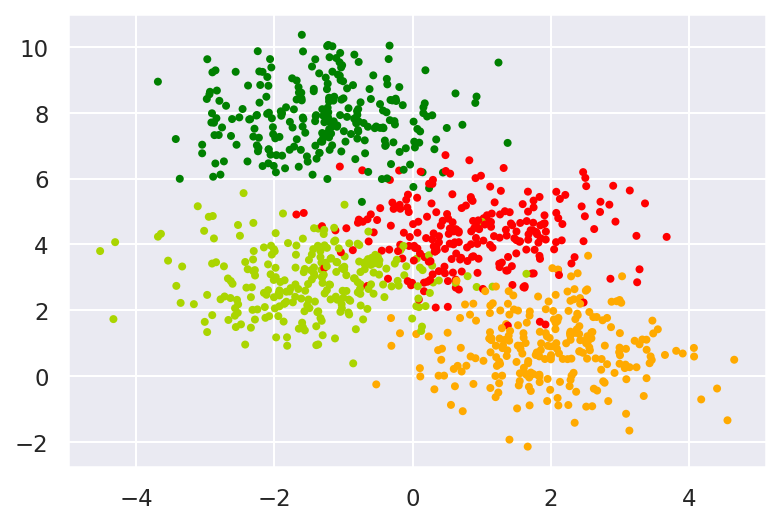

In [ ]:
cmap1 = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","yellow","green"])
data,labels = make_blobs(n_samples=1000, n_features=2,centers=4, random_state=0)
plt.figure(dpi=150)
plt.scatter(data[:,0],data[:,1],c=labels, cmap= cmap1,s=8)
plt.show()
 
#Generating data for training and testing, and visualizing
#Features 2 means x1 & x2 and centers 4 mean 4 possible values of y

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(data,labels, stratify=labels, random_state=0)
print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)
Y_train1 = Y_train.reshape(-1,1)
onehotencoder = OneHotEncoder() 
Y_train2 = onehotencoder.fit_transform(Y_train1).toarray()
 
#Splitting the data for training and testing, ensuring proper distribution of y
#One hot encoding to get in the forms of 0s and 1s, appropriate for training

(750, 2) (750,) (250, 2) (250,)


In [ ]:
class FFNetwork_Sp:

  def __init__(self, algo):
    self.algo = algo
    self.input = 2
    self.output = 4
    self.nh = 2
    self.neurons = 8
    self.W = {}
    self.B = {}
    self.W[1] = np.random.randn(2,2)
    self.W[2] = np.random.randn(4,2)
    self.B[1] = np.zeros([2,1])
    self.B[2] = np.zeros([4,1])
    self.loss = []
  
  def sigmoid(self,X):
    return 1.0/(1.0 + np.exp(-X))
  
  
  def forward_pass(self,X,w=None,b=None):
    if w != None:
      self.W = w
    if b != None:
      self.B = b
    self.A = {}
    self.H = {}
    self.H[0] = np.transpose(X) #Final is a 2XN matrix N is 750
    self.A[1] = np.matmul(self.W[1],self.H[0]) + self.B[1] # (2X2) * (2XN) ---> (2XN)
    self.H[1] = self.sigmoid(self.A[1]) #(2XN)
    self.A[2] = np.matmul(self.W[2],self.H[1]) + self.B[2]
    sum = np.sum(np.exp(self.A[2]),axis=0)
    self.H[2] = np.exp(self.A[2])/sum 
    return self.H[2] #(4XN)
  
  def grad_sigmoid(self,X):
    return X*(1-X)
  
  def cross_entropy(self,Y,Y_pred):
    y_temp = np.multiply(Y,Y_pred)
    y_temp = y_temp[y_temp != 0]
    y_temp1 = -np.log(y_temp)
    return np.mean(y_temp1)


  
  def predict(self,X):
    Y_pred = self.forward_pass(X)
    return Y_pred.squeeze()

  def grad(self,X,Y,w=None,b=None):
    if w != None:
      self.W = w
    if b != None:
      self.B = b
    self.forward_pass(X)
    self.dA = {}
    self.dH = {}
    self.dW = {}
    self.dB = {}
    self.dA[2] = (self.H[2]-np.transpose(Y))  
    self.dW[2] = np.matmul(self.dA[2],np.transpose(self.H[1]))
    self.dB[2] = np.sum(self.dA[2],axis=1).reshape(-1,1)
    self.dH[1] = np.matmul(np.transpose(self.W[2]),self.dA[2])
    self.dA[1] = np.multiply(self.dH[1],self.grad_sigmoid(self.H[1]))
    self.dW[1] = np.matmul(self.dA[1],np.transpose(self.H[0]))
    self.dB[1] = np.sum(self.dA[1],axis=1).reshape(-1,1)



  def train(self,X,Y,epochs=1,lr=1,initialise=1, gamma=0.9, epsilon = 1e-8, beta=0.9,batch_size=250, beta1 = 0.9, beta2 = 0.9):
    if initialise==1:
      self.W = {}
      self.B = {}
      self.W[1] = np.random.randn(2,2)
      self.W[2] = np.random.randn(4,2)
      self.B[1] = np.zeros([2,1])
      self.B[2] = np.zeros([4,1])

    if self.algo == "GD":
      # loss = []
      for j in tqdm_notebook(range(epochs)):
        self.grad(X,Y)
        m = X.shape[0]
        for i in range(2):
          self.W[i+1] -= lr * self.dW[i+1]
          self.B[i+1] -= lr * self.dB[i+1]   
        # print('w1 is',self.W[1])
        # print('w2 is',self.W[2])
        Y_pred = self.predict(X).T
        self.loss.append(self.cross_entropy(Y,Y_pred))
    
    elif self.algo == "Momentum":
      # loss = []
      v_w = {}
      v_b = {}
      v_w[1] = np.zeros([2,2])
      v_b[1] = np.zeros([2,1])
      v_w[2] = np.zeros([4,2])
      v_b[2] = np.zeros([4,1])

      for j in tqdm_notebook(range(epochs)):
        self.grad(X,Y)
        for i in range(2):
          v_w[i+1] = (gamma*v_w[i+1]) + (lr*self.dW[i+1])
          v_b[i+1] = (gamma*v_b[i+1]) + (lr*self.dB[i+1])
        for i in range(2):
          self.W[i+1] -= v_w[i+1]
          self.B[i+1] -= v_b[i+1]
        Y_pred = self.predict(X).T
        self.loss.append(self.cross_entropy(Y,Y_pred))


    elif self.algo == "Adagrad":
      # loss = []
      v_w = {}
      v_b = {}
      v_w[1] = np.zeros([2,2])
      v_b[1] = np.zeros([2,1])
      v_w[2] = np.zeros([4,2])
      v_b[2] = np.zeros([4,1])

      for j in tqdm_notebook(range(epochs)):
        self.grad(X,Y)
        for i in range(2):
          v_w[i+1] += np.square(self.dW[i+1])
          v_b[i+1] += np.square(self.dB[i+1])
        for i in range(2):
          self.W[i+1] -= ((lr/(np.sqrt(v_w[i+1])+ epsilon))*self.dW[i+1])
          self.B[i+1] -= ((lr/(np.sqrt(v_b[i+1])+ epsilon))*self.dB[i+1])
        Y_pred = self.predict(X).T
        self.loss.append(self.cross_entropy(Y,Y_pred))
    
    elif self.algo == "RMSProp":
      # loss = []
      v_w = {}
      v_b = {}
      v_w[1] = np.zeros([2,2])
      v_b[1] = np.zeros([2,1])
      v_w[2] = np.zeros([4,2])
      v_b[2] = np.zeros([4,1])

      for j in tqdm_notebook(range(epochs)):
        self.grad(X,Y)
        for i in range(2):
          v_w[i+1] = (beta*v_w[i+1]) + ((1-beta)*np.square(self.dW[i+1]))
          v_b[i+1] = (beta*v_b[i+1]) + ((1-beta)*np.square(self.dB[i+1]))
        for i in range(2):
          self.W[i+1] -= ((lr/(np.sqrt(v_w[i+1])+ epsilon))*self.dW[i+1])
          self.B[i+1] -= ((lr/(np.sqrt(v_b[i+1])+ epsilon))*self.dB[i+1])
        Y_pred = self.predict(X).T
        self.loss.append(self.cross_entropy(Y,Y_pred))
     
    elif self.algo == "MiniBatch":
     parts = int(X.shape[0]/batch_size)
     X_new_temp = np.array_split(X,parts)
     Y_new_temp = np.array_split(Y,parts)
     X_new = []
     Y_new = []
     for x,y in zip(X_new_temp,Y_new_temp):
      if x.shape[0] > 0:
       X_new.append(x)
       Y_new.append(y)
       
     for i in tqdm_notebook(range(epochs)):
      for j in range(len(X_new)):
       self.grad(X_new[j],Y_new[j])
       for i in range(2):
        self.W[i+1] -= lr * self.dW[i+1]/batch_size
        self.B[i+1] -= lr * self.dB[i+1]/batch_size
       Y_pred = self.predict(X).T
       self.loss.append(self.cross_entropy(Y,Y_pred))

    elif self.algo == "Adam":
      # X_new = np.array_split(X,X.shape[0])
      # Y_new = np.array_split(Y,X.shape[0])
      v_w = {}
      v_b = {}
      v_w[1] = np.zeros([2,2])
      v_b[1] = np.zeros([2,1])
      v_w[2] = np.zeros([4,2])
      v_b[2] = np.zeros([4,1])
      
      m_w = {}
      m_b = {}
      m_w[1] = np.zeros([2,2])
      m_b[1] = np.zeros([2,1])
      m_w[2] = np.zeros([4,2])
      m_b[2] = np.zeros([4,1])


      v_w_c = {}
      v_b_c = {}

      
      m_w_c = {}
      m_b_c = {}
      count = 0

      for j in tqdm_notebook(range(epochs)):
        dw = {}
        db = {}
        dw[1] = np.zeros([2,2])
        dw[2] = np.zeros([4,2])
        db[1] = np.zeros([2,1])
        db[2] = np.zeros([4,1])
        
        # for j in range(X.shape[0]):
          # self.grad(X_new[j],Y_new[j])
        self.grad(X,Y)
        for i in range(2):
            dw[i+1] += self.dW[i+1]
            db[i+1] += self.dB[i+1]
        count += 1
        for i in range(2):
            v_w[i+1] = (beta1*v_w[i+1]) + ((1 - beta1)*(dw[i+1]**2)) 
            v_b[i+1] = (beta1*v_b[i+1]) + ((1 - beta1)*(db[i+1]**2))
            m_w[i+1] = (beta2*m_w[i+1]) + ((1 - beta2)*(dw[i+1]))
            m_b[i+1] = (beta2*m_b[i+1]) + ((1 - beta2)*(db[i+1]))
            v_w_c[i+1] = v_w[i+1]/(1 - math.pow(beta1, count))
            v_b_c[i+1] = v_b[i+1]/(1 - math.pow(beta1, count))
            m_w_c[i+1] = m_w[i+1]/(1 - math.pow(beta2, count))
            m_b_c[i+1] = m_b[i+1]/(1 - math.pow(beta2, count))
            self.W[i+1] -= (lr/(np.sqrt(v_w_c[i+1])+epsilon))*(m_w_c[i+1])
            self.B[i+1] -= (lr/(np.sqrt(v_b_c[i+1])+epsilon))*(m_b_c[i+1])
        Y_pred = self.predict(X).T
        self.loss.append(self.cross_entropy(Y,Y_pred))
      
     
    elif self.algo == "NAG":
      v_w = {}
      v_b = {}
      w_temp = {}
      b_temp = {}
      v_w[1] = np.zeros([2,2])
      v_b[1] = np.zeros([2,1])
      v_w[2] = np.zeros([4,2])
      v_b[2] = np.zeros([4,1])

      for j in tqdm_notebook(range(epochs)):
        for i in range(2):
          w_temp[i+1] = self.W[i+1] - v_w[i+1]
          b_temp[i+1] = self.B[i+1] - v_b[i+1]
        
        self.grad(X,Y,w = w_temp,b = b_temp)
        for i in range(2):
          self.W[i+1] -= lr*self.dW[i+1]
          self.B[i+1] -= lr*self.dB[i+1]
          v_w[i+1] = (gamma*v_w[i+1] )+ (lr*self.dW[i+1])
          v_b[i+1] = (gamma*v_b[i+1] )+ (lr*self.dB[i+1])
        Y_pred = self.predict(X).T
        self.loss.append(self.cross_entropy(Y,Y_pred))
        






    plt.figure(dpi=150)
    plt.plot(self.loss)
    plt.xlabel('Epochs')
    plt.ylabel('Cross Entropy Loss')
    plt.title('Loss During Training')
    plt.show()
    # print(loss)


#Specific class for FF network, similar to what is done in feedforward Notebook
#Vectorisation has been implemented for faster learning
#Specific class works for 2 inputs, followed by 2 neurons and then 4 neurons to predict the output
#Taken the Multiclass, general, vectorized class written in the earlier notebook and made it for specific
#New learning algorithms have been introduced
#Each algo is represented in the text box written above
#There is a bias correction done with the Adam algorithm here for proper training

In [ ]:
%%time
nw = FFNetwork_Sp("GD")
nw.train(X_train,Y_train2,epochs=2000, lr=0.005, initialise=1, gamma=0.921)
Y_pred_train1 = nw.predict(X_train)
Y_pred_train2 = Y_pred_train1.T
Y_pred_train3 = []
for y in Y_pred_train2:
  y_temp = np.argmax(y) 
  Y_pred_train3.append(y_temp)
Y_pred_train = np.asarray(Y_pred_train3)
Y_pred_test1 = nw.predict(X_test)
Y_pred_test2 = Y_pred_test1.T
Y_pred_test3 = []
for y in Y_pred_test2:
  y_temp = np.argmax(y)
  Y_pred_test3.append(y_temp)
Y_pred_test = np.asarray(Y_pred_test3)
print('Train accuracy is',accuracy_score(Y_pred_train,Y_train))
print('Test accuracy is',accuracy_score(Y_pred_test,Y_test))
print('Min loss is', min(nw.loss))

#We initialise the class and carry out training as usual
#Once that is done, we then predict the output for X_train and X_test
#Once we have output, we convert it from one hot encoded back to its usual form
#Accuracy for training and test data is then calculated

In [ ]:
nw.loss

In [ ]:
class FFNetwork_GN:

  def __init__(self, algo, n_inputs, n_outputs, h_layers = [2]):
    self.algo = algo
    self.inputs = n_inputs
    self.output = n_outputs
    self.nh = len(h_layers)
    self.neurons = [n_inputs] + h_layers + [n_outputs]
    self.W = {}
    self.B = {}
    
    for i in range(self.nh+1):
      self.W[i+1] = np.random.randn(self.neurons[i+1],self.neurons[i])
      self.B[i+1] = np.zeros([self.neurons[i+1],1])
    self.loss = []
  
  def sigmoid(self,X):
    return 1.0/(1.0 + np.exp(-X))
  
  
  def forward_pass(self,X,w=None,b=None):
    if w != None:
      self.W = w
    if b != None:
      self.B = b
    self.A = {}
    self.H = {}
    self.H[0] = np.transpose(X) #Final is a 2XN matrix N is 750
    for i in range(self.nh):
      self.A[i+1] = np.matmul(self.W[i+1],self.H[i]) + self.B[i+1]
      self.H[i+1] = self.sigmoid(self.A[i+1])
    self.A[self.nh+1] = np.matmul(self.W[self.nh+1],self.H[self.nh]) + self.B[self.nh+1]
    sum_a = np.sum(np.exp(self.A[self.nh+1]),axis=0)
    self.H[self.nh+1] = np.exp(self.A[self.nh+1])/sum_a
    return self.H[self.nh+1]

  
  def grad_sigmoid(self,X):
    return X*(1-X)
  
  def cross_entropy(self,Y,Y_pred):
    y_temp = np.multiply(Y,Y_pred)
    y_temp = y_temp[y_temp != 0]
    y_temp1 = -np.log(y_temp)
    return np.mean(y_temp1)


  
  def predict(self,X):
    Y_pred = self.forward_pass(X)
    return Y_pred.squeeze()

  def grad(self,X,Y,w=None,b=None):
    if w != None:
      self.W = w
    if b != None:
      self.B = b
    self.forward_pass(X)
    self.dA = {}
    self.dH = {}
    self.dW = {}
    self.dB = {}
    self.dA[self.nh+1] = (self.H[self.nh+1]-np.transpose(Y))  
    L = self.nh +1
    for i in range(L,0,-1):
      self.dW[i] = np.matmul(self.dA[i],np.transpose(self.H[i-1]))
      self.dB[i] = np.sum(self.dA[i],axis=1).reshape(-1,1)
      if i>1:
        self.dH[i-1] = np.matmul(np.transpose(self.W[i]),self.dA[i])
        self.dA[i-1] = np.multiply(self.dH[i-1],self.grad_sigmoid(self.H[i-1]))


  def train(self,X,Y,epochs=1,lr=1,initialise=1, gamma=0.9, epsilon = 1e-8, beta=0.9,batch_size=250, beta1 = 0.9, beta2 = 0.9):
    if initialise==1:
      self.W = {}
      self.B = {}
      for i in range(self.nh+1):
        self.W[i+1] = np.random.randn(self.neurons[i+1],self.neurons[i])
        self.B[i+1] = np.zeros([self.neurons[i+1],1])

    if self.algo == "GD":
      # loss = []
      for j in tqdm_notebook(range(epochs)):
        self.grad(X,Y)
        m = X.shape[0]
        for i in range(self.nh+1):
          self.W[i+1] -= lr * self.dW[i+1]
          self.B[i+1] -= lr * self.dB[i+1]   
        # print('w1 is',self.W[1])
        # print('w2 is',self.W[2])
        Y_pred = self.predict(X).T
        self.loss.append(self.cross_entropy(Y,Y_pred))
    
    elif self.algo == "Momentum":
      # loss = []
      v_w = {}
      v_b = {}
      for i in range(self.nh+1):
        v_w[i+1] = np.zeros([self.neurons[i+1],self.neurons[i]])
        v_b[i+1] = np.zeros([self.neurons[i+1],1])

      for j in tqdm_notebook(range(epochs)):
        self.grad(X,Y)
        for i in range(self.nh+1):
          v_w[i+1] = (gamma*v_w[i+1]) + (lr*self.dW[i+1])
          v_b[i+1] = (gamma*v_b[i+1]) + (lr*self.dB[i+1])
        for i in range(self.nh+1):
          self.W[i+1] -= v_w[i+1]
          self.B[i+1] -= v_b[i+1]
        Y_pred = self.predict(X).T
        self.loss.append(self.cross_entropy(Y,Y_pred))


    elif self.algo == "Adagrad":
      # loss = []
      v_w = {}
      v_b = {}
      for i in range(self.nh+1):
        v_w[i+1] = np.zeros([self.neurons[i+1],self.neurons[i]])
        v_b[i+1] = np.zeros([self.neurons[i+1],1])

      for j in tqdm_notebook(range(epochs)):
        self.grad(X,Y)
        for i in range(self.nh+1):
          v_w[i+1] += np.square(self.dW[i+1])
          v_b[i+1] += np.square(self.dB[i+1])
        for i in range(self.nh+1):
          self.W[i+1] -= ((lr/(np.sqrt(v_w[i+1])+ epsilon))*self.dW[i+1])
          self.B[i+1] -= ((lr/(np.sqrt(v_b[i+1])+ epsilon))*self.dB[i+1])
        Y_pred = self.predict(X).T
        self.loss.append(self.cross_entropy(Y,Y_pred))
    
    elif self.algo == "RMSProp":
      # loss = []
      v_w = {}
      v_b = {}
      for i in range(self.nh+1):
        v_w[i+1] = np.zeros([self.neurons[i+1],self.neurons[i]])
        v_b[i+1] = np.zeros([self.neurons[i+1],1])

      for j in tqdm_notebook(range(epochs)):
        self.grad(X,Y)
        for i in range(self.nh+1):
          v_w[i+1] = (beta*v_w[i+1]) + ((1-beta)*np.square(self.dW[i+1]))
          v_b[i+1] = (beta*v_b[i+1]) + ((1-beta)*np.square(self.dB[i+1]))
        for i in range(self.nh+1):
          self.W[i+1] -= ((lr/(np.sqrt(v_w[i+1])+ epsilon))*self.dW[i+1])
          self.B[i+1] -= ((lr/(np.sqrt(v_b[i+1])+ epsilon))*self.dB[i+1])
        Y_pred = self.predict(X).T
        self.loss.append(self.cross_entropy(Y,Y_pred))
     
    elif self.algo == "MiniBatch":
     parts = int(X.shape[0]/batch_size)
     X_new_temp = np.array_split(X,parts)
     Y_new_temp = np.array_split(Y,parts)
     X_new = []
     Y_new = []
     for x,y in zip(X_new_temp,Y_new_temp):
      if x.shape[0] > 0:
       X_new.append(x)
       Y_new.append(y)
       
     for i in tqdm_notebook(range(epochs)):
      for j in range(len(X_new)):
       self.grad(X_new[j],Y_new[j])
       for i in range(self.nh+1):
        self.W[i+1] -= lr * self.dW[i+1]/batch_size
        self.B[i+1] -= lr * self.dB[i+1]/batch_size
       Y_pred = self.predict(X).T
       self.loss.append(self.cross_entropy(Y,Y_pred))

    elif self.algo == "Adam":
      # X_new = np.array_split(X,X.shape[0])
      # Y_new = np.array_split(Y,X.shape[0])
      v_w = {}
      v_b = {}
      for i in range(self.nh+1):
        v_w[i+1] = np.zeros([self.neurons[i+1],self.neurons[i]])
        v_b[i+1] = np.zeros([self.neurons[i+1],1])
      
      m_w = {}
      m_b = {}
      for i in range(self.nh+1):
        m_w[i+1] = np.zeros([self.neurons[i+1],self.neurons[i]])
        m_b[i+1] = np.zeros([self.neurons[i+1],1])


      v_w_c = {}
      v_b_c = {}

      
      m_w_c = {}
      m_b_c = {}
      count = 0

      for j in tqdm_notebook(range(epochs)):
      #   dW = {}
      #   dB = {}
      # for i in range(self.nh+1):
      #   dW[i+1] = np.zeros([self.neurons[i+1],self.neurons[i]])
      #   dB[i+1] = np.zeros([self.neurons[i+1],1])
        
        # for j in range(X.shape[0]):
          # self.grad(X_new[j],Y_new[j])
        self.grad(X,Y)
        # for i in range(self.nh+1):
        #     dW[i+1] += self.dW[i+1]
        #     dB[i+1] += self.dB[i+1]
        count += 1
        for i in range(self.nh+1):
            v_w[i+1] = (beta1*v_w[i+1]) + ((1 - beta1)*(self.dW[i+1]**2)) 
            v_b[i+1] = (beta1*v_b[i+1]) + ((1 - beta1)*(self.dB[i+1]**2))
            m_w[i+1] = (beta2*m_w[i+1]) + ((1 - beta2)*(self.dW[i+1]))
            m_b[i+1] = (beta2*m_b[i+1]) + ((1 - beta2)*(self.dB[i+1]))
            v_w_c[i+1] = v_w[i+1]/(1 - math.pow(beta1, count))
            v_b_c[i+1] = v_b[i+1]/(1 - math.pow(beta1, count))
            m_w_c[i+1] = m_w[i+1]/(1 - math.pow(beta2, count))
            m_b_c[i+1] = m_b[i+1]/(1 - math.pow(beta2, count))
            self.W[i+1] -= (lr/(np.sqrt(v_w_c[i+1])+epsilon))*(m_w_c[i+1])
            self.B[i+1] -= (lr/(np.sqrt(v_b_c[i+1])+epsilon))*(m_b_c[i+1])
        Y_pred = self.predict(X).T
        self.loss.append(self.cross_entropy(Y,Y_pred))
      
     
    elif self.algo == "NAG":
      v_w = {}
      v_b = {}
      w_temp = {}
      b_temp = {}
      for i in range(self.nh+1):
        v_w[i+1] = np.zeros([self.neurons[i+1],self.neurons[i]])
        v_b[i+1] = np.zeros([self.neurons[i+1],1])

      for j in tqdm_notebook(range(epochs)):
        for i in range(self.nh+1):
          w_temp[i+1] = self.W[i+1] - v_w[i+1]
          b_temp[i+1] = self.B[i+1] - v_b[i+1]
        
        self.grad(X,Y,w = w_temp,b = b_temp)
        for i in range(self.nh+1):
          self.W[i+1] -= lr*self.dW[i+1]
          self.B[i+1] -= lr*self.dB[i+1]
          v_w[i+1] = (gamma*v_w[i+1] )+ (lr*self.dW[i+1])
          v_b[i+1] = (gamma*v_b[i+1] )+ (lr*self.dB[i+1])
        Y_pred = self.predict(X).T
        self.loss.append(self.cross_entropy(Y,Y_pred))
        






    plt.figure(dpi=150)
    plt.plot(self.loss)
    plt.xlabel('Epochs')
    plt.ylabel('Cross Entropy Loss')
    plt.title('Loss During Training')
    plt.show()
    # print(loss)


#This is the general class written for training with our new learning algorithms on any network
#Inputs and outputs are taken in while instantiating the class and the rest of the training is as usual

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:163: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


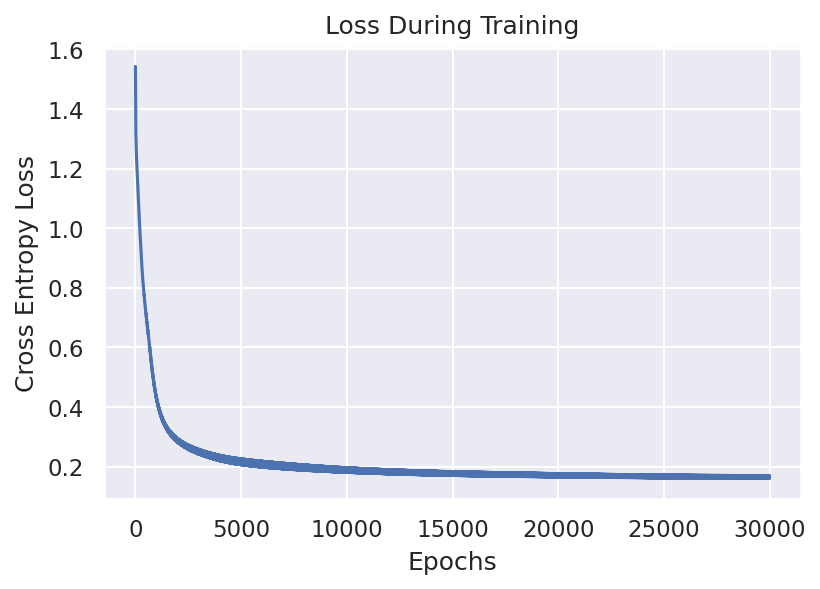

Train accuracy is 0.9253333333333333
Test accuracy is 0.94
Min loss is 0.16082914528499537


In [ ]:
nw = FFNetwork_GN("MiniBatch",2,4,h_layers=[4,3])
nw.train(X_train,Y_train2,epochs=2000, lr=0.1, initialise=1, gamma=0.9,batch_size=50)
Y_pred_train1 = nw.predict(X_train)
Y_pred_train2 = Y_pred_train1.T
Y_pred_train3 = []
for y in Y_pred_train2:
  y_temp = np.argmax(y) 
  Y_pred_train3.append(y_temp)
Y_pred_train = np.asarray(Y_pred_train3)
Y_pred_test1 = nw.predict(X_test)
Y_pred_test2 = Y_pred_test1.T
Y_pred_test3 = []
for y in Y_pred_test2:
  y_temp = np.argmax(y)
  Y_pred_test3.append(y_temp)
Y_pred_test = np.asarray(Y_pred_test3)
print('Train accuracy is',accuracy_score(Y_pred_train,Y_train))
print('Test accuracy is',accuracy_score(Y_pred_test,Y_test))
print('Min loss is', min(nw.loss))


#Same here, we predict output for X_train and X_test after training
#Accuracy score is then calculated

#Activation Functions and Initialization Methods

Here we'll see some of the commonly used activation functions and initialization methods. We will directly write this for our general FF network classes and plot the changes in w and be to see how each method works.

### Random Initialization 
All values initialised to random between [0,1]

### Zero Initialization 
All values initialised to 0

### Xavier Initialization 
All values initialised to random between [0,1], divided by $\sqrt{n}$, where n is the number of input neurons.

### He Initialization 
All values initialised to random between [0,1], divided by $\sqrt{\frac{n}{2}}$, where n is the number of input neurons.

### Sigmoid Activation

$f(x) = \frac{1}{1 + e^{-x}}$

### Tanh Activation

$f(x) = \frac{e^{x} - e^{-x}}{e^{x} + e^{-x}}$

### ReLu Activation

$f(x) = max(0,x)$

### Leaky ReLu Activation

$f(x) = max(0.01x,x)$

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score , mean_squared_error
import matplotlib.colors
import math
from sklearn.datasets import make_blobs
from sklearn.compose import ColumnTransformer
sns.set()



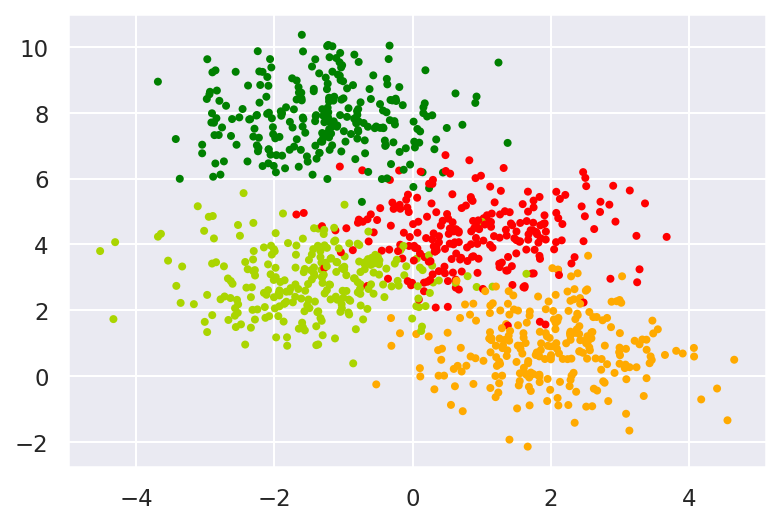

In [ ]:
cmap1 = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","yellow","green"])
data,labels = make_blobs(n_samples=1000, n_features=2,centers=4, random_state=0)
plt.figure(dpi=150)
plt.scatter(data[:,0],data[:,1],c=labels, cmap= cmap1,s=8)
plt.show()

#Generating data for training

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(data,labels, stratify=labels, random_state=0)
print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)
Y_train1 = Y_train.reshape(-1,1)
onehotencoder = OneHotEncoder() 
Y_train2 = onehotencoder.fit_transform(Y_train1).toarray()


(750, 2) (750,) (250, 2) (250,)


In [ ]:
class FFNetwork_In_Ac:
 
  def __init__(self, algo, n_inputs, n_outputs,init_method,activation_func,h_layers = [2]):
    self.algo = algo
    self.inputs = n_inputs
    self.output = n_outputs
    self.nh = len(h_layers)
    self.neurons = [n_inputs] + h_layers + [n_outputs]
    self.init_method = init_method
    self.activation_func = activation_func
    self.W = {}
    self.B = {}
    self.data_w = {}
    self.data_b = {}
    np.random.seed(0)
    for i in range(self.nh+1):
      if self.init_method == "Random":
        self.W[i+1] = np.random.randn(self.neurons[i+1],self.neurons[i])
        self.B[i+1] = np.random.randn(self.neurons[i+1],1)
      
      elif self.init_method == "Xavier":
        self.W[i+1] = np.random.randn(self.neurons[i+1],self.neurons[i])*(np.sqrt(1/(self.neurons[i])))
        self.B[i+1] = np.random.randn(self.neurons[i+1],1)
 
      elif self.init_method == "He":
        self.W[i+1] = np.random.randn(self.neurons[i+1],self.neurons[i])*(np.sqrt(2/(self.neurons[i])))
        self.B[i+1] = np.random.randn(self.neurons[i+1],1)
      
      elif self.init_method == "Zeros":
        self.W[i+1] = np.zeros((self.neurons[i+1],self.neurons[i]))
        self.B[i+1] = np.zeros((self.neurons[i+1],1))
 
 
    self.loss = []
  
  def forward_activation(self,X):
    if self.activation_func == "Sigmoid":
      return 1.0/(1.0 + np.exp(-X))
    elif self.activation_func == "tanh":
      return np.tanh(X)
    elif self.activation_func == "ReLu":
      return np.maximum(0,X)
    elif self.activation_func == "Leaky_ReLu":
      return np.maximum(0.01*X,X)
  
  def data_collect(self,w_list,b_list,j):
     list_data_w_flat = np.array([])
     list_data_b_flat = np.array([])
     for i in w_list:
       list_data_w_flat = np.concatenate((list_data_w_flat,i))
     for k in b_list:
       list_data_b_flat = np.concatenate((list_data_b_flat,k))
     self.data_w[j] = list_data_w_flat
     self.data_b[j] = list_data_b_flat
  
  
  def forward_pass(self,X,w=None,b=None):
    if w != None:
      self.W = w
    if b != None:
      self.B = b
    self.A = {}
    self.H = {}
    self.H[0] = np.transpose(X) #Final is a 2XN matrix N is 750
    for i in range(self.nh):
      self.A[i+1] = np.matmul(self.W[i+1],self.H[i]) + self.B[i+1]
      self.H[i+1] = self.forward_activation(self.A[i+1])
    self.A[self.nh+1] = np.matmul(self.W[self.nh+1],self.H[self.nh]) + self.B[self.nh+1]
    sum_a = np.sum(np.exp(self.A[self.nh+1]),axis=0)
    self.H[self.nh+1] = np.exp(self.A[self.nh+1])/sum_a
    return self.H[self.nh+1]
 
  
  def grad_activation(self,X):
    if self.activation_func == "Sigmoid":
      return X*(1-X)
    elif self.activation_func == "tanh":
      return (1-np.square(X))
    elif self.activation_func == "ReLu":
      return np.ceil(X/np.max(X)).astype(int)
    elif self.activation_func == "Leaky_ReLu":
      X_temp = X.ravel()
      for i in range(X_temp.shape[0]):
        if X_temp[i] <0:
          X_temp[i] = 0.01
        elif X_temp[i] > 0:
          X_temp[i] =1
      return X_temp.reshape(X.shape)
      
          
  
  def cross_entropy(self,Y,Y_pred):
    y_temp = np.multiply(Y,Y_pred)
    y_temp = y_temp[y_temp != 0]
    y_temp1 = -np.log(y_temp)
    return np.mean(y_temp1)
 
 
  
  def predict(self,X):
    Y_pred = self.forward_pass(X)
    return Y_pred.squeeze()
 
  def grad(self,X,Y,w=None,b=None):
    if w != None:
      self.W = w
    if b != None:
      self.B = b
    self.forward_pass(X)
    self.dA = {}
    self.dH = {}
    self.dW = {}
    self.dB = {}
    self.dA[self.nh+1] = (self.H[self.nh+1]-np.transpose(Y))  
    L = self.nh +1
    for i in range(L,0,-1):
      self.dW[i] = np.matmul(self.dA[i],np.transpose(self.H[i-1]))
      self.dB[i] = np.sum(self.dA[i],axis=1).reshape(-1,1)
      if i>1:
        self.dH[i-1] = np.matmul(np.transpose(self.W[i]),self.dA[i])
        self.dA[i-1] = np.multiply(self.dH[i-1],self.grad_activation(self.H[i-1]))
 
 
 
 
  def train(self,X,Y,epochs=1,lr=1, gamma=0.9, epsilon = 1e-8, beta=0.9,batch_size=250, beta1 = 0.9, beta2 = 0.9):
    if self.algo == "GD":
      # loss = []
      for j in tqdm_notebook(range(epochs)):
        self.grad(X,Y)
        m = X.shape[0]
        list_data_w = []
        list_data_b = []
        for i in range(self.nh+1):
          self.W[i+1] -= (lr * self.dW[i+1])
          self.B[i+1] -= (lr * self.dB[i+1])
          list_data_w.append(self.W[i+1].ravel())
          list_data_b.append(self.B[i+1].flatten())
        self.data_collect(list_data_w,list_data_b,j)
        Y_pred = self.predict(X).T
        self.loss.append(self.cross_entropy(Y,Y_pred))
 
    
    elif self.algo == "Momentum":
      # loss = []
      v_w = {}
      v_b = {}
      for i in range(self.nh+1):
        v_w[i+1] = np.zeros([self.neurons[i+1],self.neurons[i]])
        v_b[i+1] = np.zeros([self.neurons[i+1],1])
 
      for j in tqdm_notebook(range(epochs)):
        self.grad(X,Y)
        for i in range(self.nh+1):
          v_w[i+1] = (gamma*v_w[i+1]) + (lr*self.dW[i+1])
          v_b[i+1] = (gamma*v_b[i+1]) + (lr*self.dB[i+1])
        for i in range(self.nh+1):
          self.W[i+1] -= v_w[i+1]
          self.B[i+1] -= v_b[i+1]
        Y_pred = self.predict(X).T
        self.loss.append(self.cross_entropy(Y,Y_pred))
 
 
    elif self.algo == "Adagrad":
      # loss = []
      v_w = {}
      v_b = {}
      for i in range(self.nh+1):
        v_w[i+1] = np.zeros([self.neurons[i+1],self.neurons[i]])
        v_b[i+1] = np.zeros([self.neurons[i+1],1])
 
      for j in tqdm_notebook(range(epochs)):
        self.grad(X,Y)
        for i in range(self.nh+1):
          v_w[i+1] += np.square(self.dW[i+1])
          v_b[i+1] += np.square(self.dB[i+1])
        for i in range(self.nh+1):
          self.W[i+1] -= ((lr/(np.sqrt(v_w[i+1])+ epsilon))*self.dW[i+1])
          self.B[i+1] -= ((lr/(np.sqrt(v_b[i+1])+ epsilon))*self.dB[i+1])
        Y_pred = self.predict(X).T
        self.loss.append(self.cross_entropy(Y,Y_pred))
    
    elif self.algo == "RMSProp":
      # loss = []
      v_w = {}
      v_b = {}
      for i in range(self.nh+1):
        v_w[i+1] = np.zeros([self.neurons[i+1],self.neurons[i]])
        v_b[i+1] = np.zeros([self.neurons[i+1],1])
 
      for j in tqdm_notebook(range(epochs)):
        self.grad(X,Y)
        for i in range(self.nh+1):
          v_w[i+1] = (beta*v_w[i+1]) + ((1-beta)*np.square(self.dW[i+1]))
          v_b[i+1] = (beta*v_b[i+1]) + ((1-beta)*np.square(self.dB[i+1]))
        for i in range(self.nh+1):
          self.W[i+1] -= ((lr/(np.sqrt(v_w[i+1])+ epsilon))*self.dW[i+1])
          self.B[i+1] -= ((lr/(np.sqrt(v_b[i+1])+ epsilon))*self.dB[i+1])
        Y_pred = self.predict(X).T
        self.loss.append(self.cross_entropy(Y,Y_pred))
     
    elif self.algo == "MiniBatch":
     parts = int(X.shape[0]/batch_size)
     X_new_temp = np.array_split(X,parts)
     Y_new_temp = np.array_split(Y,parts)
     X_new = []
     Y_new = []
     for x,y in zip(X_new_temp,Y_new_temp):
      if x.shape[0] > 0:
       X_new.append(x)
       Y_new.append(y)
       
     for i in tqdm_notebook(range(epochs)):
      for j in range(len(X_new)):
       self.grad(X_new[j],Y_new[j])
       for i in range(self.nh+1):
        self.W[i+1] -= lr * self.dW[i+1]/batch_size
        self.B[i+1] -= lr * self.dB[i+1]/batch_size
       Y_pred = self.predict(X).T
       self.loss.append(self.cross_entropy(Y,Y_pred))
 
    elif self.algo == "Adam":
      # X_new = np.array_split(X,X.shape[0])
      # Y_new = np.array_split(Y,X.shape[0])
      v_w = {}
      v_b = {}
      for i in range(self.nh+1):
        v_w[i+1] = np.zeros([self.neurons[i+1],self.neurons[i]])
        v_b[i+1] = np.zeros([self.neurons[i+1],1])
      
      m_w = {}
      m_b = {}
      for i in range(self.nh+1):
        m_w[i+1] = np.zeros([self.neurons[i+1],self.neurons[i]])
        m_b[i+1] = np.zeros([self.neurons[i+1],1])
 
 
      v_w_c = {}
      v_b_c = {}
 
      
      m_w_c = {}
      m_b_c = {}
      count = 0
 
      for j in tqdm_notebook(range(epochs)):
      #   dW = {}
      #   dB = {}
      # for i in range(self.nh+1):
      #   dW[i+1] = np.zeros([self.neurons[i+1],self.neurons[i]])
      #   dB[i+1] = np.zeros([self.neurons[i+1],1])
        
        # for j in range(X.shape[0]):
          # self.grad(X_new[j],Y_new[j])
        self.grad(X,Y)
        # for i in range(self.nh+1):
        #     dW[i+1] += self.dW[i+1]
        #     dB[i+1] += self.dB[i+1]
        count += 1
        for i in range(self.nh+1):
            v_w[i+1] = (beta1*v_w[i+1]) + ((1 - beta1)*(self.dW[i+1]**2)) 
            v_b[i+1] = (beta1*v_b[i+1]) + ((1 - beta1)*(self.dB[i+1]**2))
            m_w[i+1] = (beta2*m_w[i+1]) + ((1 - beta2)*(self.dW[i+1]))
            m_b[i+1] = (beta2*m_b[i+1]) + ((1 - beta2)*(self.dB[i+1]))
            v_w_c[i+1] = v_w[i+1]/(1 - math.pow(beta1, count))
            v_b_c[i+1] = v_b[i+1]/(1 - math.pow(beta1, count))
            m_w_c[i+1] = m_w[i+1]/(1 - math.pow(beta2, count))
            m_b_c[i+1] = m_b[i+1]/(1 - math.pow(beta2, count))
            self.W[i+1] -= (lr/(np.sqrt(v_w_c[i+1])+epsilon))*(m_w_c[i+1])
            self.B[i+1] -= (lr/(np.sqrt(v_b_c[i+1])+epsilon))*(m_b_c[i+1])
        Y_pred = self.predict(X).T
        self.loss.append(self.cross_entropy(Y,Y_pred))
      
     
    elif self.algo == "NAG":
      v_w = {}
      v_b = {}
      w_temp = {}
      b_temp = {}
      for i in range(self.nh+1):
        v_w[i+1] = np.zeros([self.neurons[i+1],self.neurons[i]])
        v_b[i+1] = np.zeros([self.neurons[i+1],1])
 
      for j in tqdm_notebook(range(epochs)):
        for i in range(self.nh+1):
          w_temp[i+1] = self.W[i+1] - v_w[i+1]
          b_temp[i+1] = self.B[i+1] - v_b[i+1]
        
        self.grad(X,Y,w = w_temp,b = b_temp)
        for i in range(self.nh+1):
          self.W[i+1] -= lr*self.dW[i+1]
          self.B[i+1] -= lr*self.dB[i+1]
          v_w[i+1] = (gamma*v_w[i+1] )+ (lr*self.dW[i+1])
          v_b[i+1] = (gamma*v_b[i+1] )+ (lr*self.dB[i+1])
        Y_pred = self.predict(X).T
        self.loss.append(self.cross_entropy(Y,Y_pred))
  
 
 
    plt.figure(dpi=150)
    plt.plot(self.loss)
    plt.xlabel('Epochs')
    plt.ylabel('Cross Entropy Loss')
    plt.title('Loss During Training')
    plt.show()
    # print(loss)
 
 
#We've taken the general FF network with all learning algorithms from the previous section
#The forward and grad functions have been changed to accomodate all intialisation methods and activation functions
#We need to record all the values of w across the network for each epoch
#For that we save all w values of an epoch in a list and then concatenate all the values in the list
#These values are then stored in data_w and data_b
#This is carried out using the data_collect function at the top
#Right now we are only testing and implementing for GD algorithm

In [ ]:
def plot_training_weight_changes(nw,rows,cols,epochs,b_values,w=True,b=True):
  if w == True:
    data_w = list(nw.data_w.values())
    data_diff_w = []
    for i in range(epochs):
      data_diff_w.append(data_w[i] - data_w[i-1])
    fig = plt.subplots(rows,cols,figsize=(40,15))
    for j in tqdm_notebook(range(rows*cols)):
      for i in range(epochs):
        plt.subplot(rows,cols,j+1)
        plt.plot(i,data_diff_w[i][j],'.',c='k')
        plt.ylim(-.2,.2)
        plt.title('w'+str(j))
    plt.show()
  
  if b == True:
    data_b = list(nw.data_b.values())
    data_diff_b = []
    for i in range(epochs):
      data_diff_b.append(data_b[i] - data_b[i-1])
    fig = plt.subplots(rows,cols,figsize=(40,15))
    for j in tqdm_notebook(range(b_values)):
      for i in range(epochs):
        plt.subplot(rows,cols,j+1)
        plt.plot(i,data_diff_b[i][j],'.',c='k')
        plt.ylim(-.2,.2)
        plt.title('b'+str(j))
    plt.show()

def compute_accuracies(nw,X_train,X_test):
  Y_pred_train1 = nw.predict(X_train)
  Y_pred_train2 = Y_pred_train1.T
  Y_pred_train3 = []
  for y in Y_pred_train2:
    y_temp = np.argmax(y) 
    Y_pred_train3.append(y_temp)
  Y_pred_train = np.asarray(Y_pred_train3)
  Y_pred_test1 = nw.predict(X_test)
  Y_pred_test2 = Y_pred_test1.T
  Y_pred_test3 = []
  for y in Y_pred_test2:
    y_temp = np.argmax(y)
    Y_pred_test3.append(y_temp)
  Y_pred_test = np.asarray(Y_pred_test3)
  print('Train accuracy is',accuracy_score(Y_pred_train,Y_train))
  print('Test accuracy is',accuracy_score(Y_pred_test,Y_test))
  print('Min loss is', min(nw.loss))

#Here we'll take the data_w file from the class
#We find the differences in the first loop and store them in data_diff
#We then need to have that maby subplots as there are weights in the network
#In each subplot, we plot a particular position in the array for each epoch
#We do this for all positions in the array and return the subplots
#This is done separately for data_w and data_b

#The next function is used for computing accuracy on X_train and X_test

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


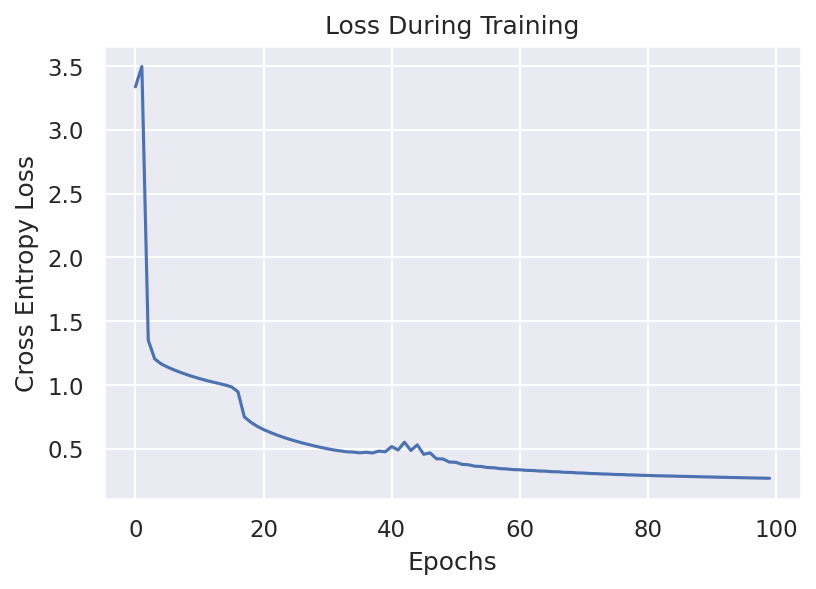

Train accuracy is 0.904
Test accuracy is 0.924
Min loss is 0.26773180207325087


In [ ]:
nw = FFNetwork_In_Ac("GD",2,4,h_layers=[2],init_method="He",activation_func="Leaky_ReLu")
nw.train(X_train,Y_train2,lr=0.0005,epochs=100)
compute_accuracies(nw,X_train,X_test)


#Here we are training the data with the written class 
#This is followed by computing accuracy and plotting with the 2 functions written above 
#!!!
#Whether or not an update is seen with zeros initialisation depends on how deep the network is
#This worked for a network with just one hidden layer, but failed to train on a deeper network i.e 4,3
#Either ways, zero initialisation sucks 

Activation function: Sigmoid  Intialisation method: Random


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


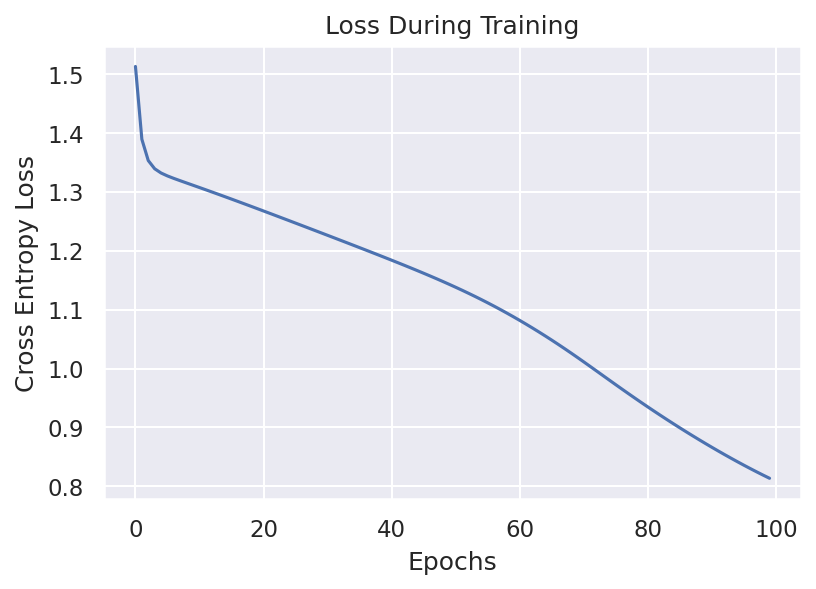

Train accuracy is 0.652
Test accuracy is 0.628
Min loss is 0.8137277751228549


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


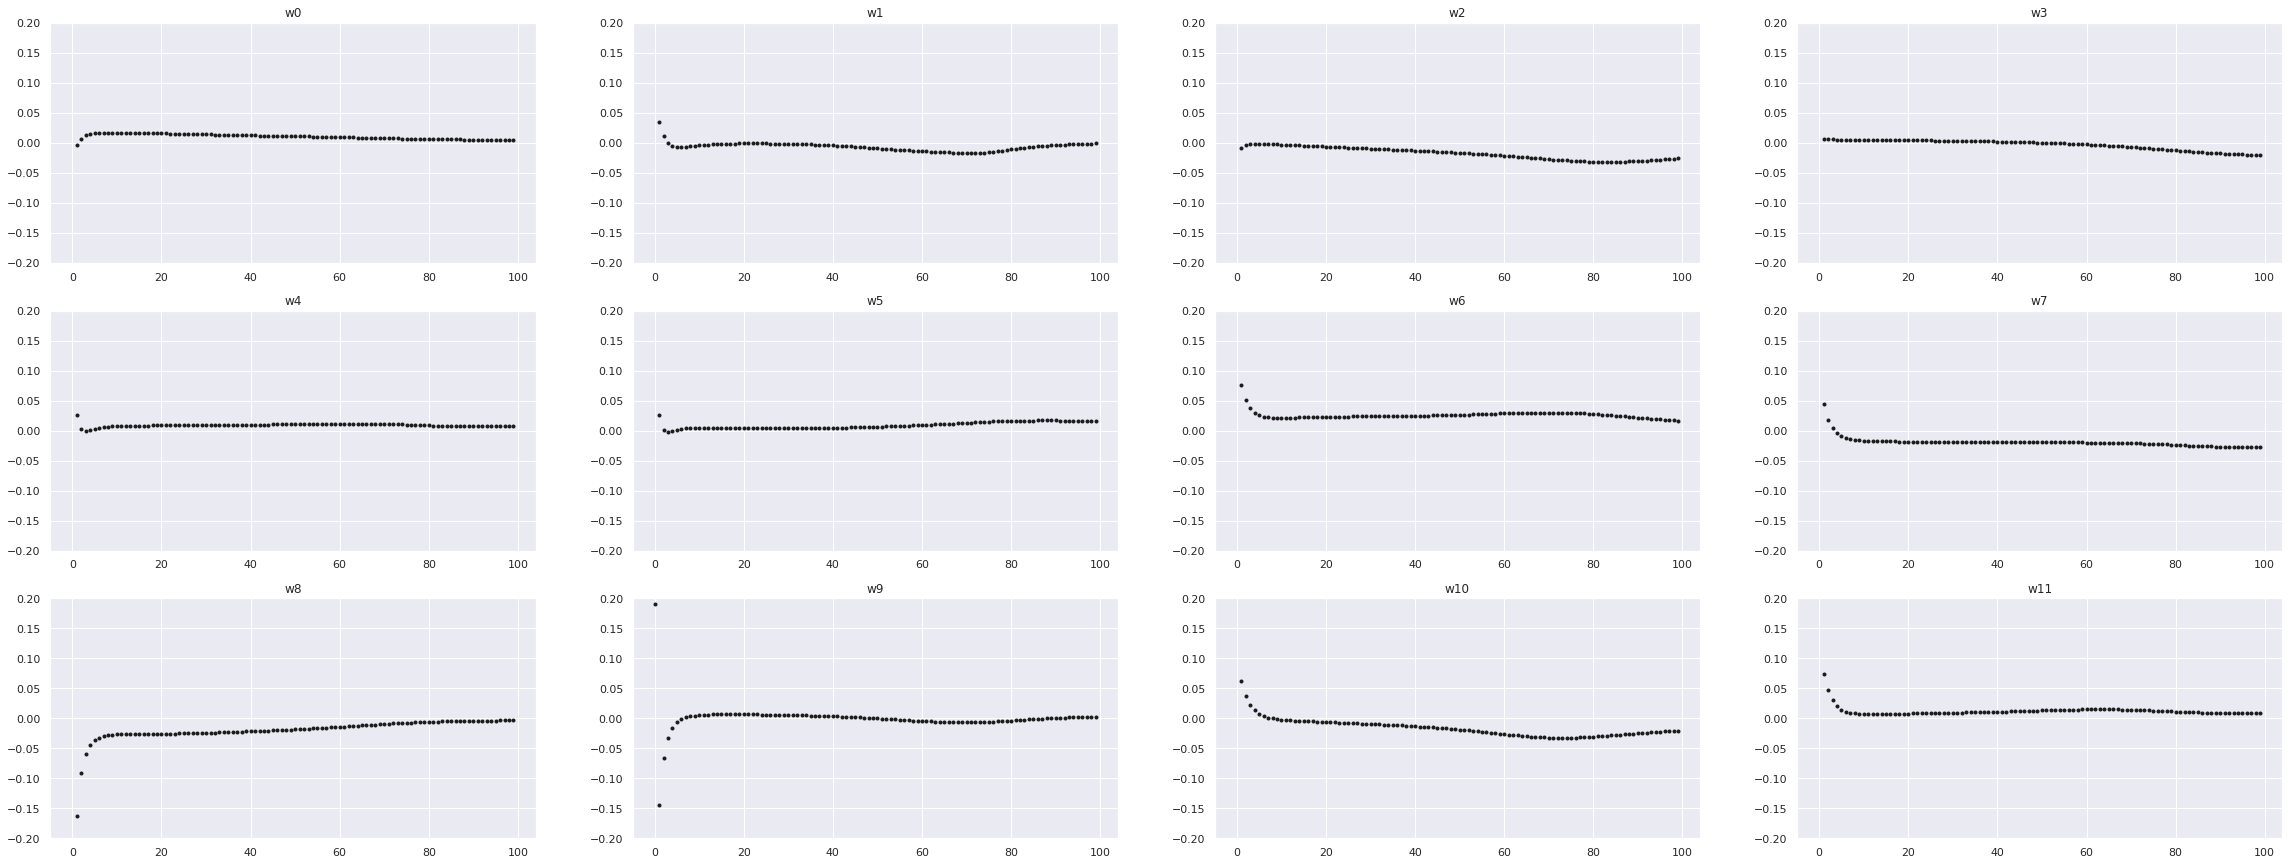

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


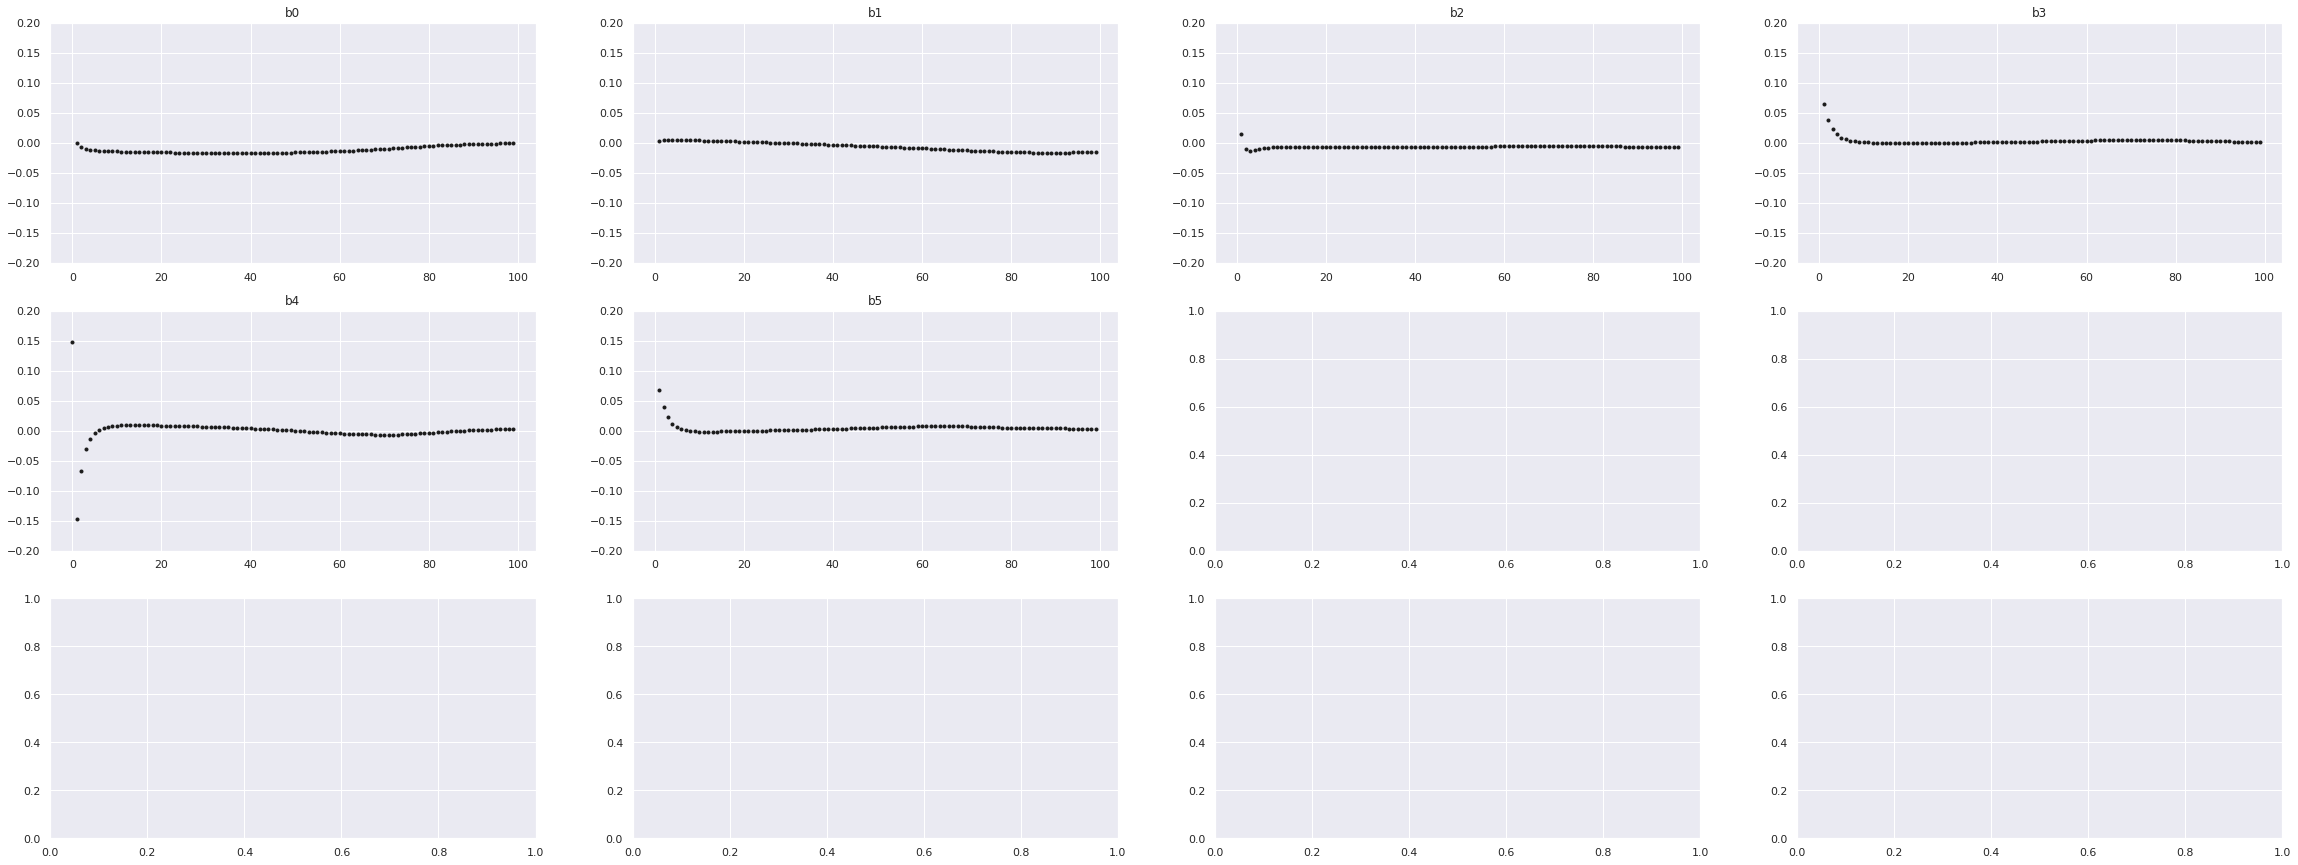

Activation function: Sigmoid  Intialisation method: Zeros


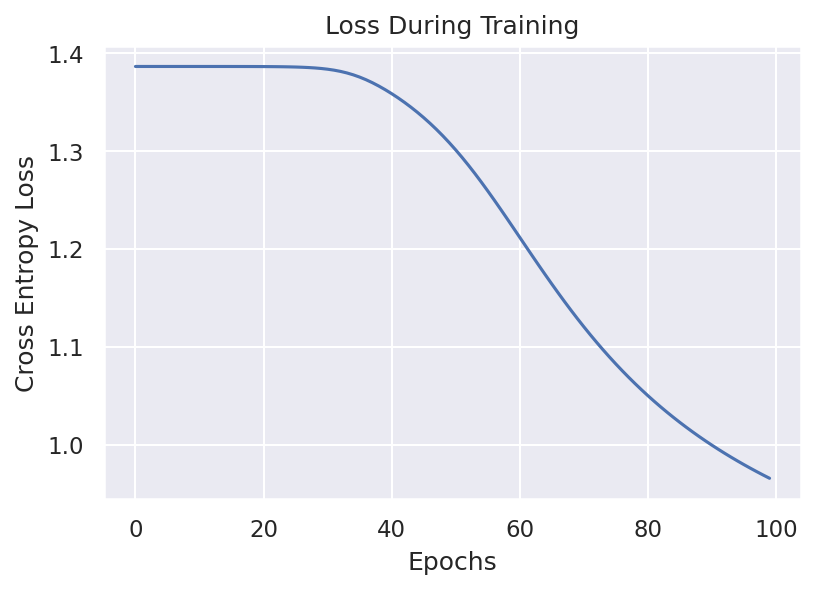

Train accuracy is 0.576
Test accuracy is 0.564
Min loss is 0.9656708313004085


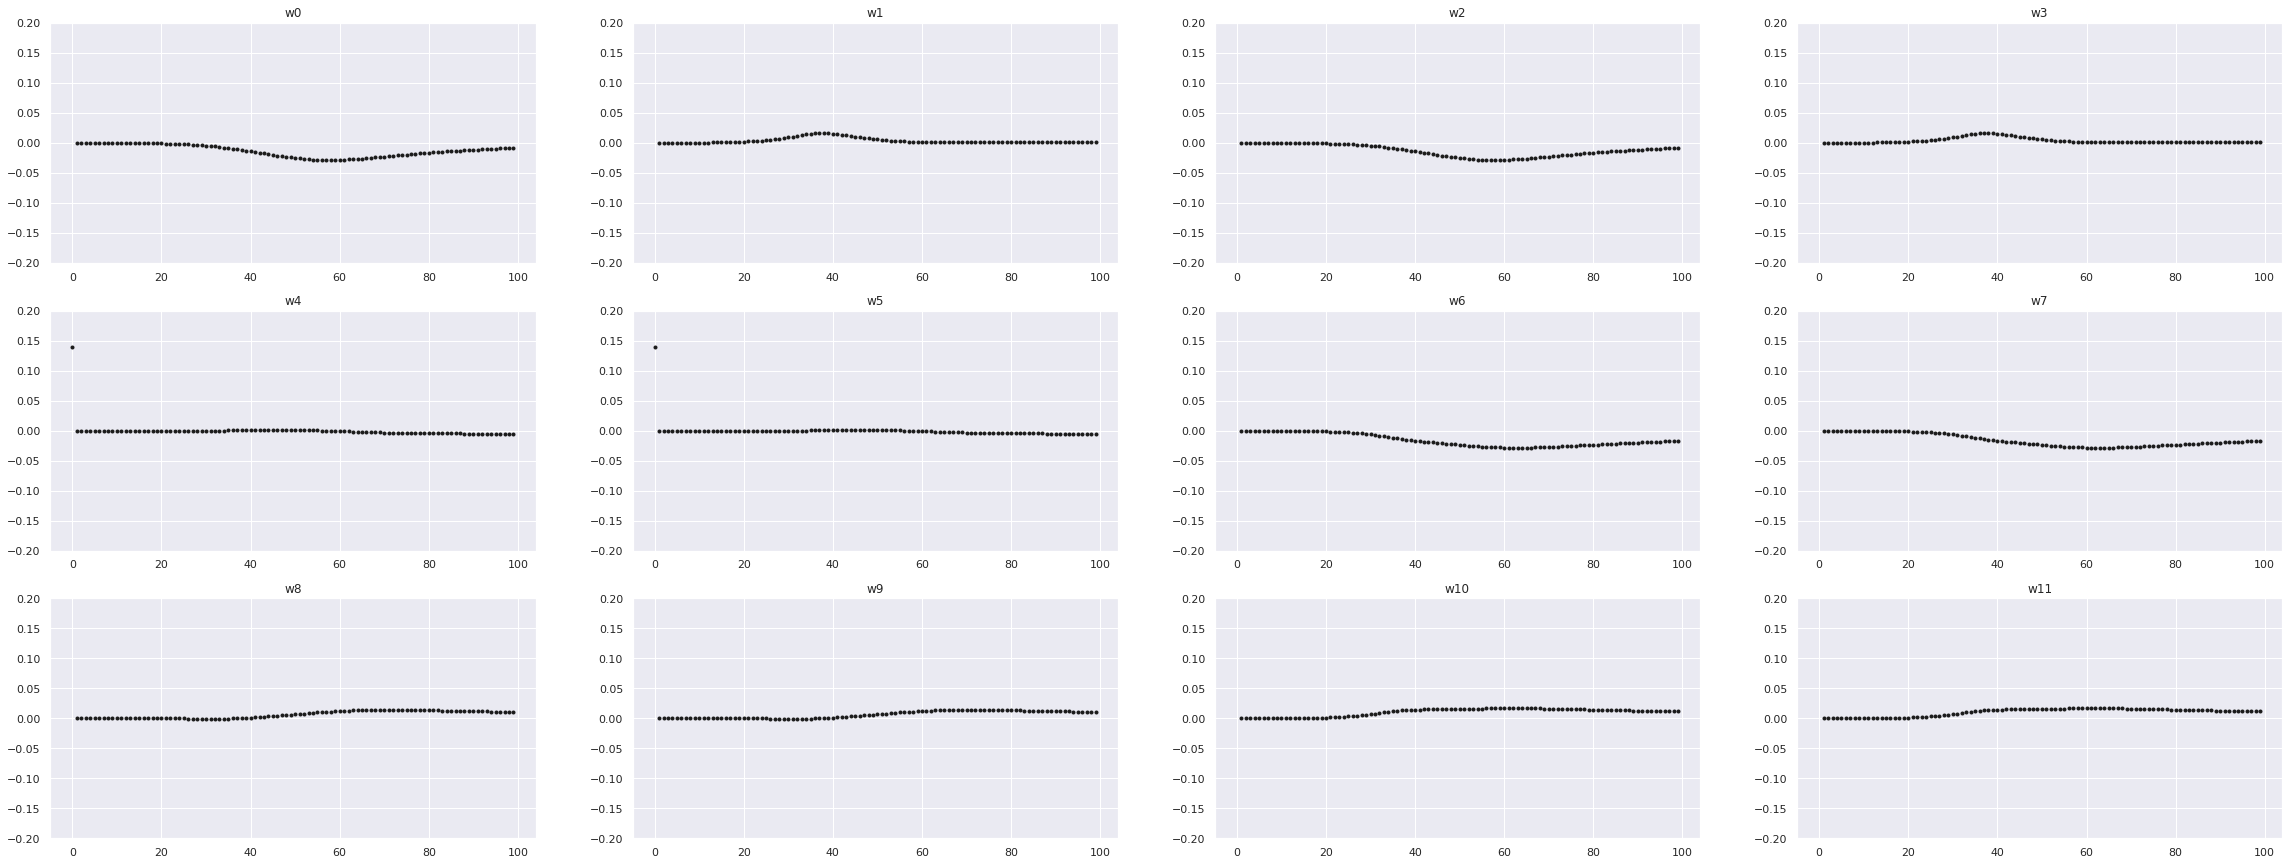

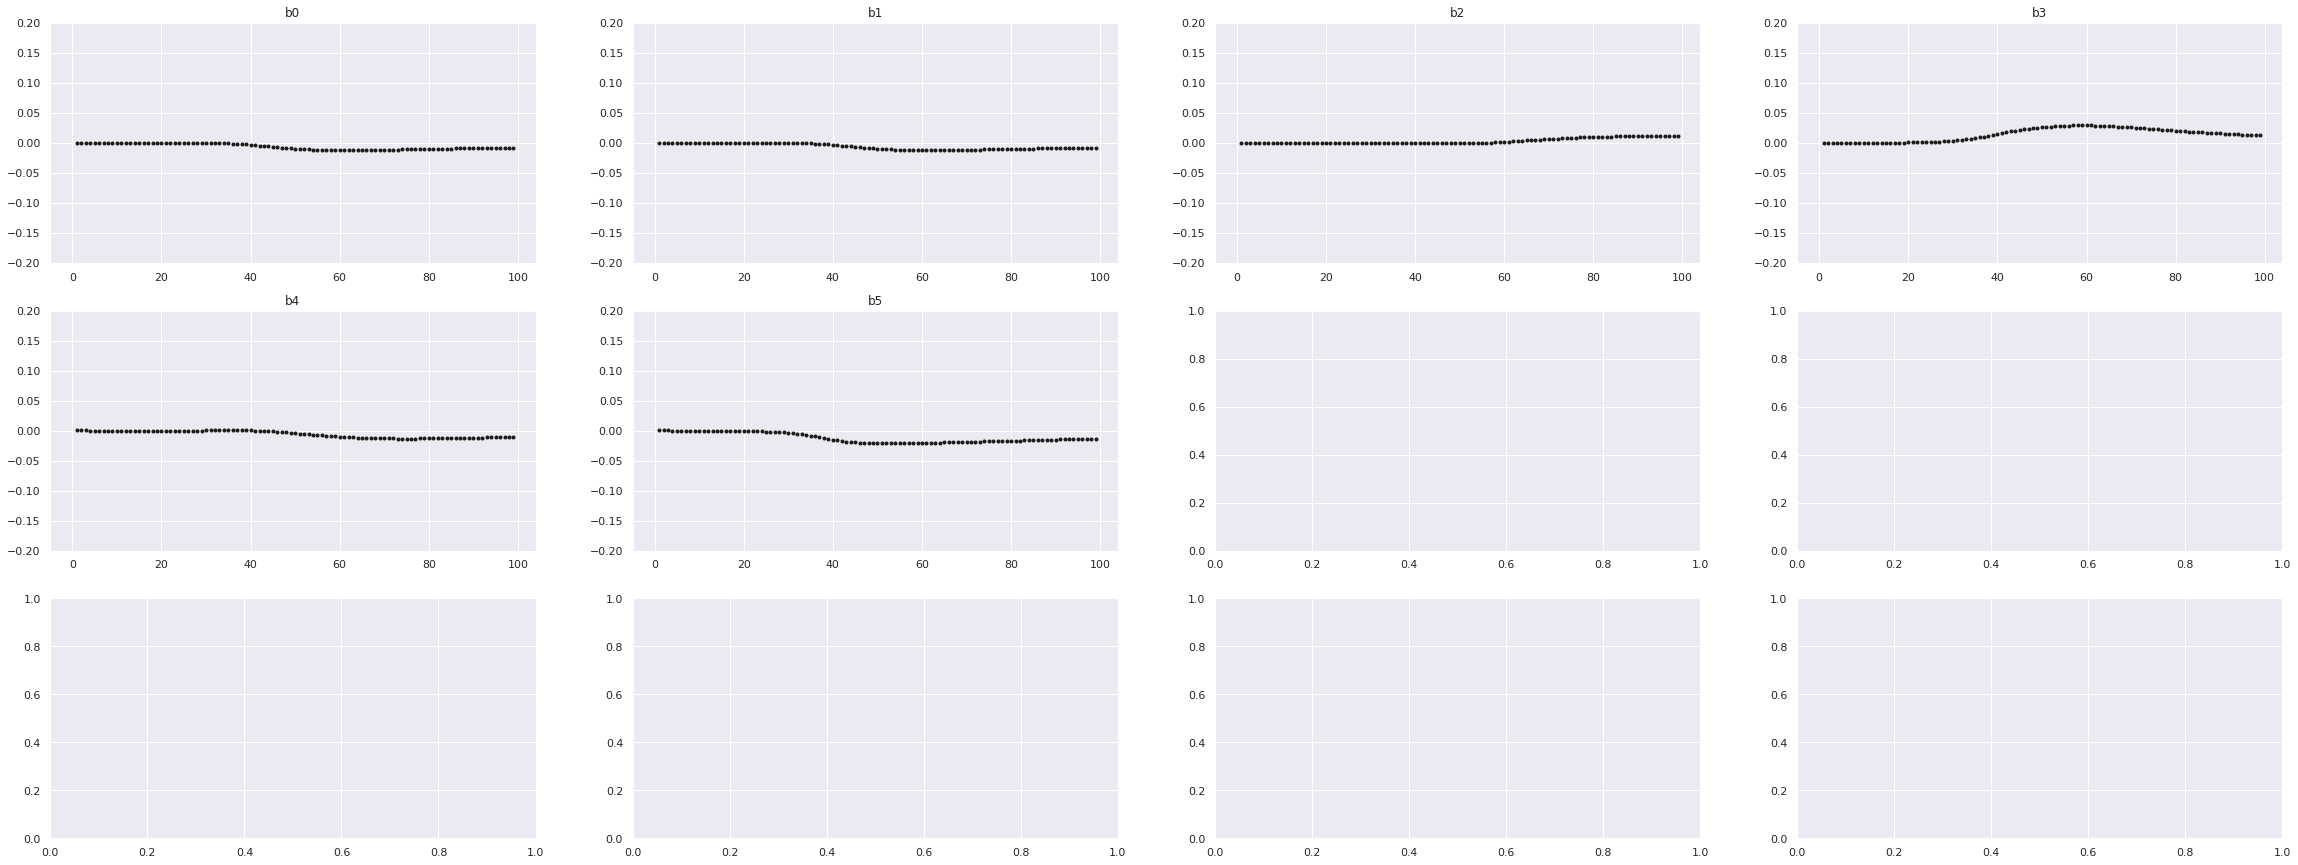

Activation function: Sigmoid  Intialisation method: Xavier


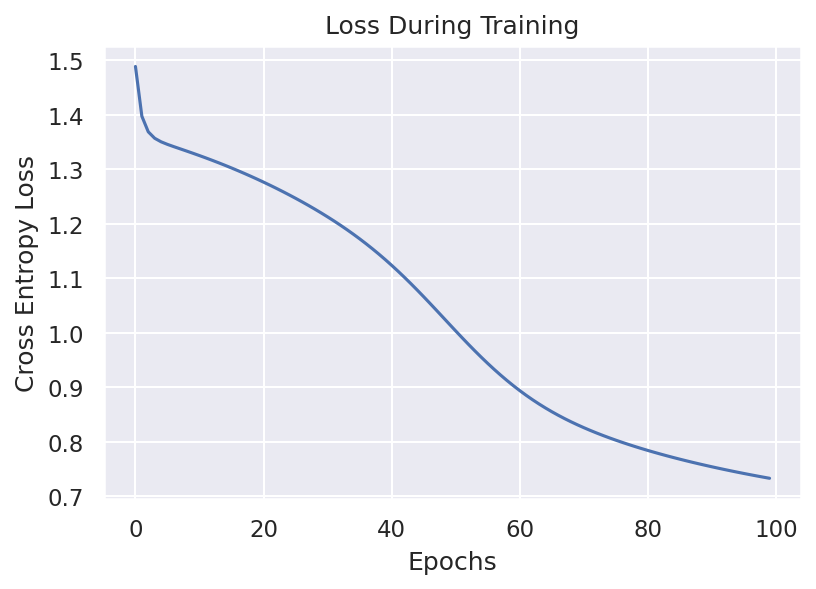

Train accuracy is 0.7
Test accuracy is 0.684
Min loss is 0.7332095846405163


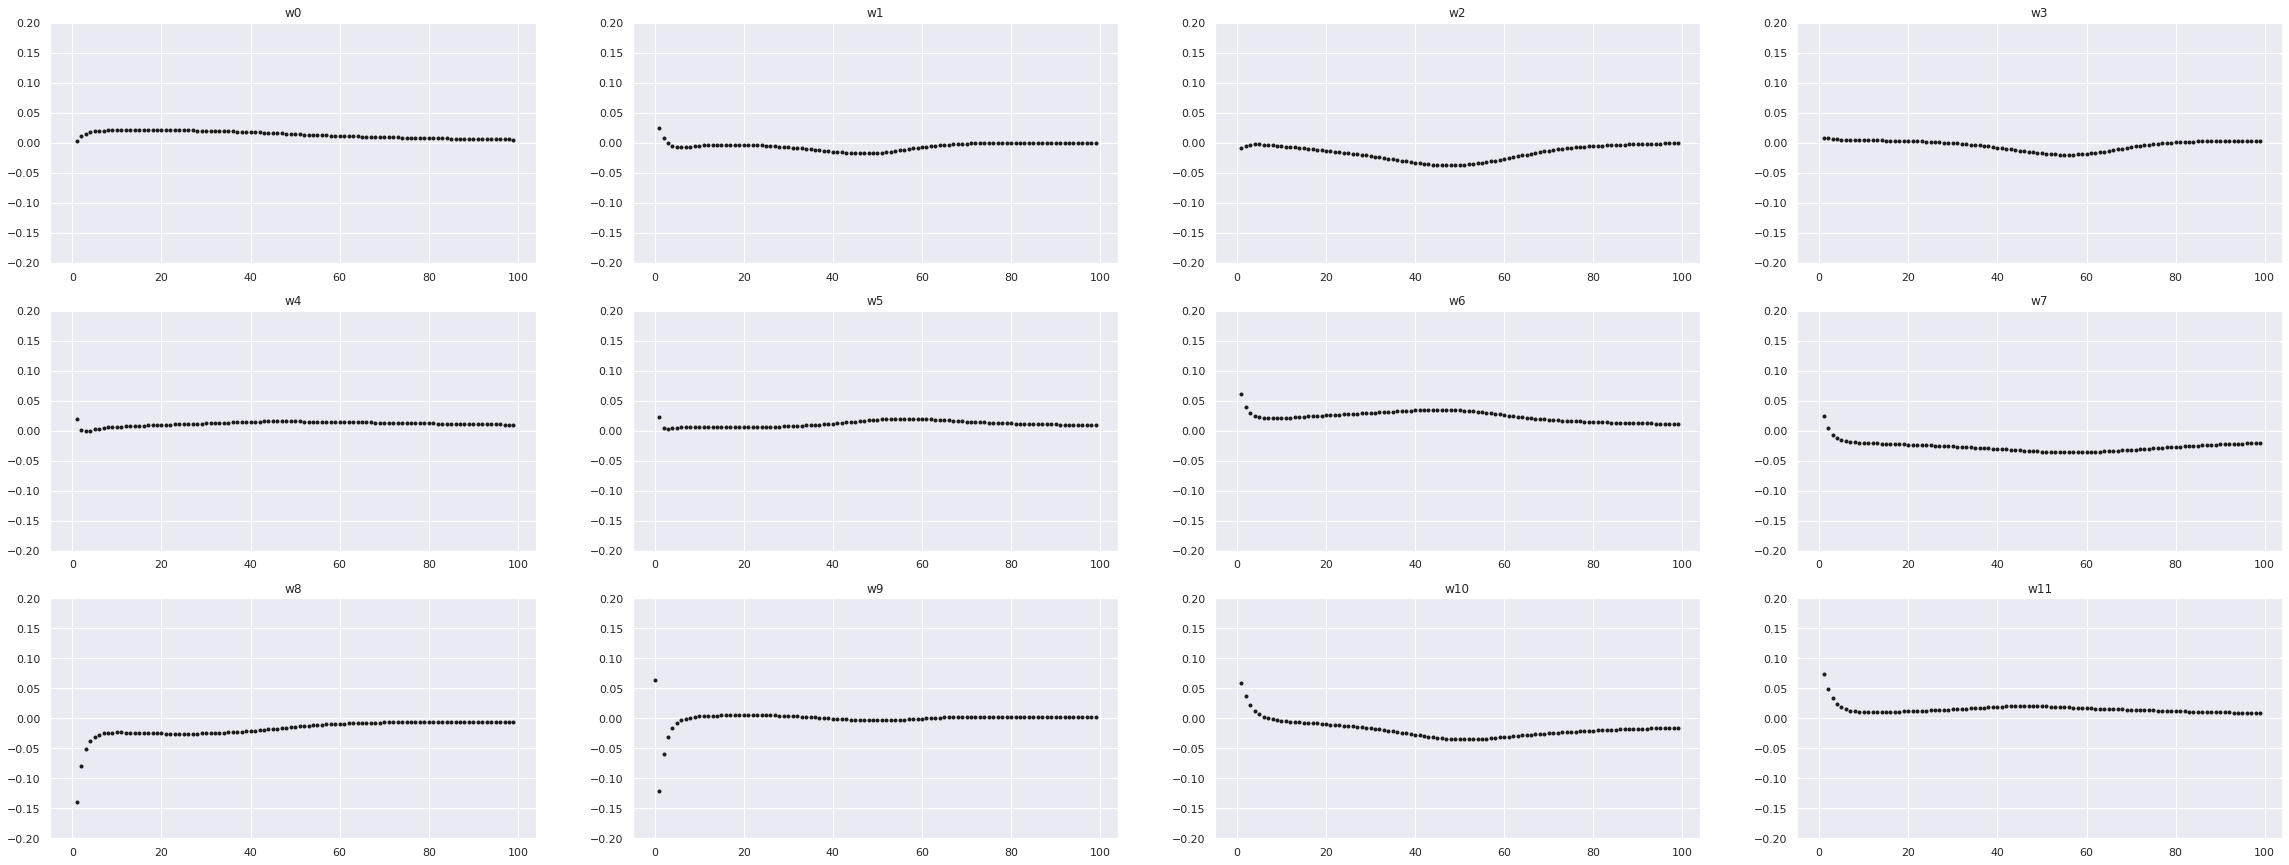

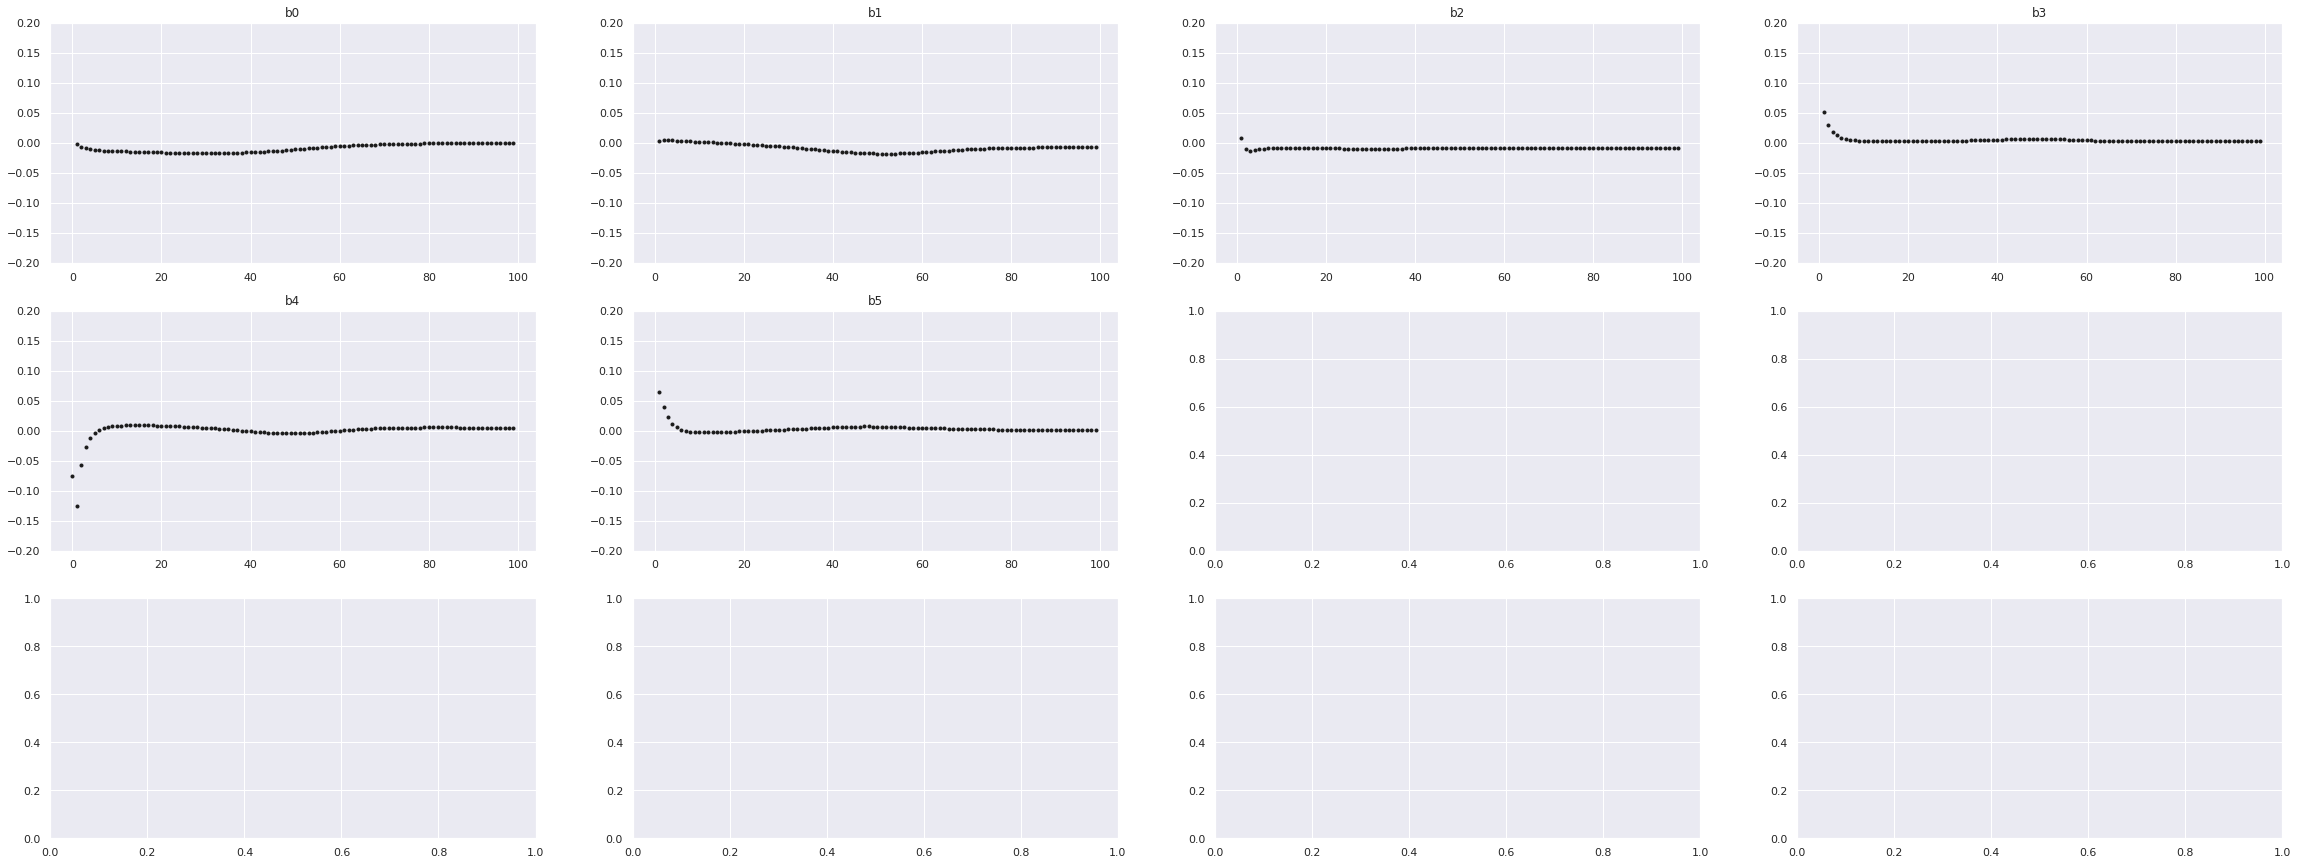

Activation function: Sigmoid  Intialisation method: He


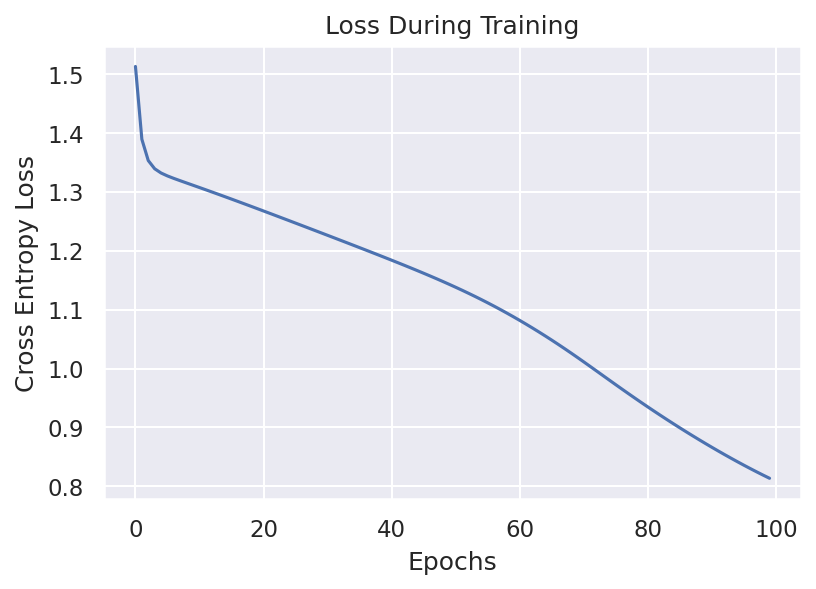

Train accuracy is 0.652
Test accuracy is 0.628
Min loss is 0.8137277751228549


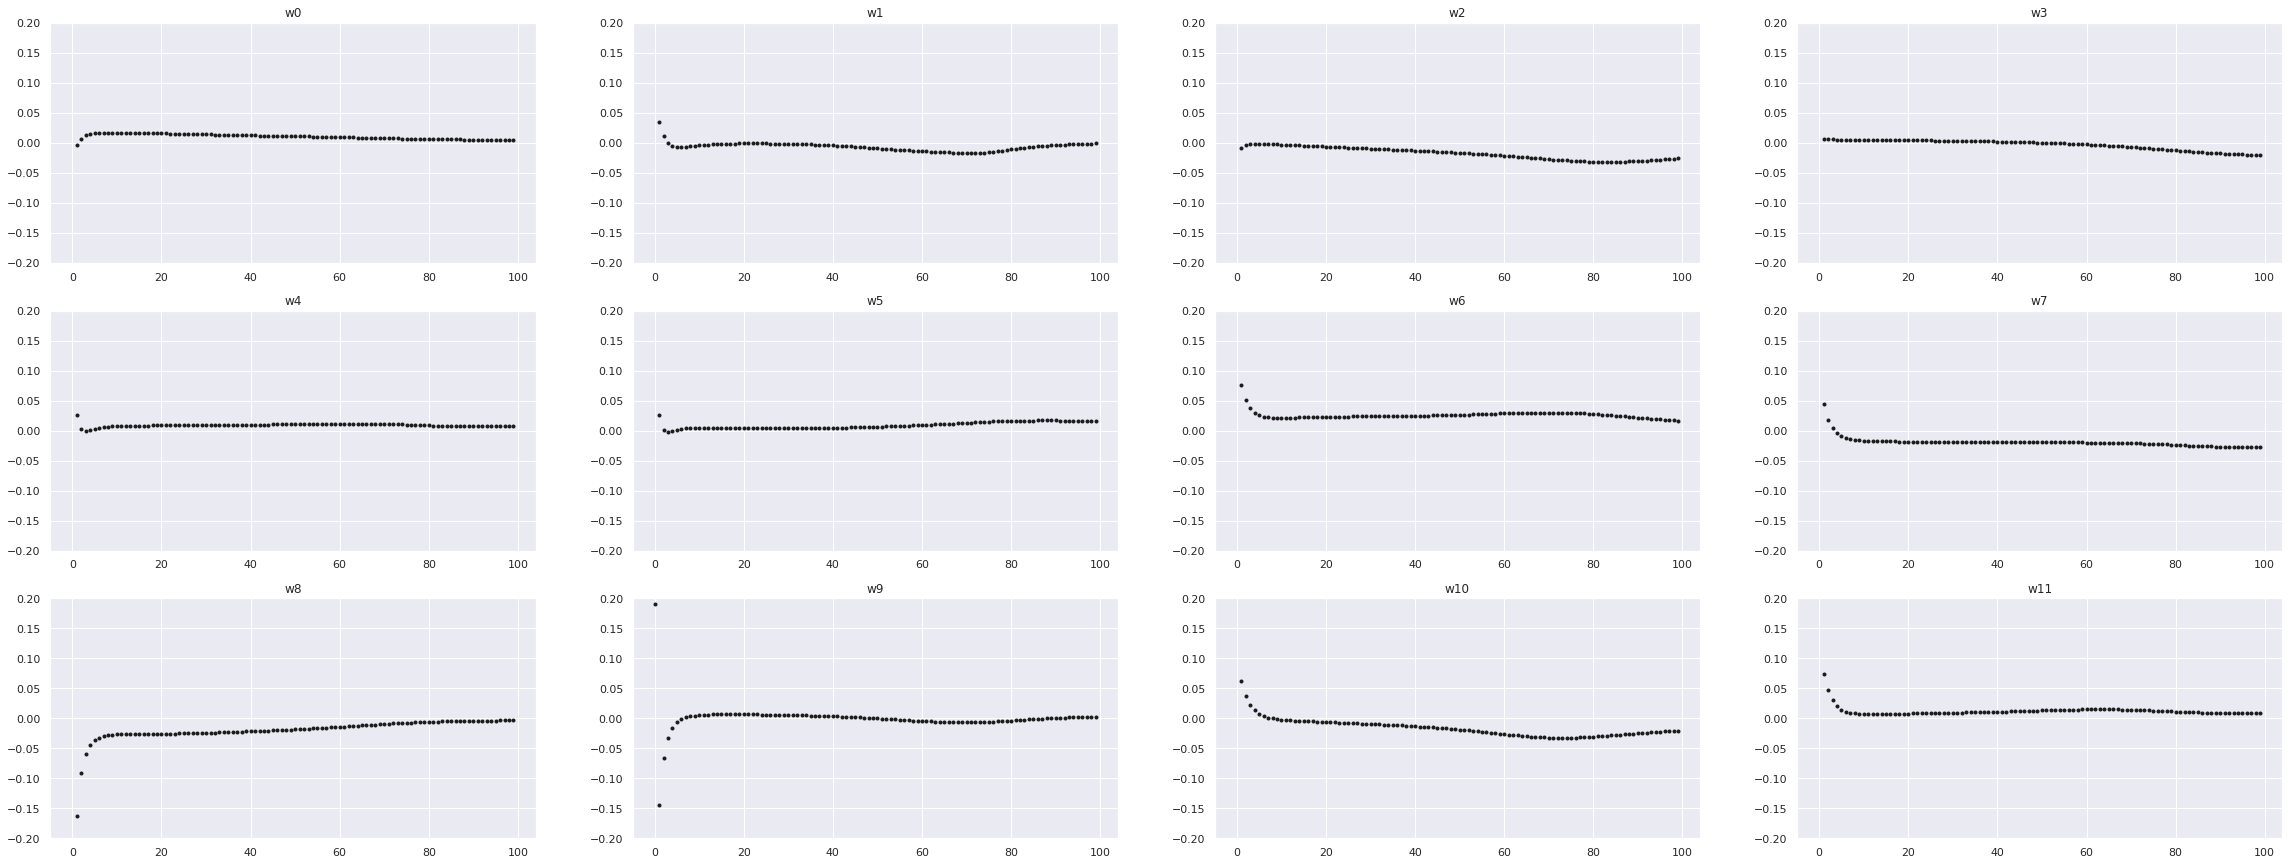

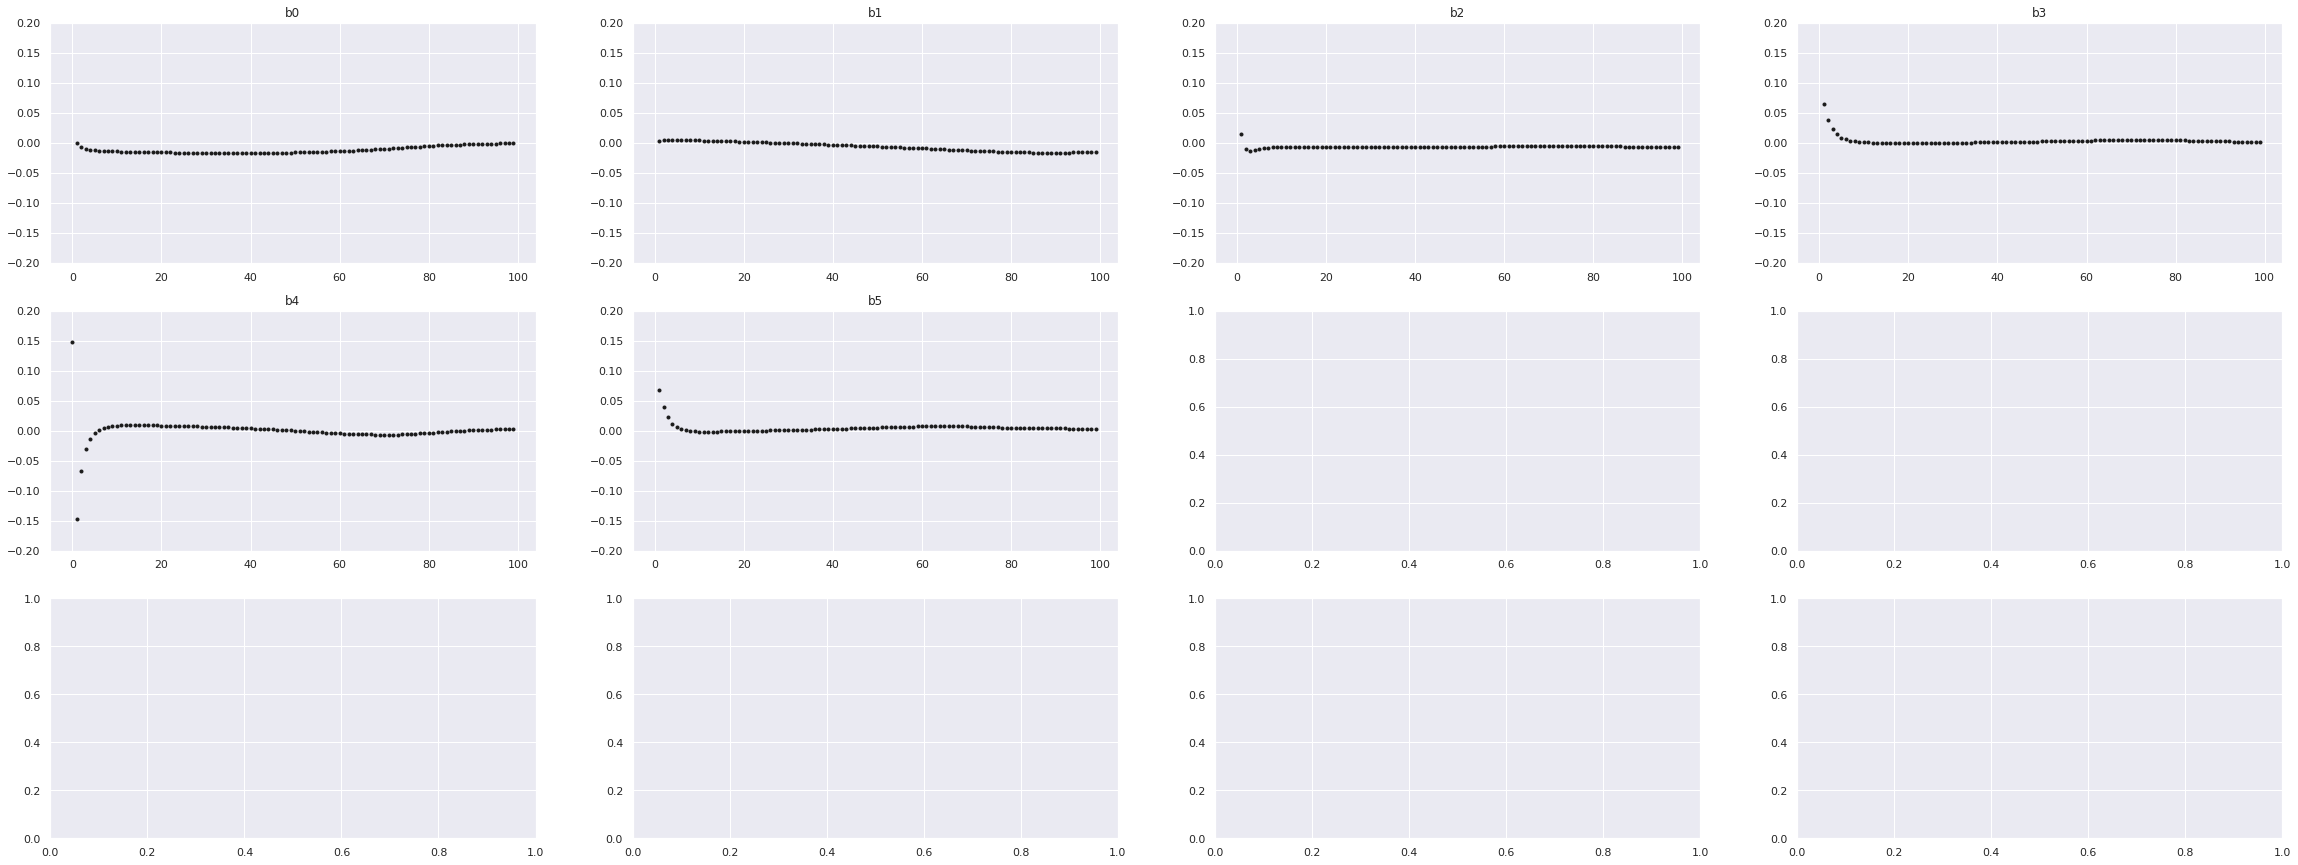

Activation function: tanh  Intialisation method: Random


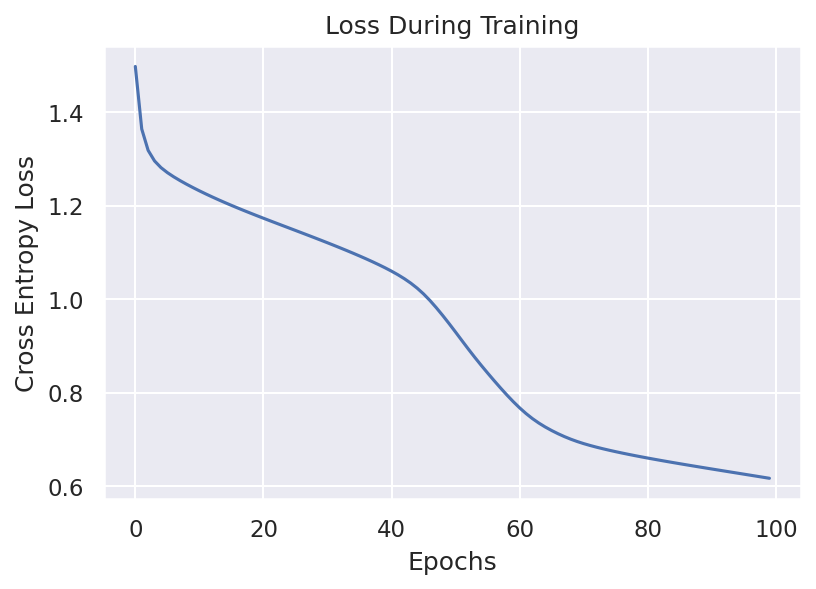

Train accuracy is 0.7253333333333334
Test accuracy is 0.724
Min loss is 0.6164172909666081


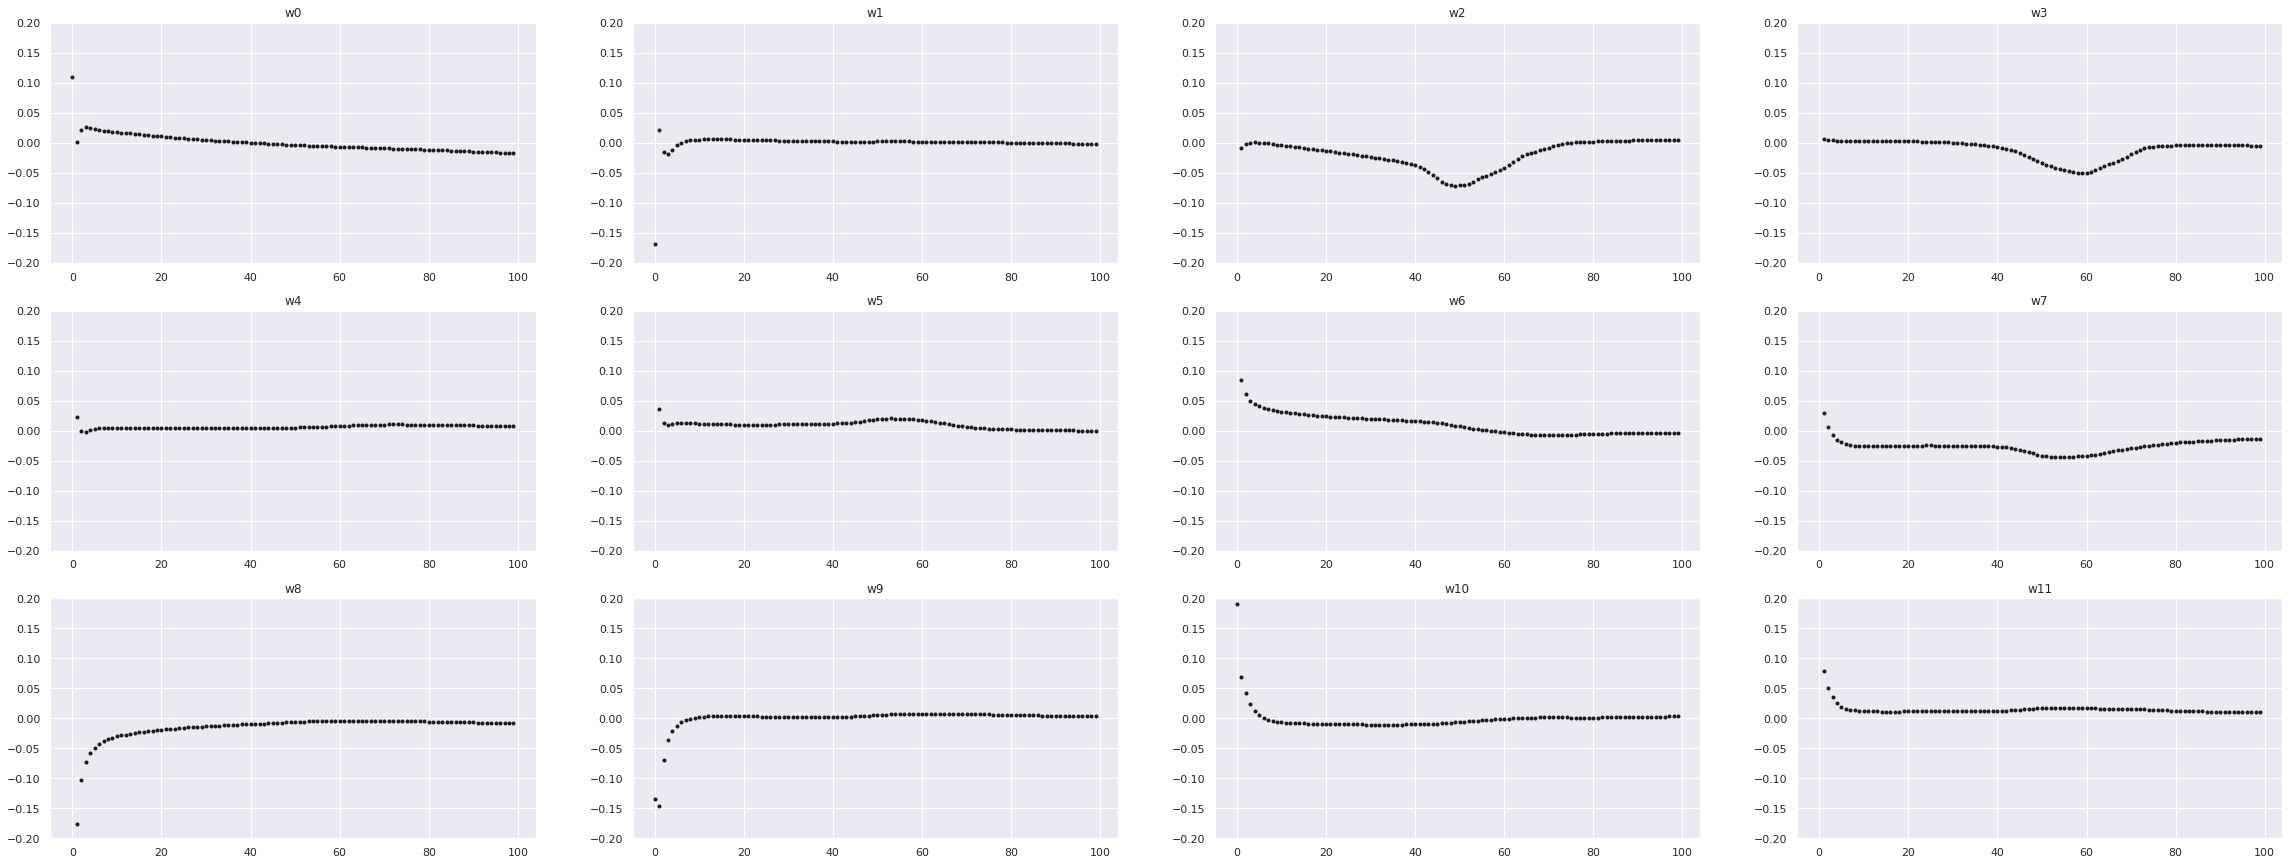

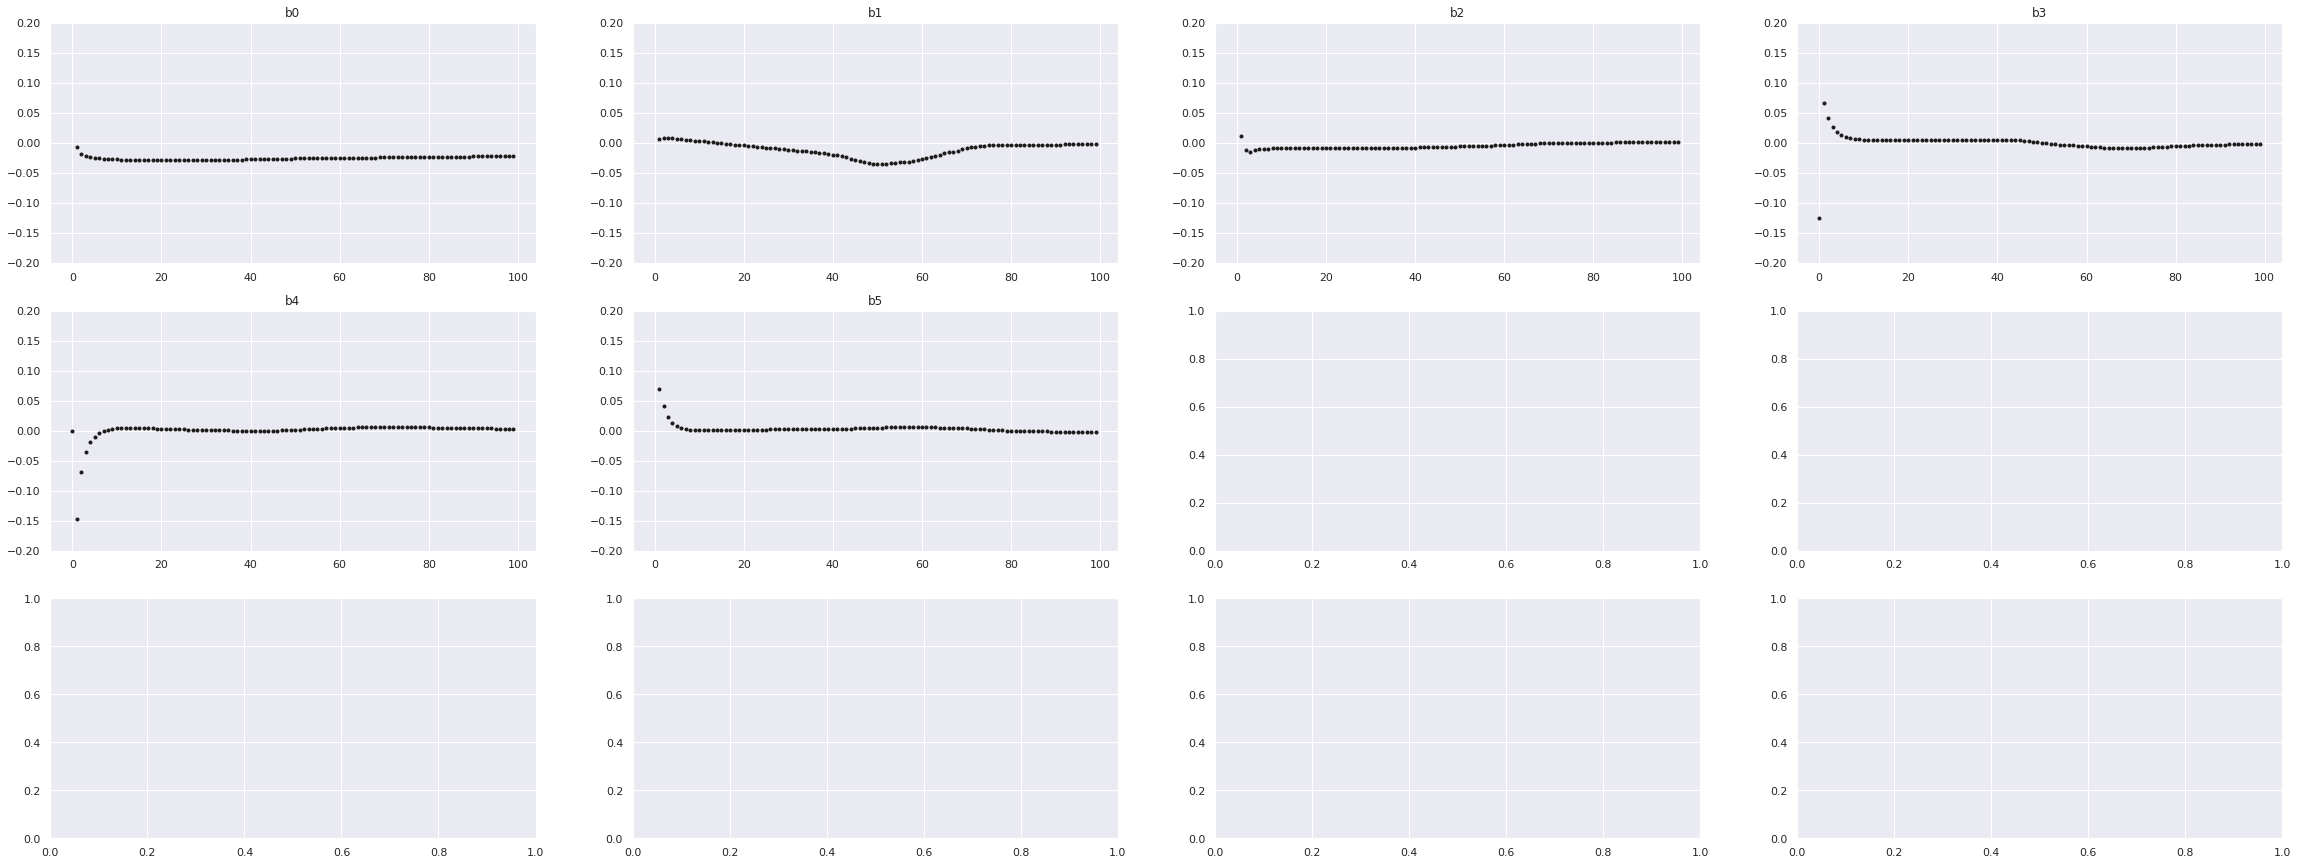

Activation function: tanh  Intialisation method: Zeros


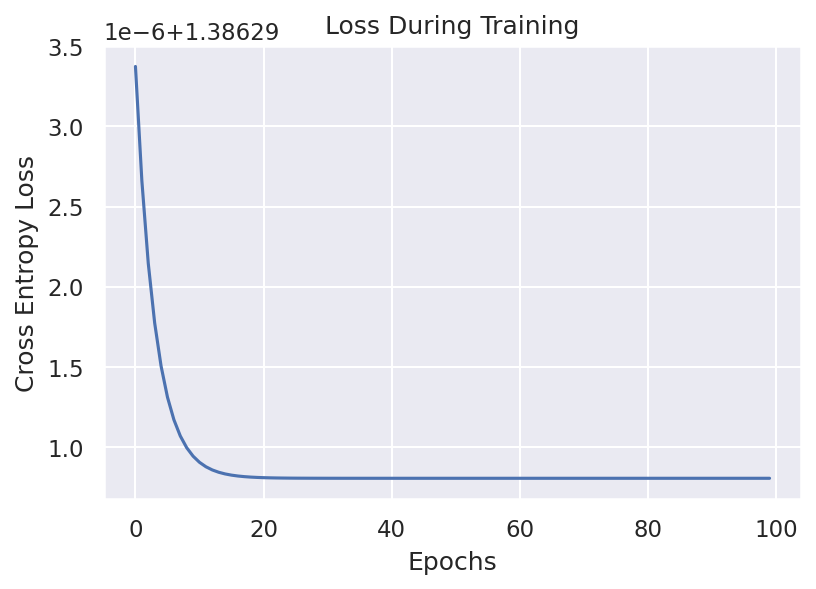

Train accuracy is 0.25066666666666665
Test accuracy is 0.248
Min loss is 1.3862908055601206


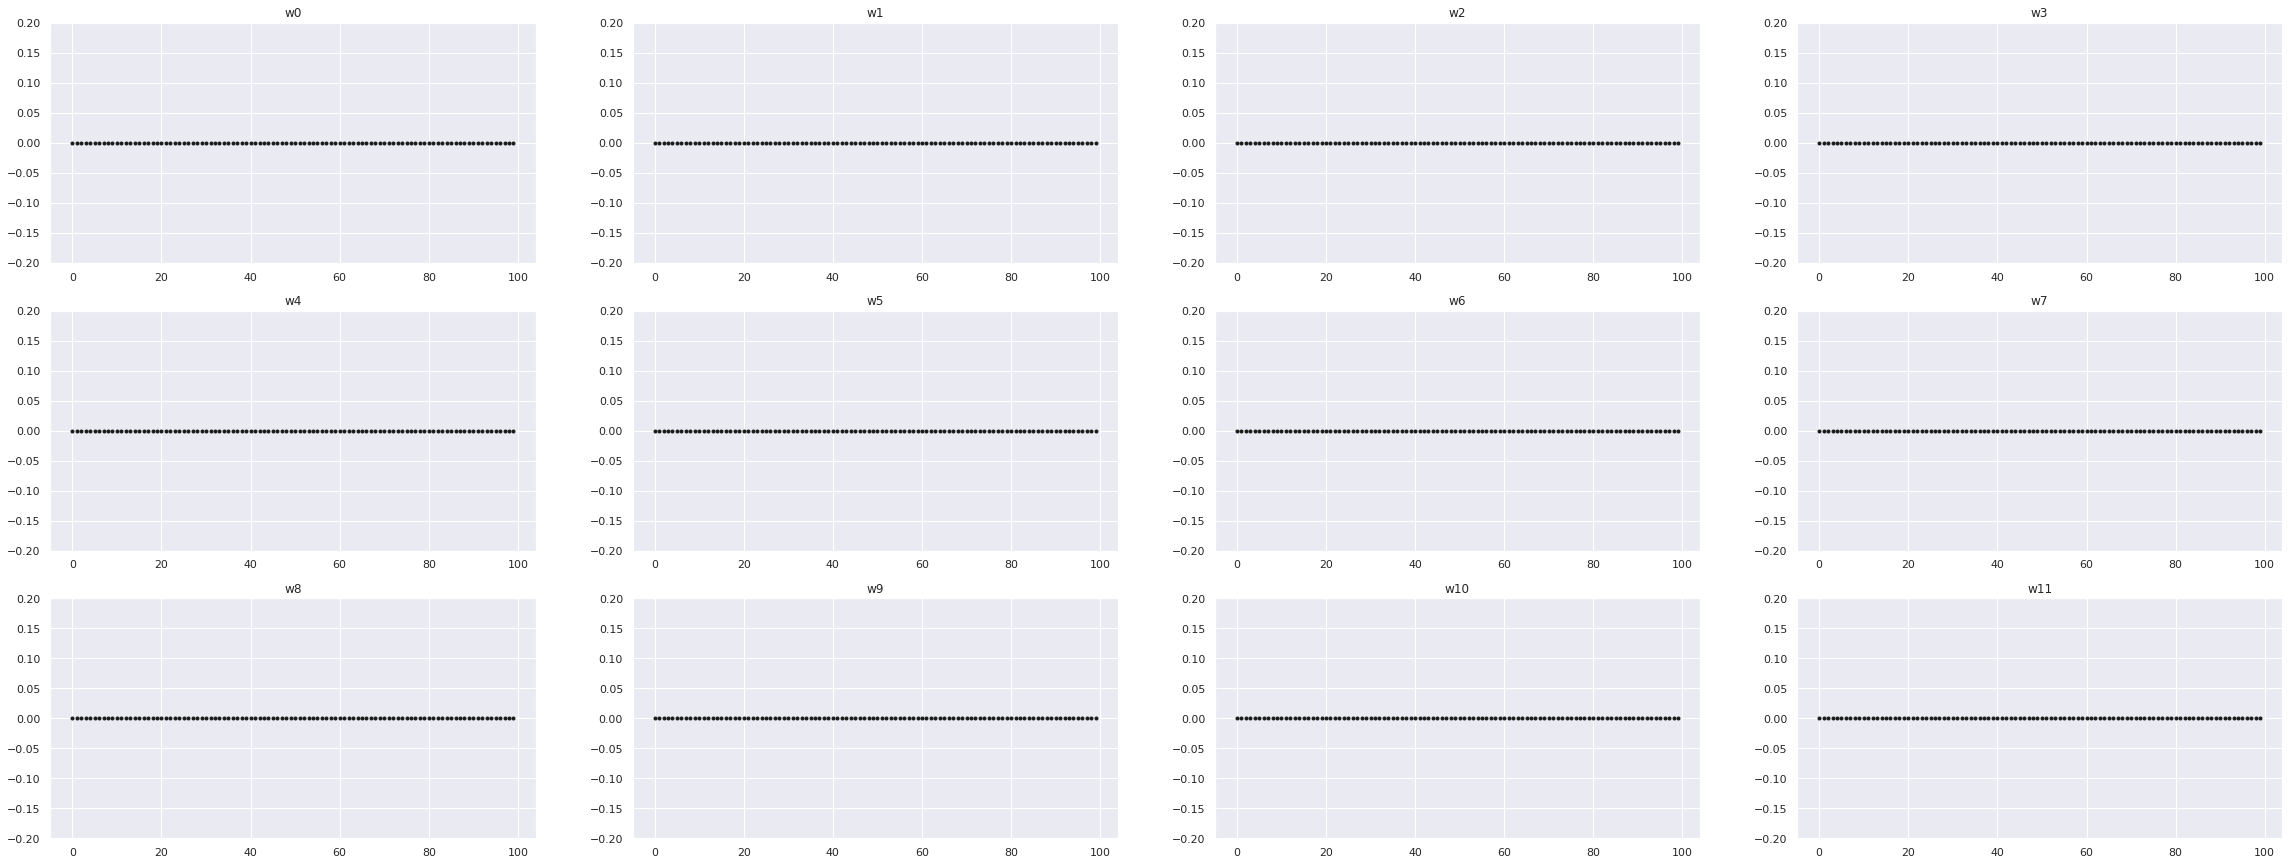

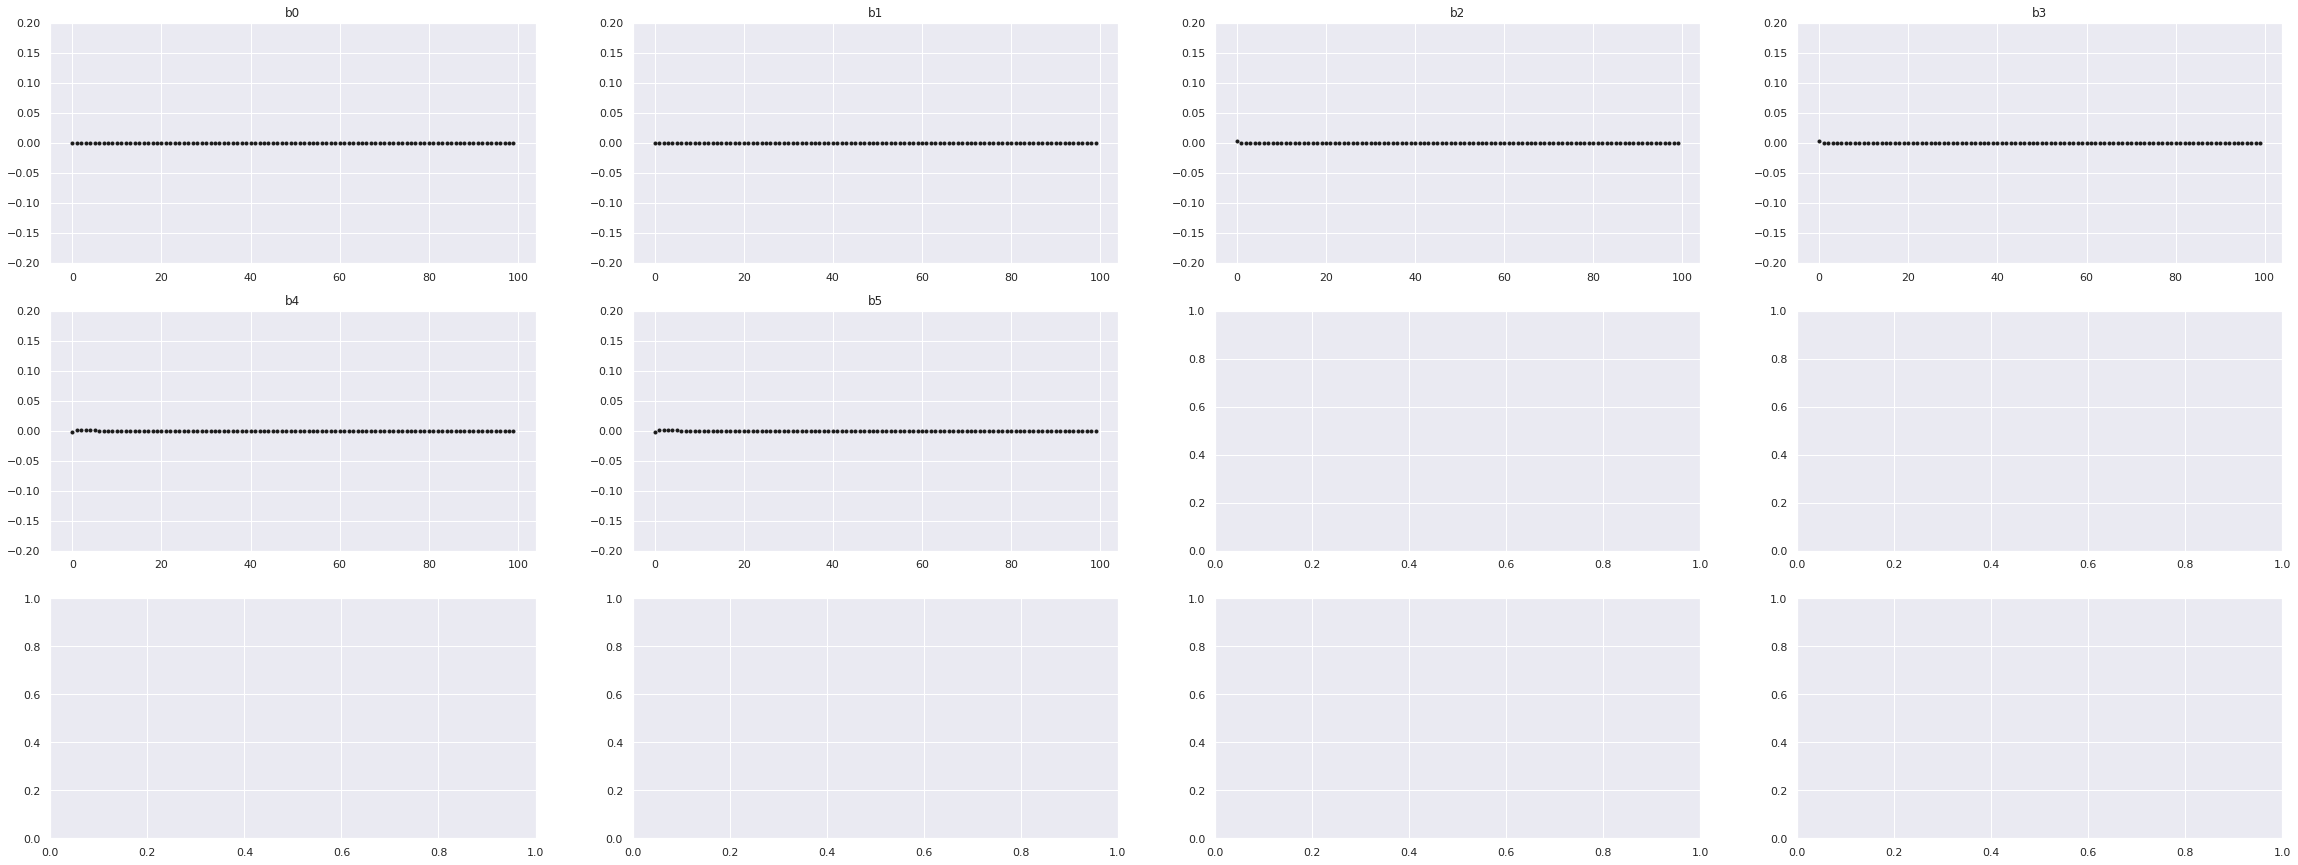

Activation function: tanh  Intialisation method: Xavier


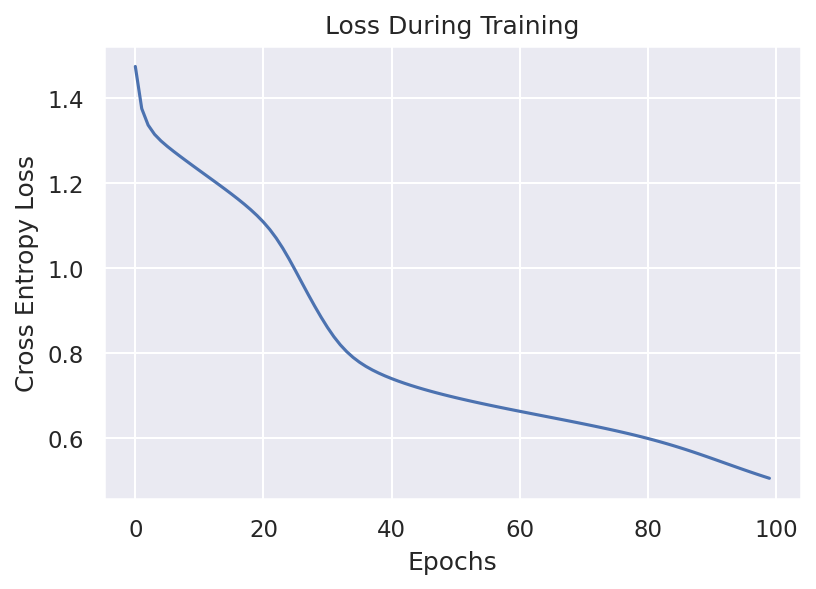

Train accuracy is 0.852
Test accuracy is 0.864
Min loss is 0.5050609734010572


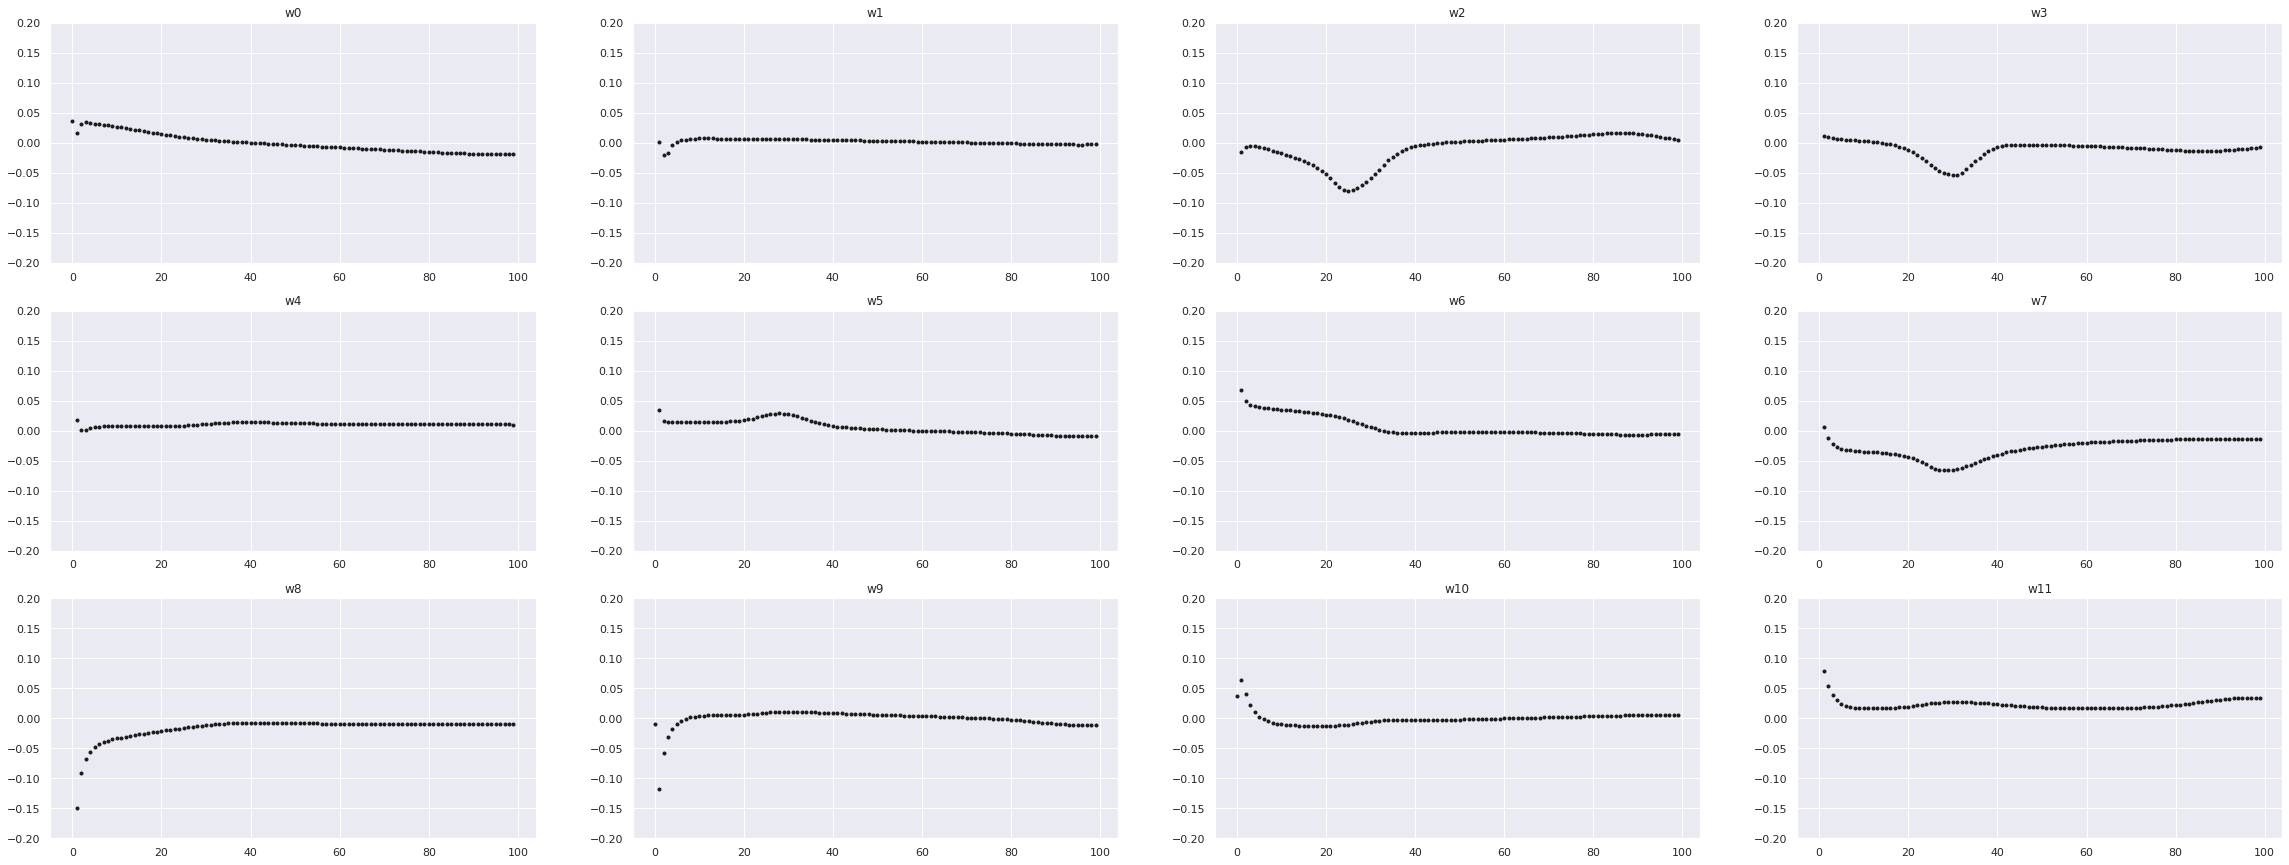

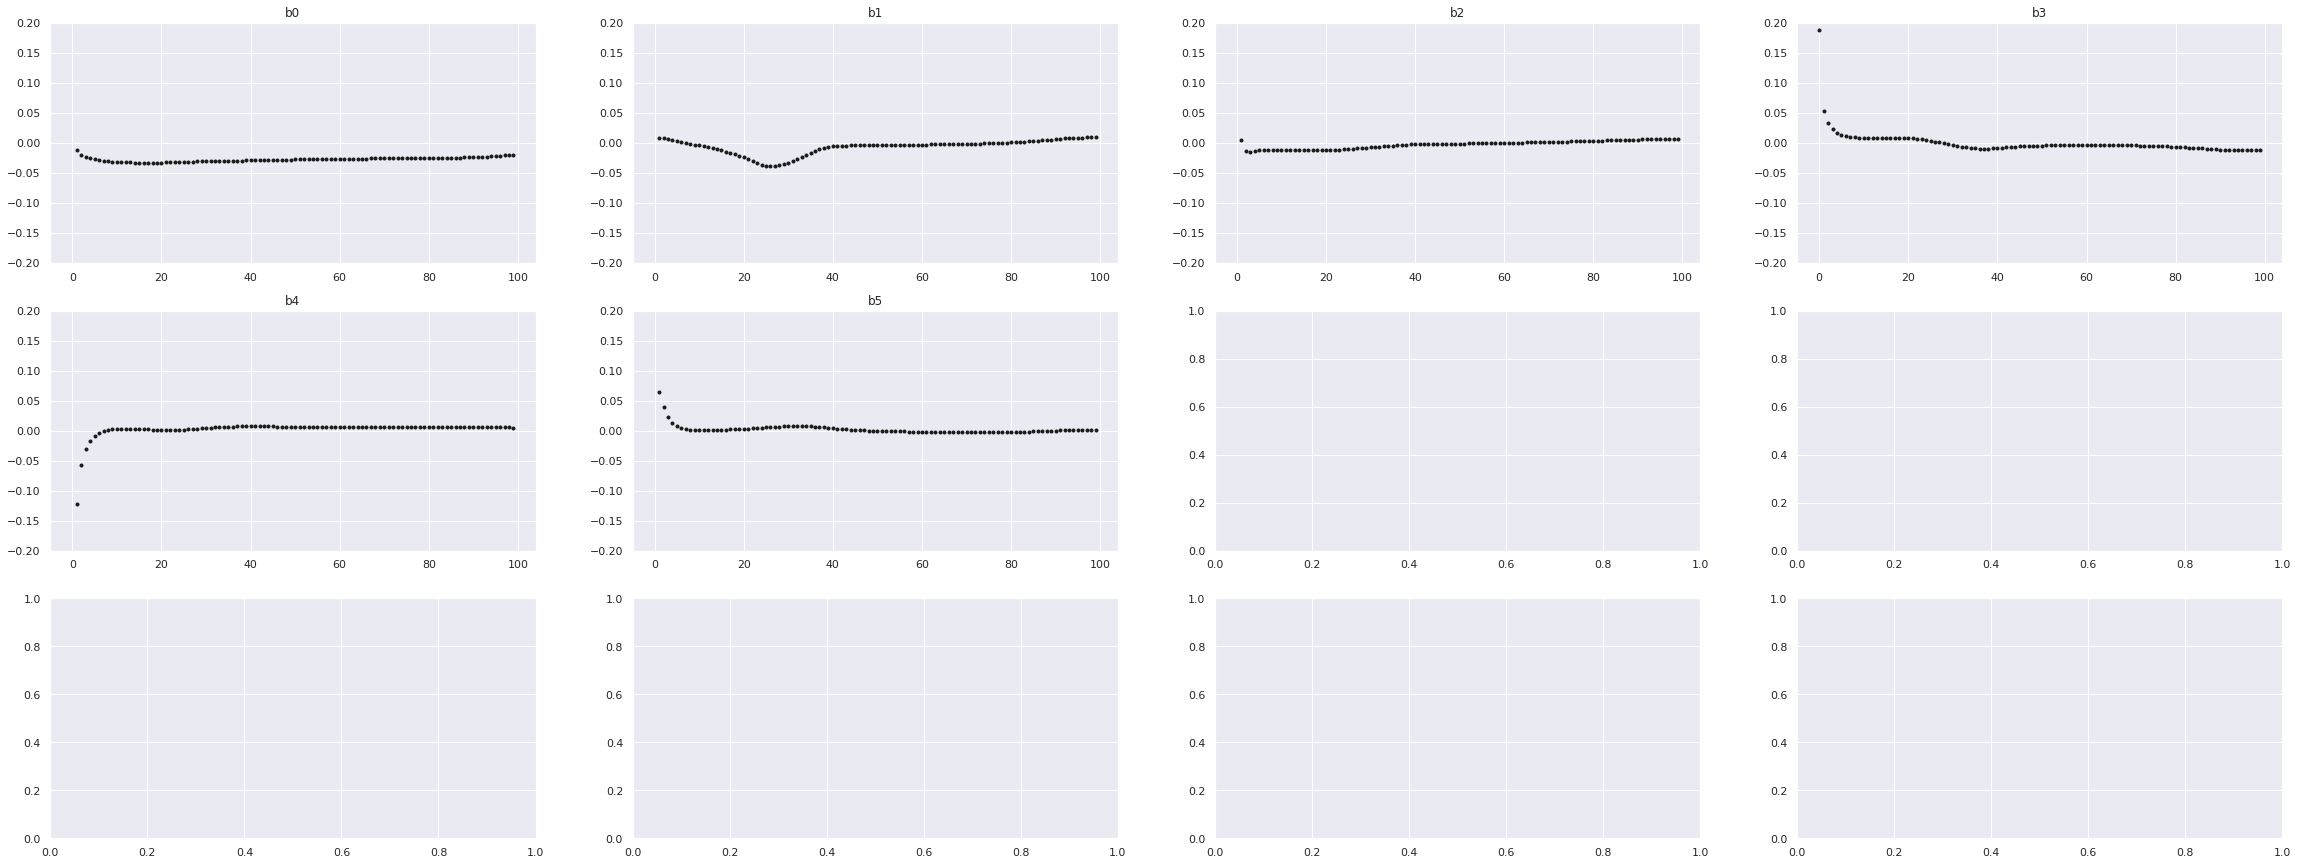

Activation function: tanh  Intialisation method: He


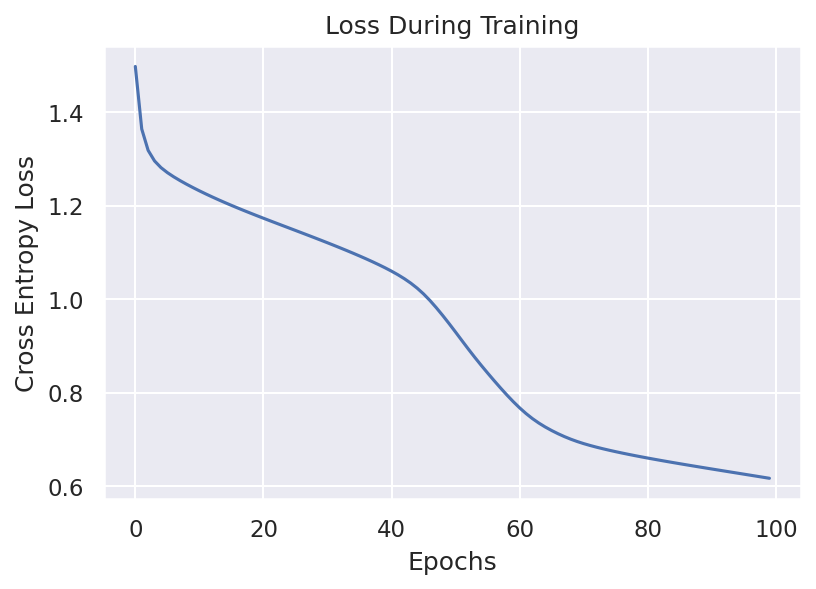

Train accuracy is 0.7253333333333334
Test accuracy is 0.724
Min loss is 0.6164172909666081


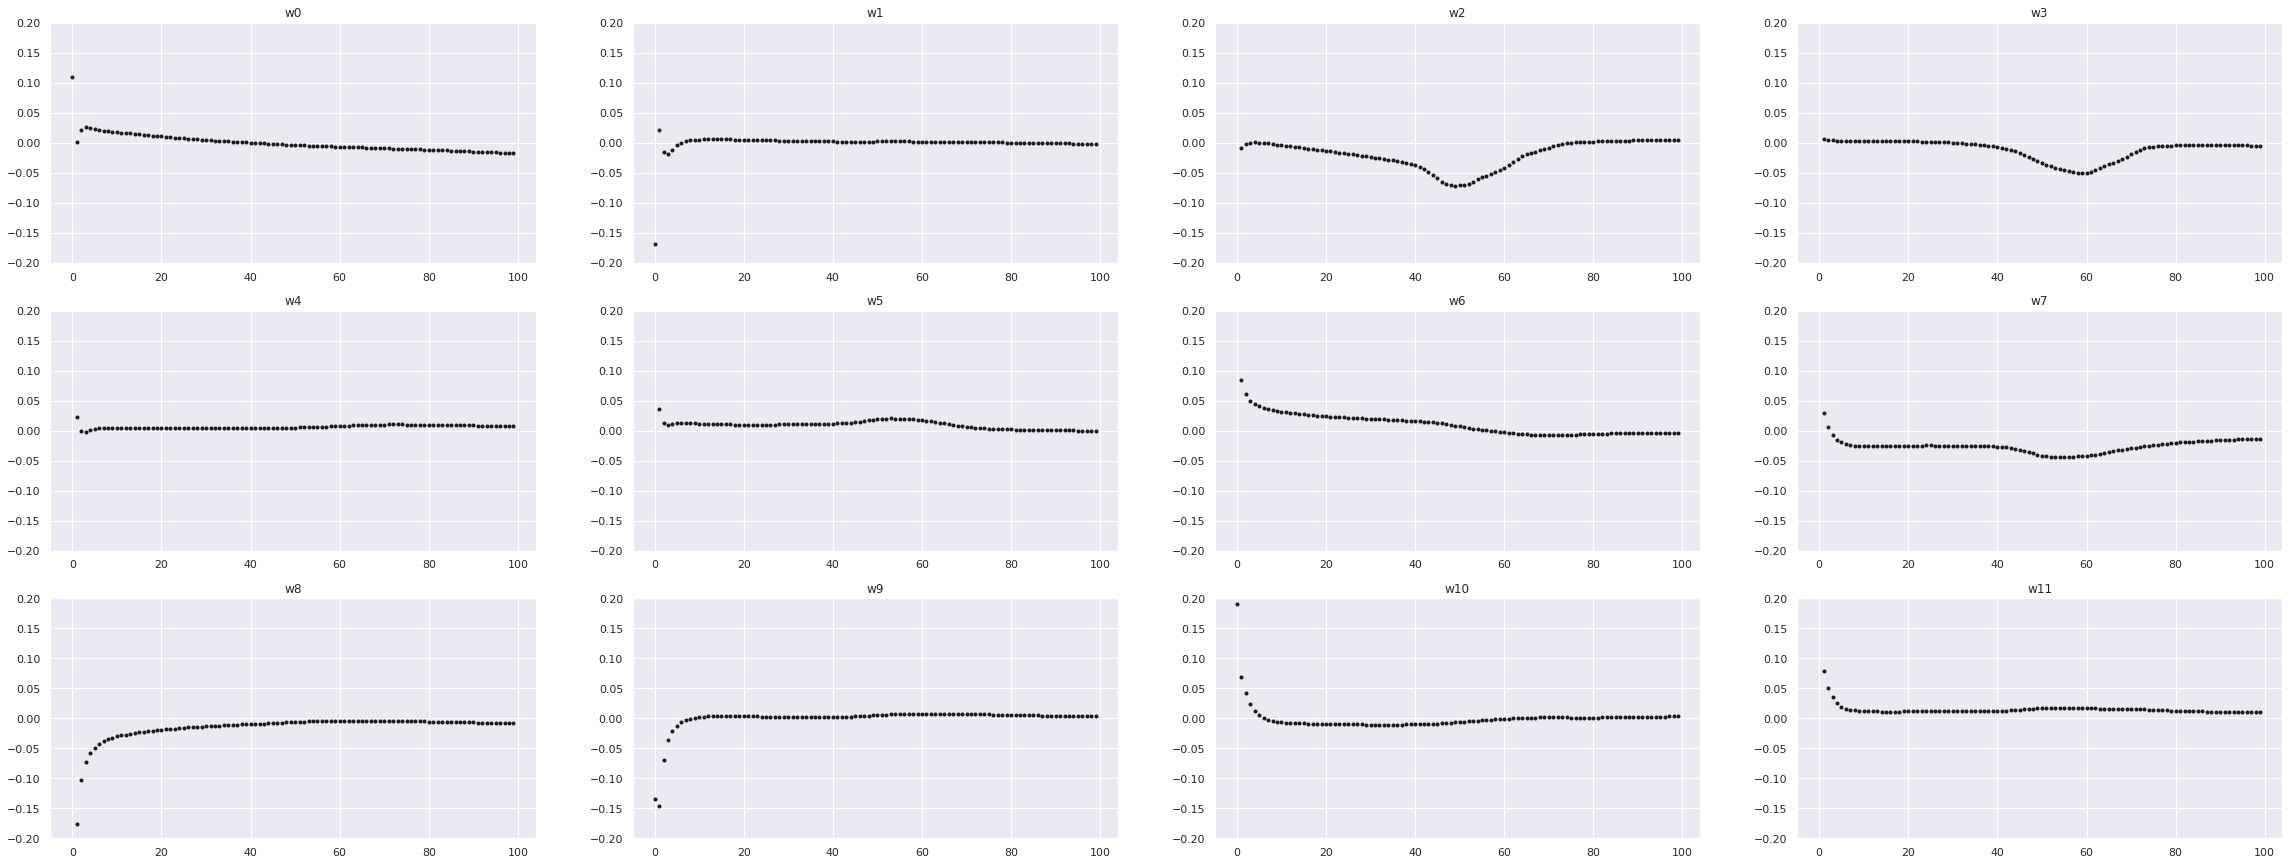

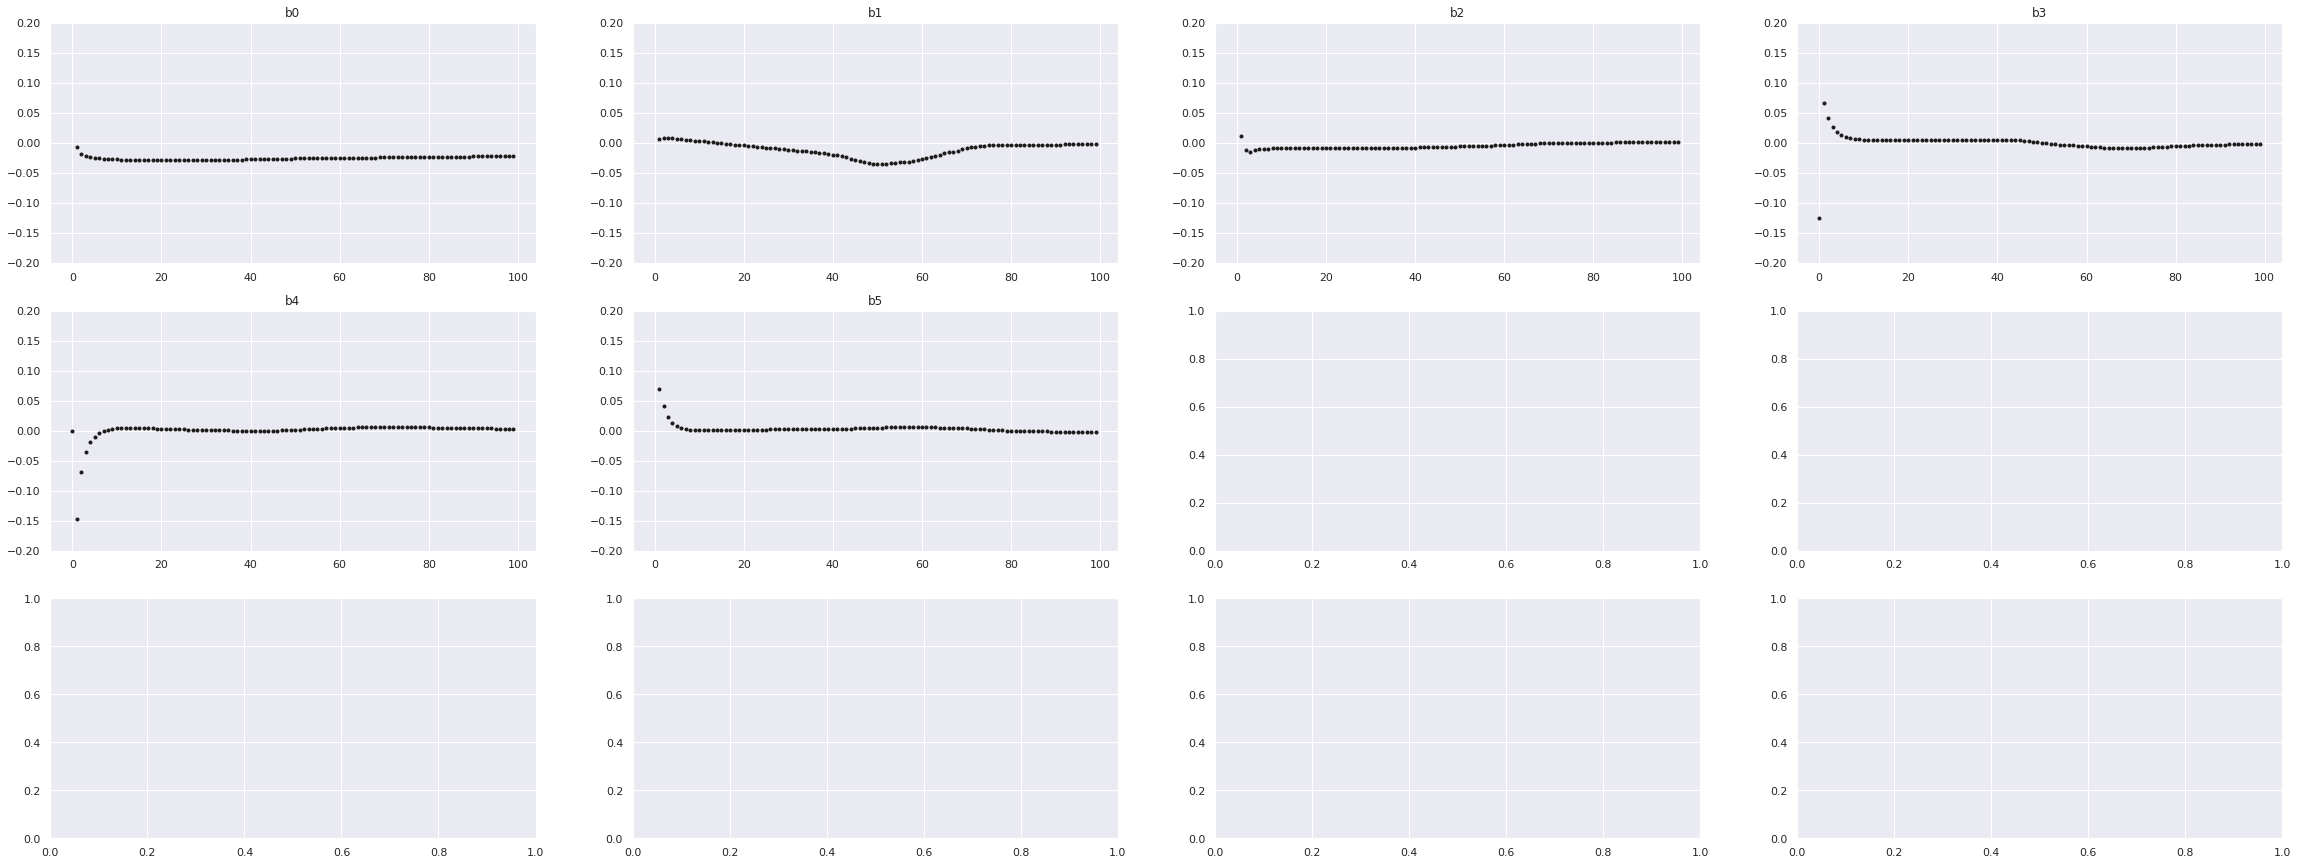

Activation function: ReLu  Intialisation method: Random


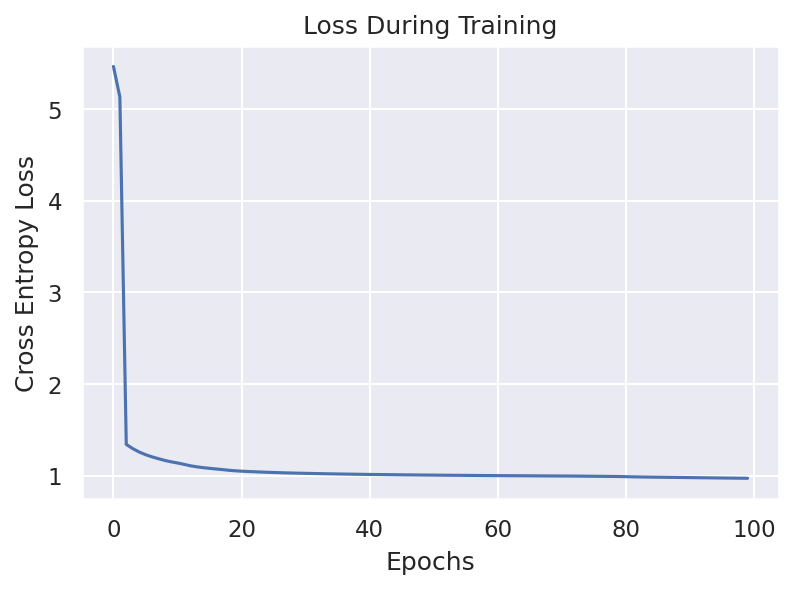

Train accuracy is 0.4693333333333333
Test accuracy is 0.484
Min loss is 0.9709603168969


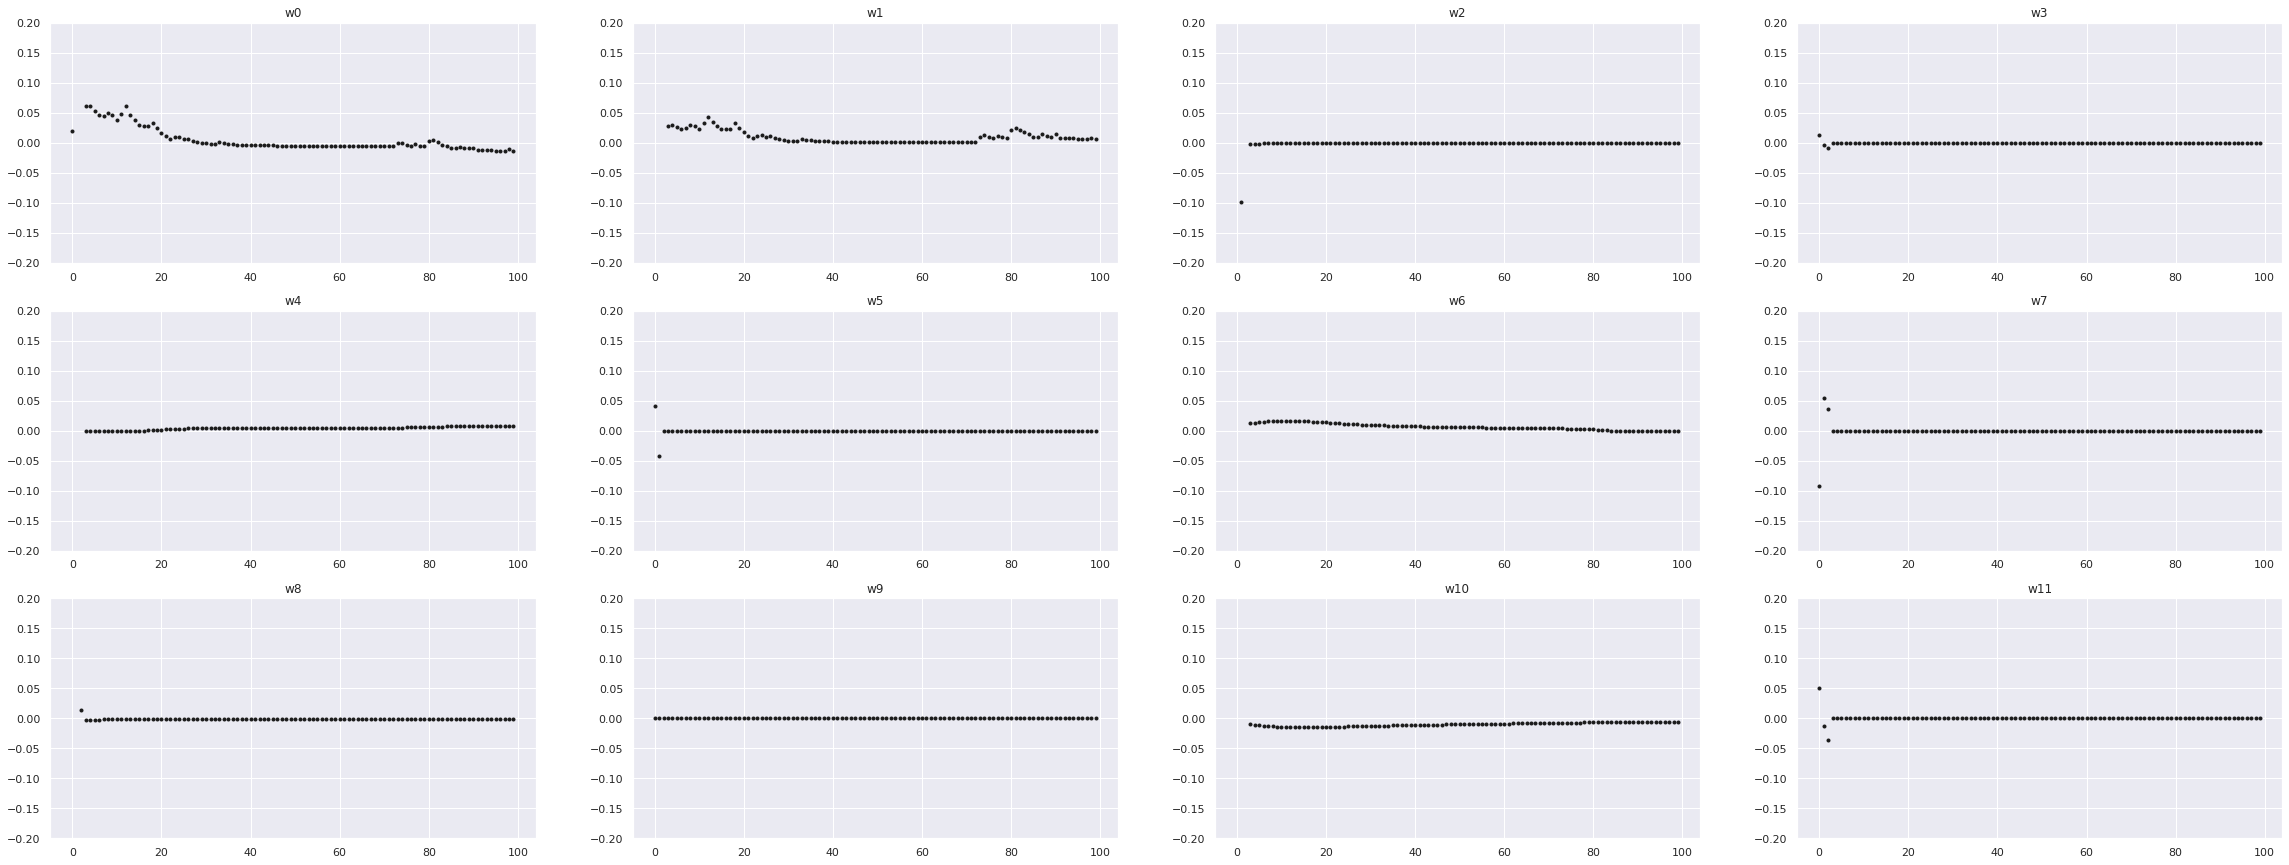

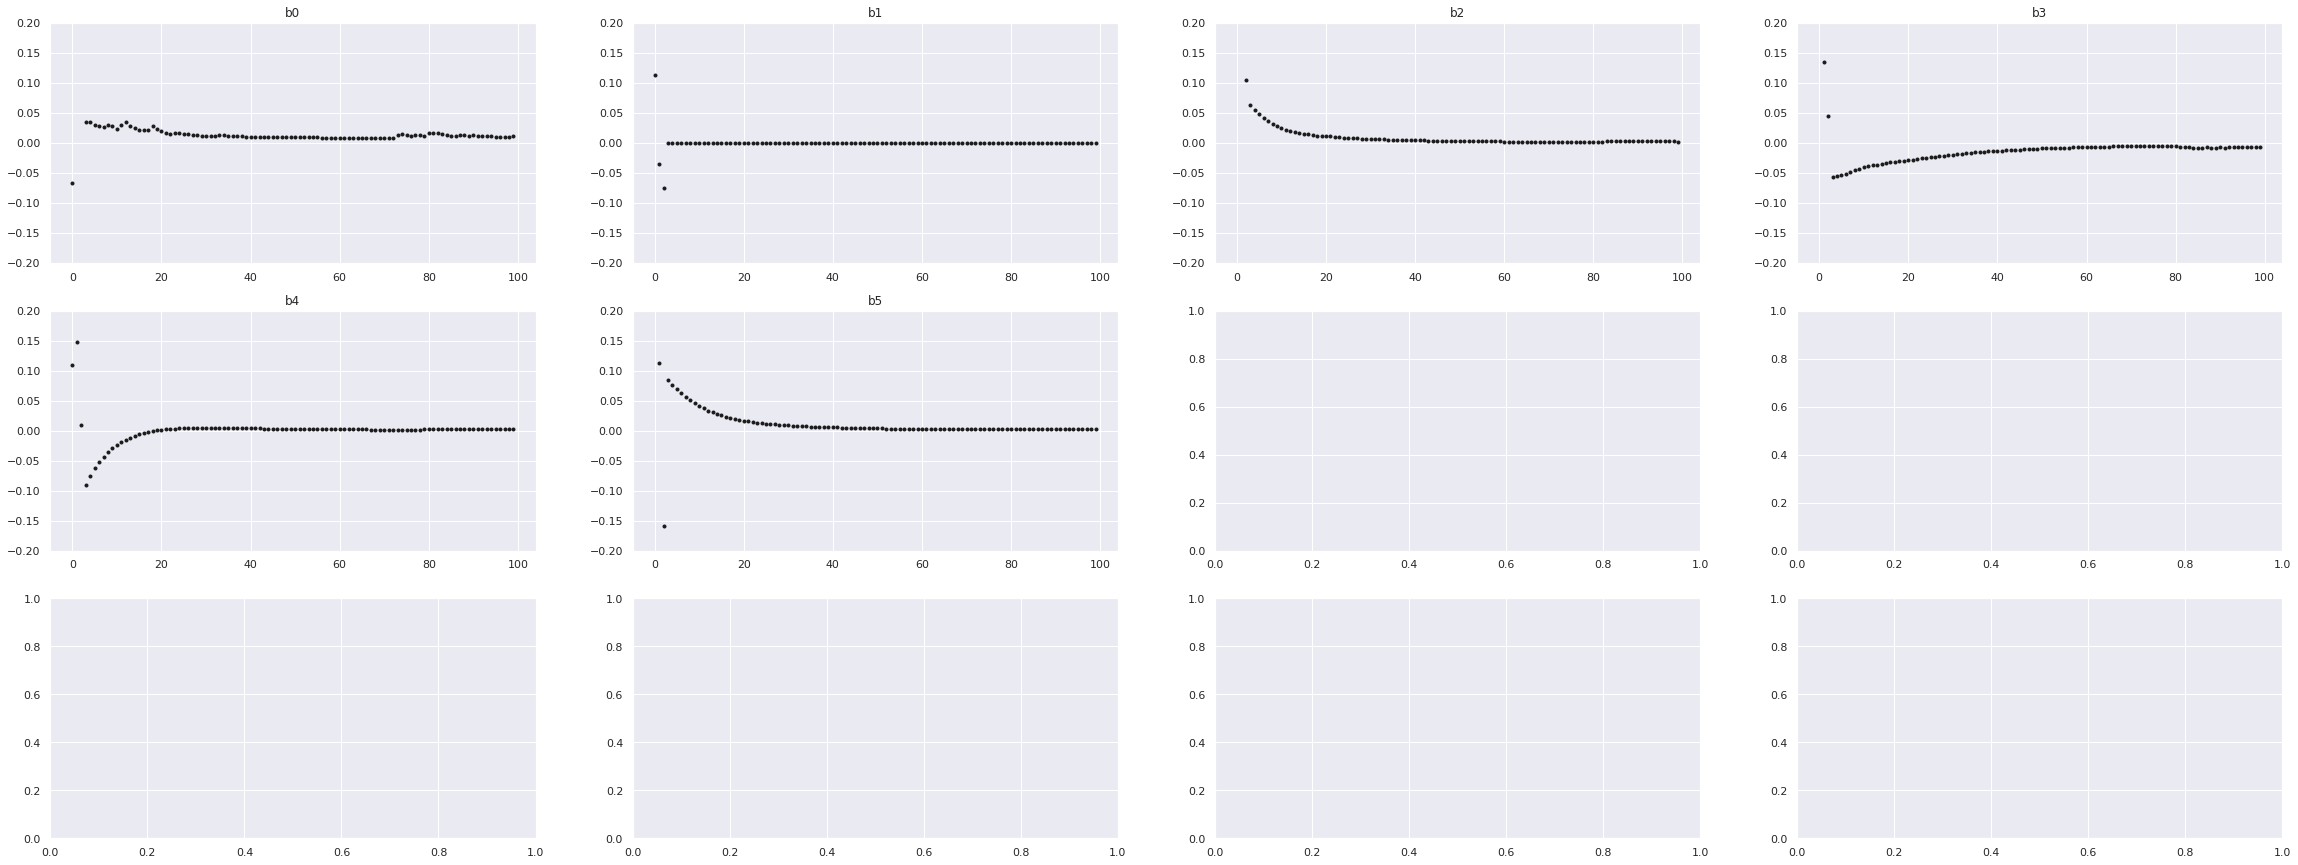

Activation function: ReLu  Intialisation method: Zeros


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:80: RuntimeWarning: invalid value encountered in true_divide


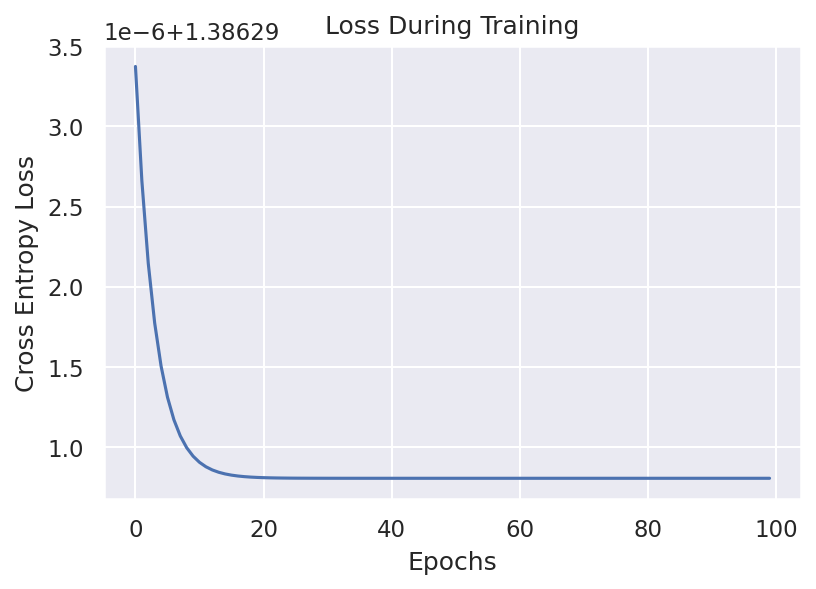

Train accuracy is 0.25066666666666665
Test accuracy is 0.248
Min loss is 1.3862908055601206


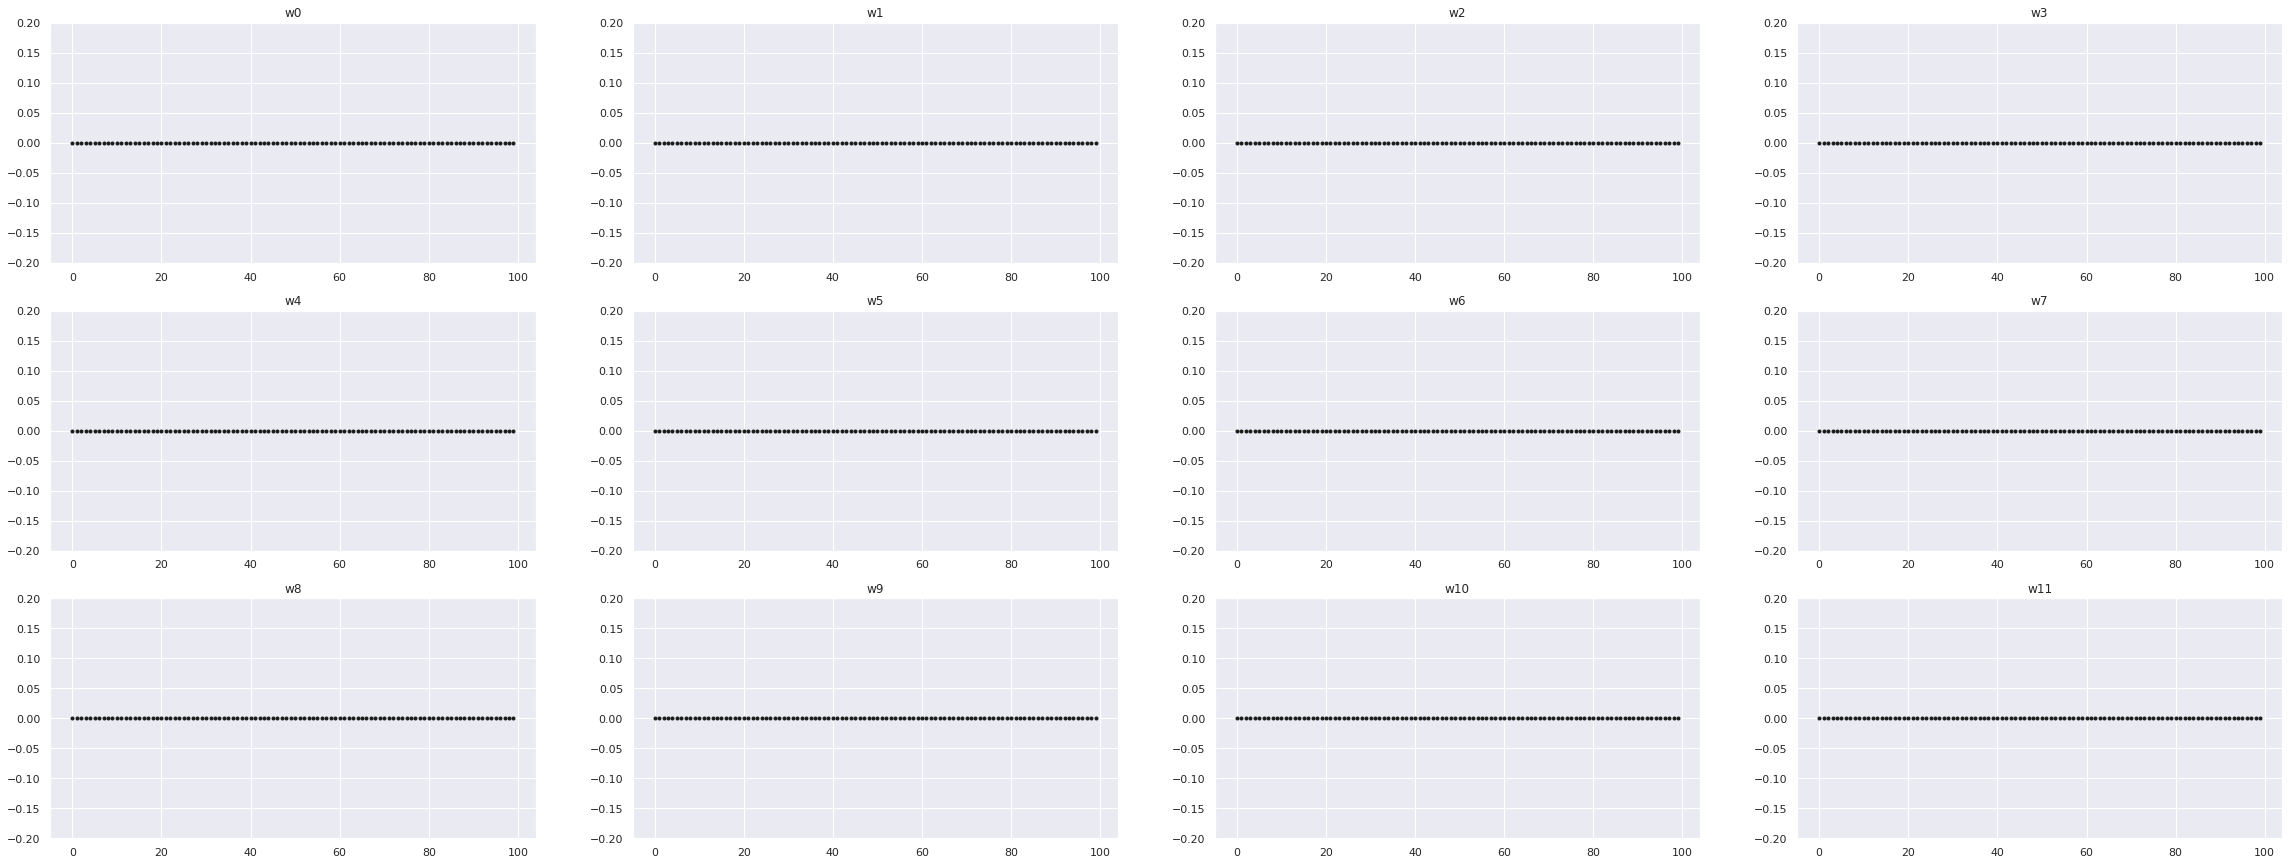

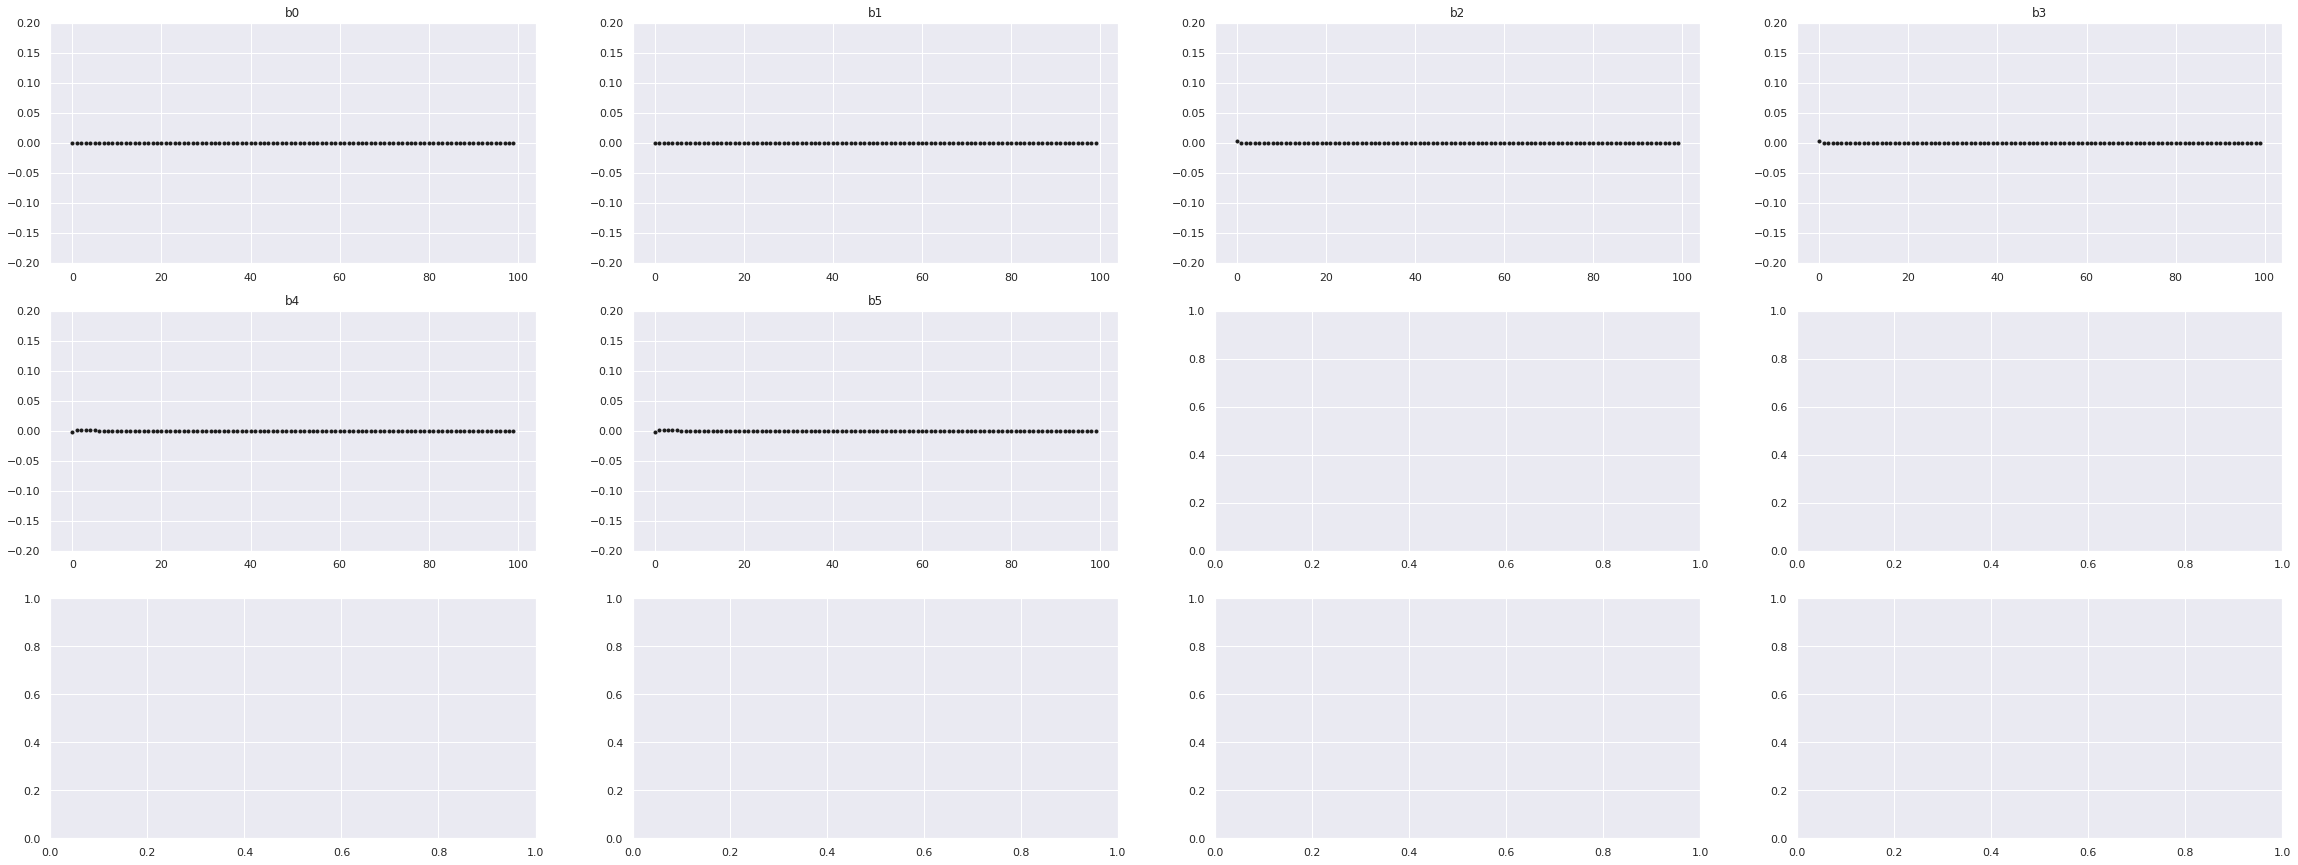

Activation function: ReLu  Intialisation method: Xavier


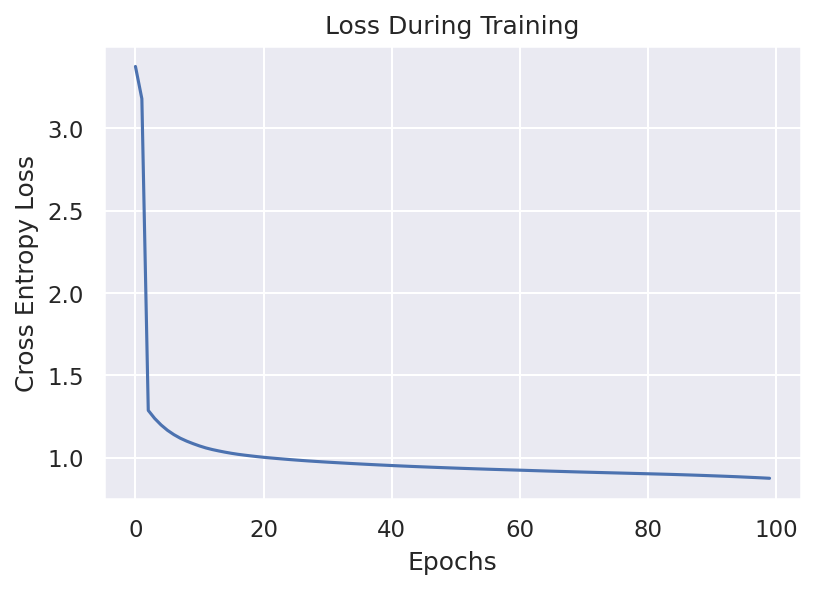

Train accuracy is 0.5506666666666666
Test accuracy is 0.576
Min loss is 0.8750687420685781


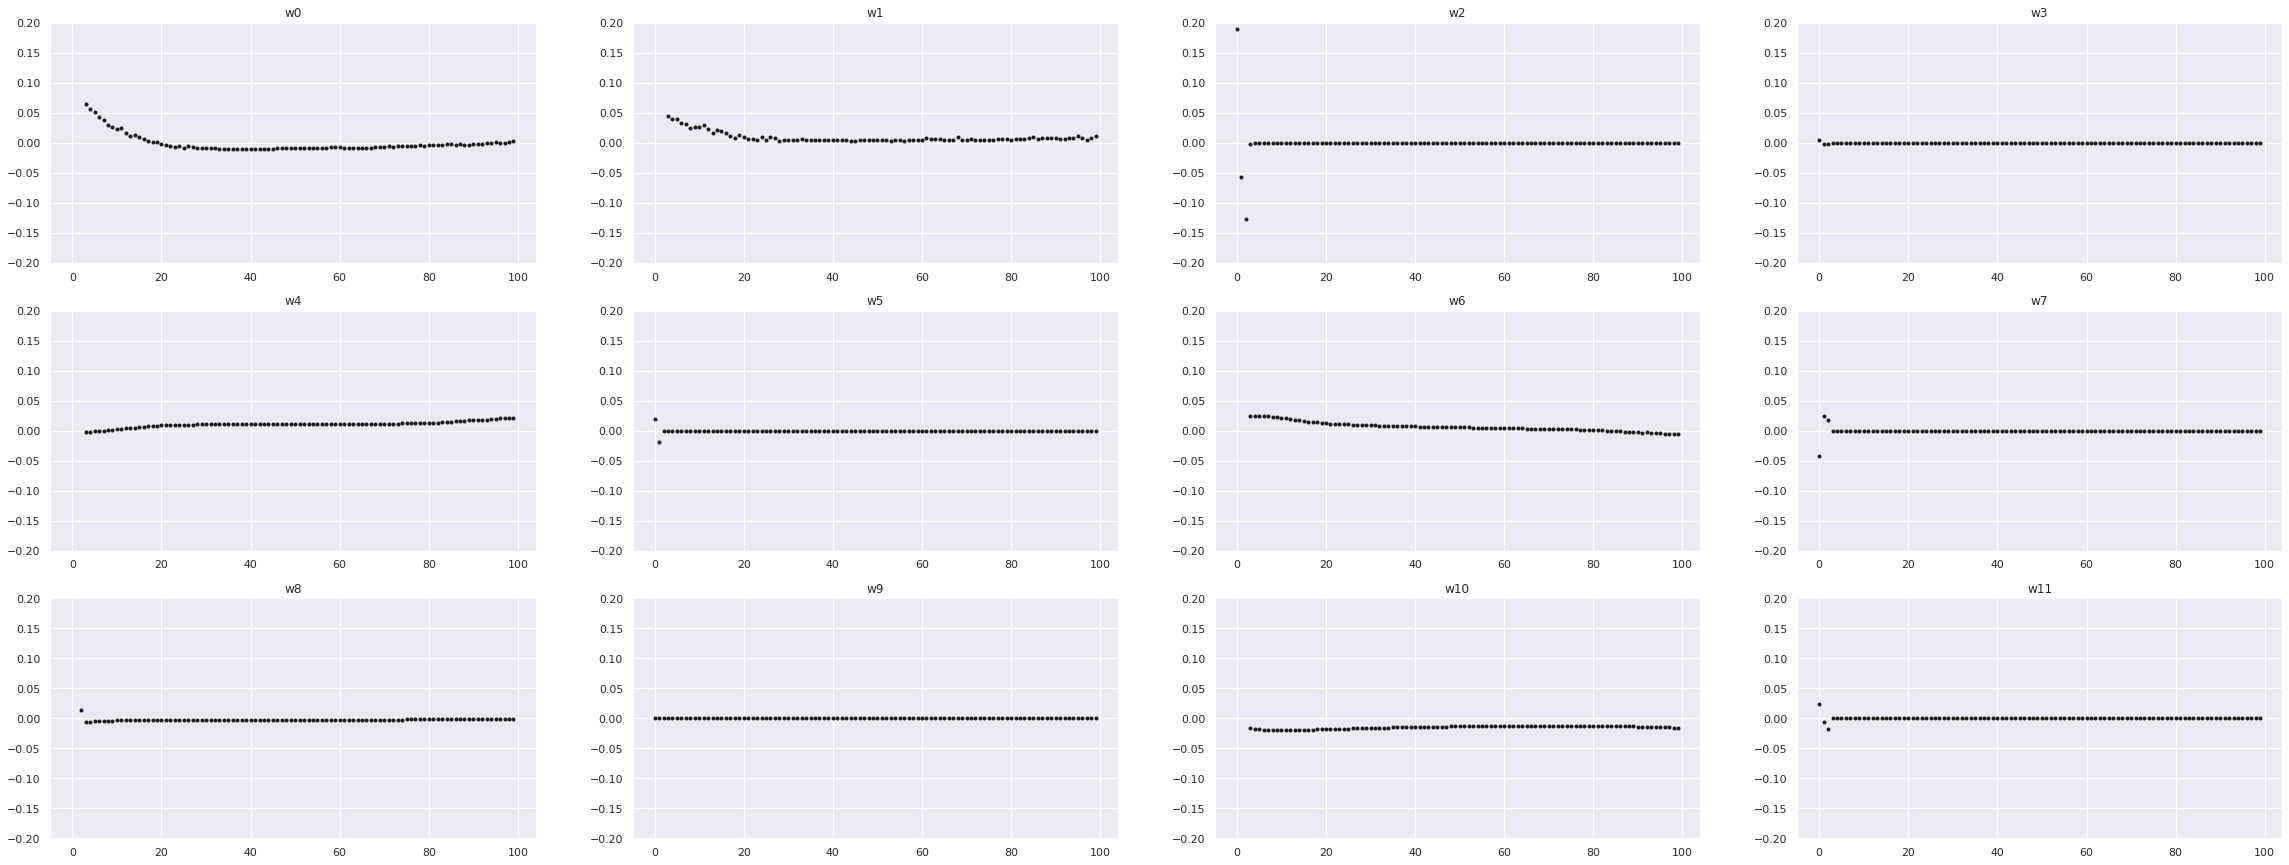

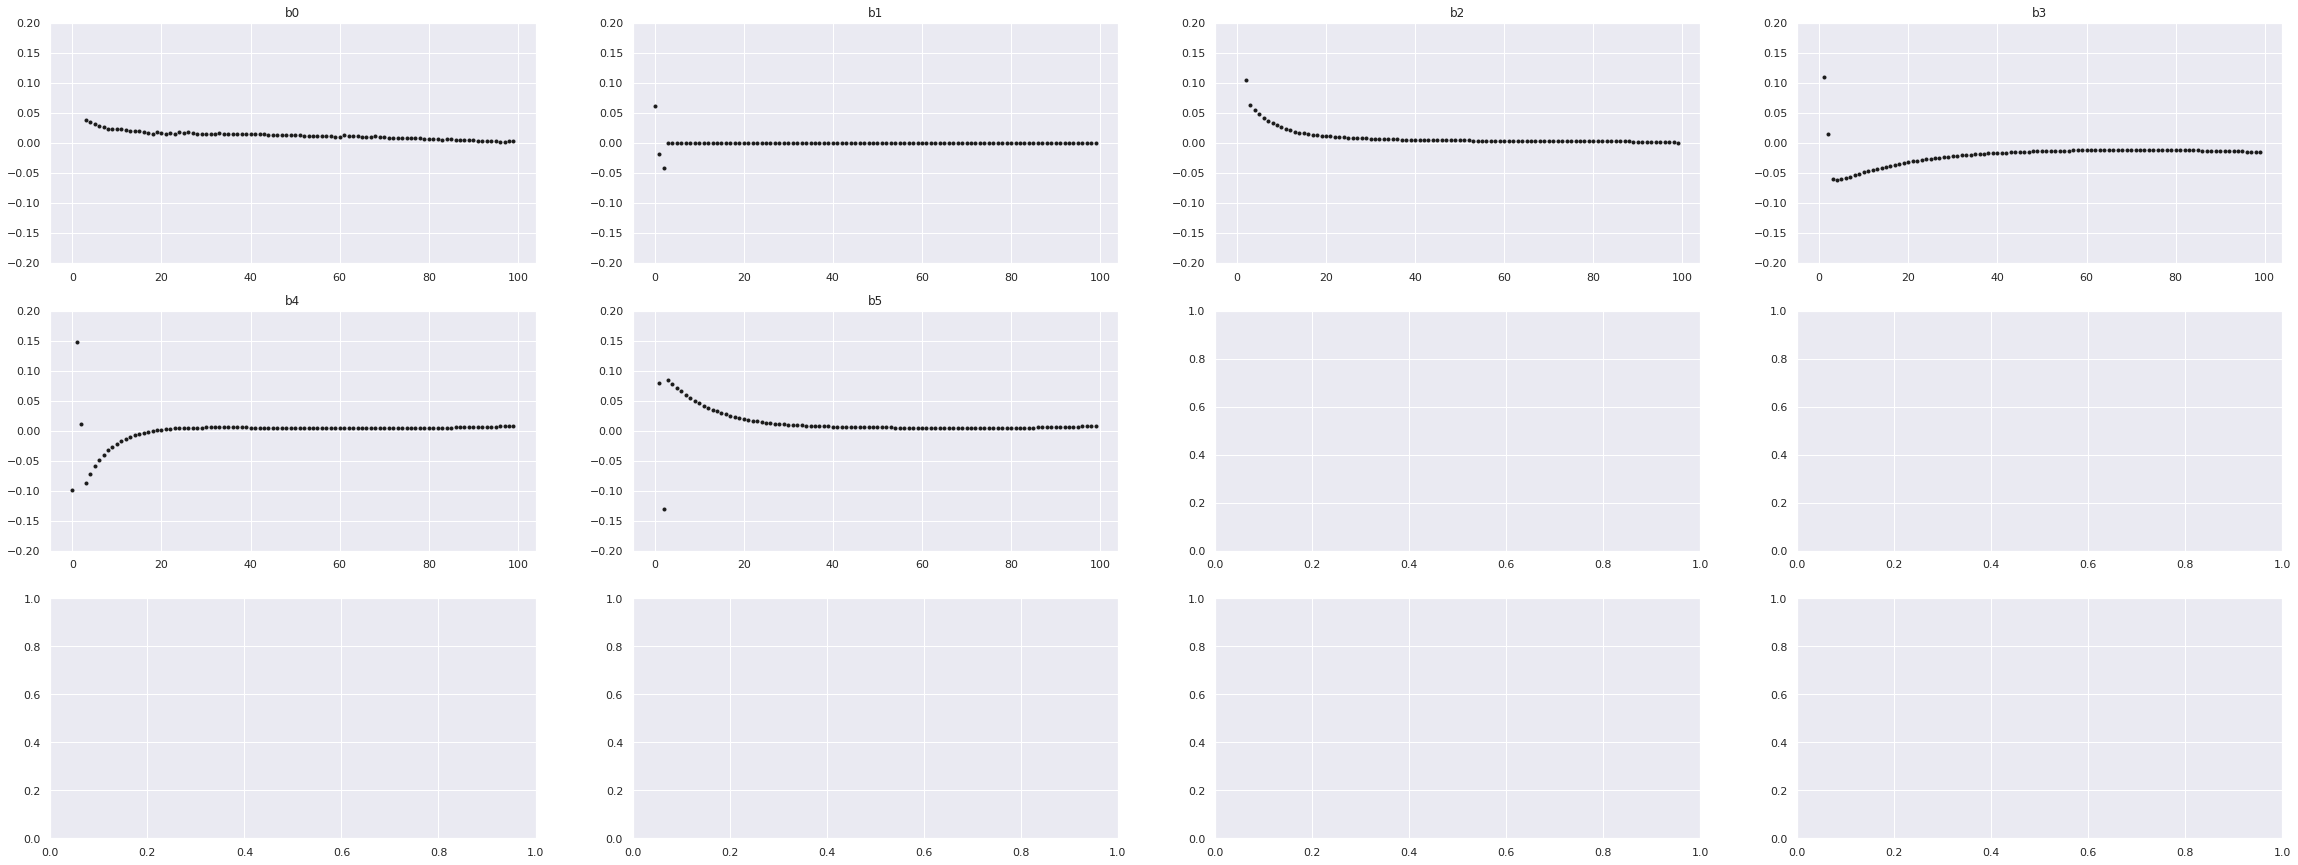

Activation function: ReLu  Intialisation method: He


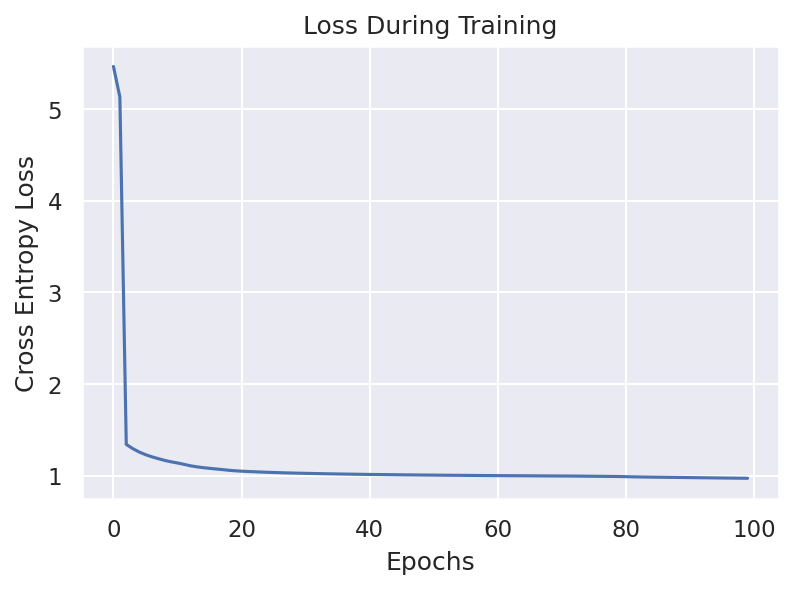

Train accuracy is 0.4693333333333333
Test accuracy is 0.484
Min loss is 0.9709603168969


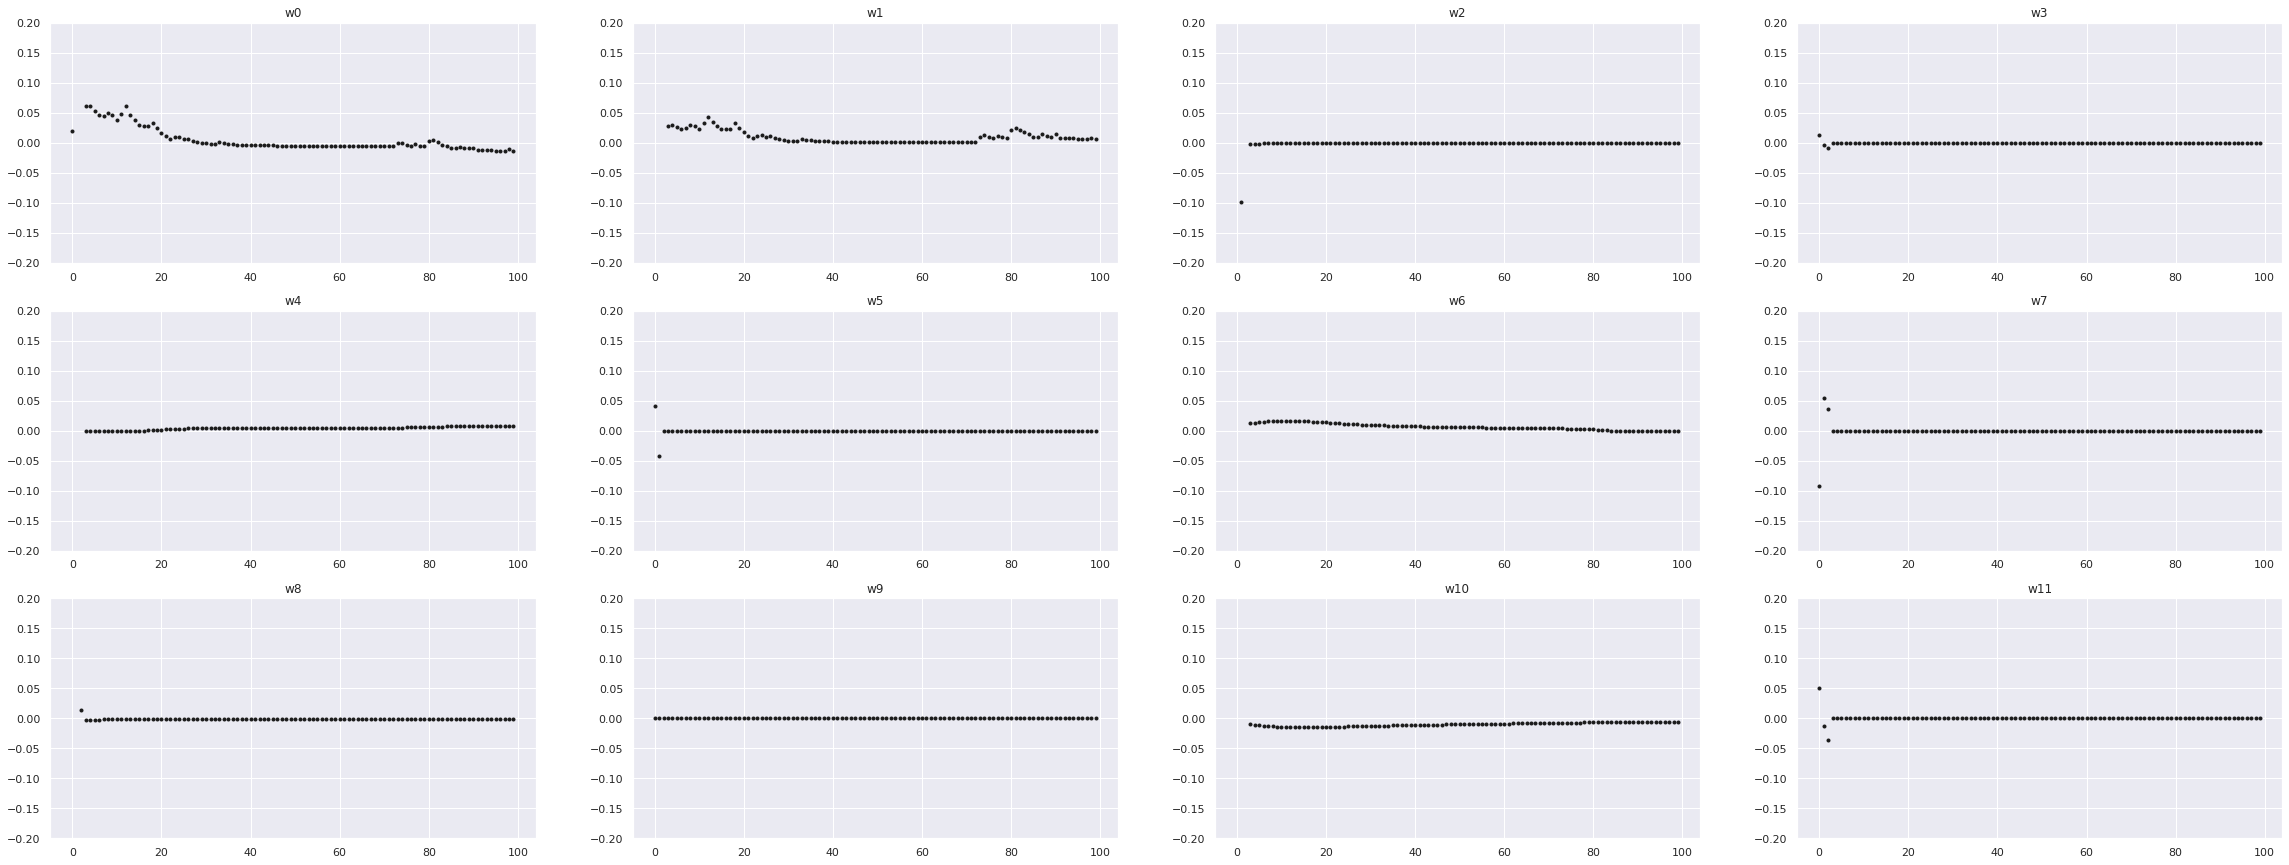

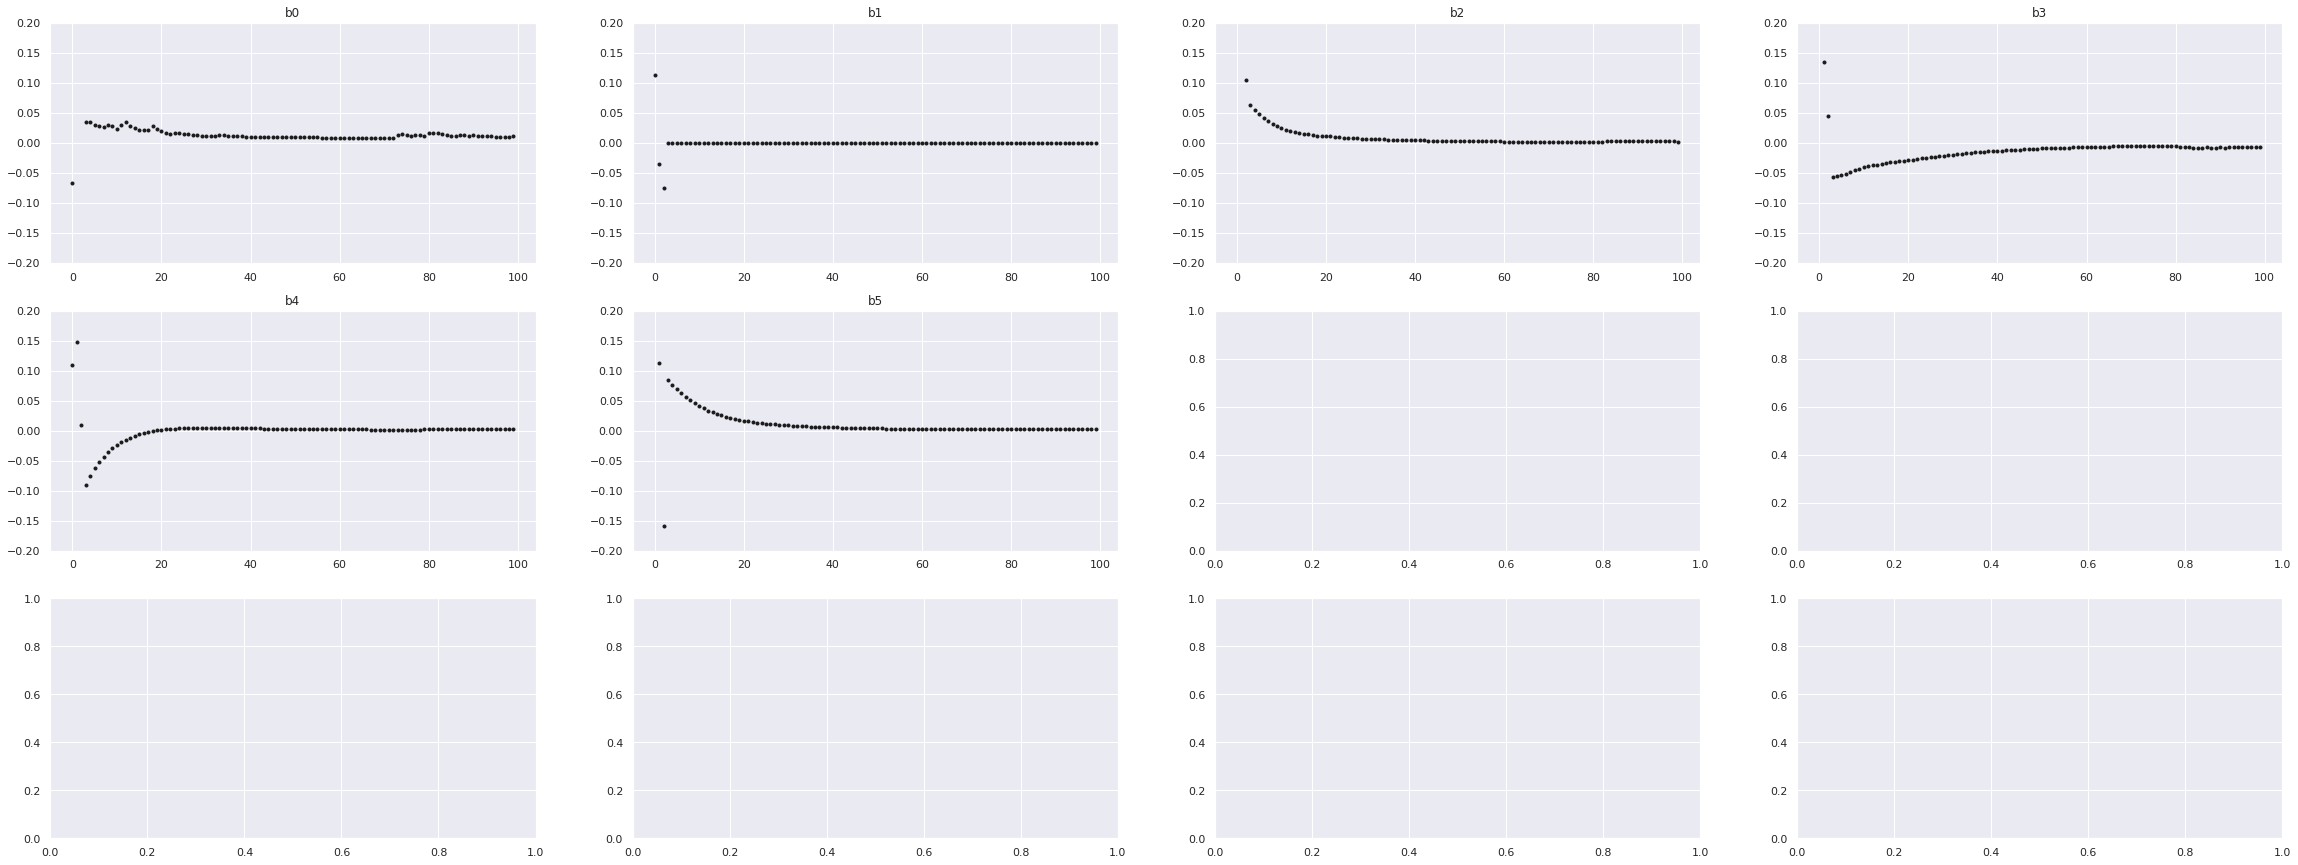

Activation function: Leaky_ReLu  Intialisation method: Random


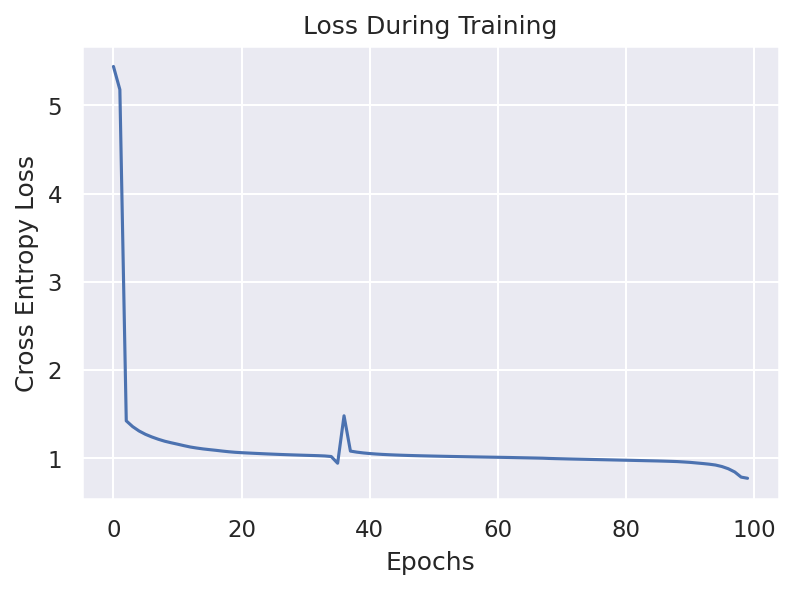

Train accuracy is 0.6773333333333333
Test accuracy is 0.688
Min loss is 0.7691507221718875


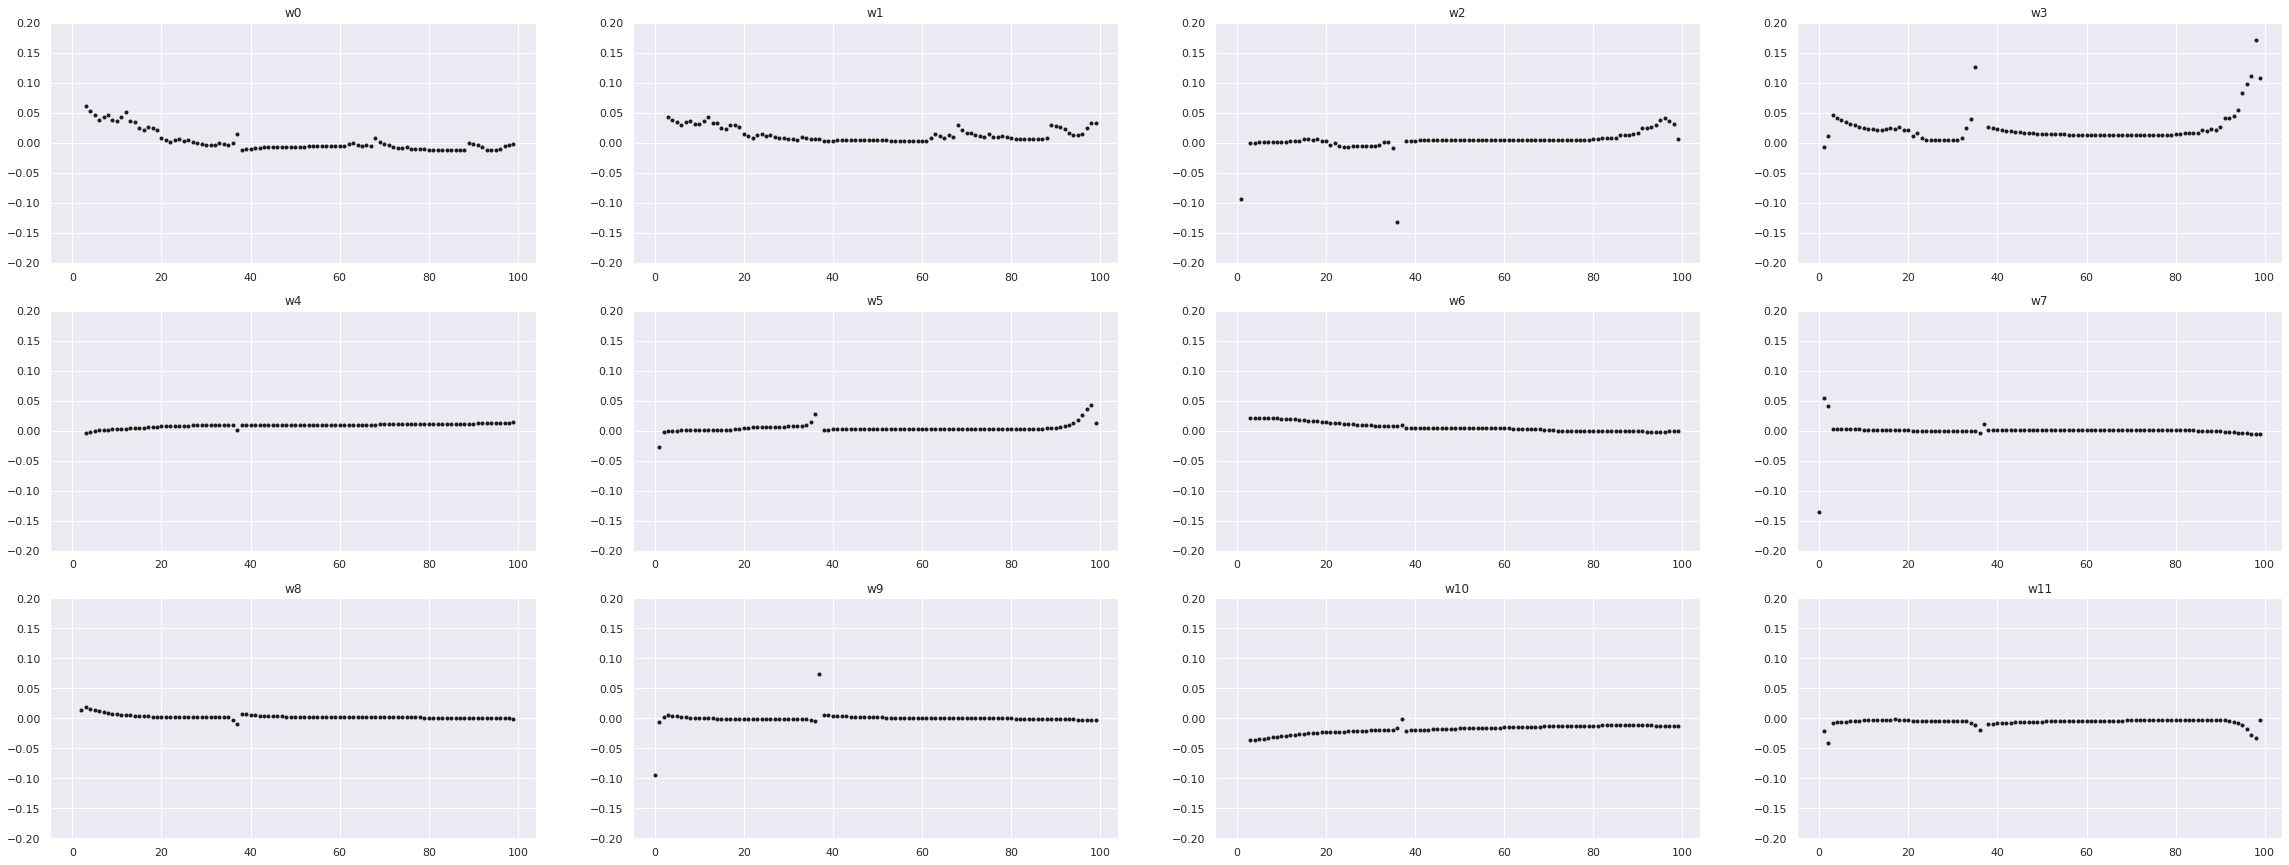

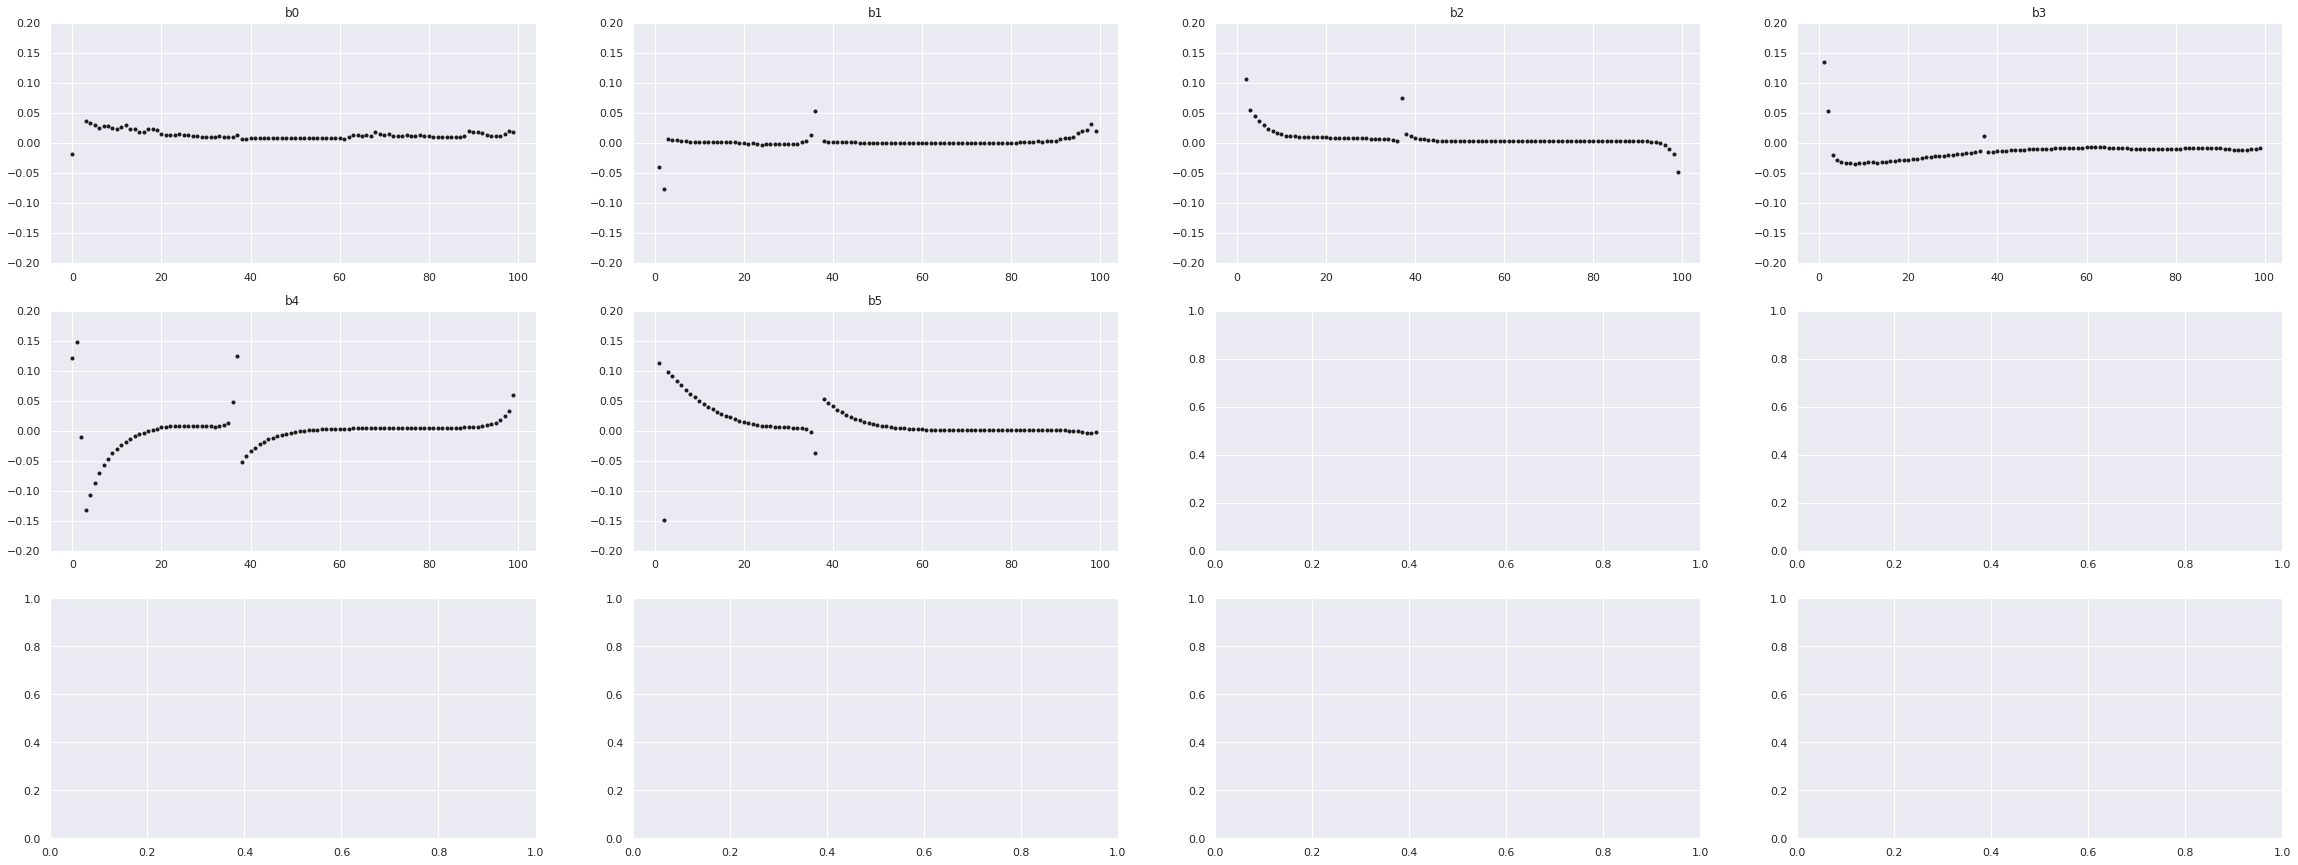

Activation function: Leaky_ReLu  Intialisation method: Zeros


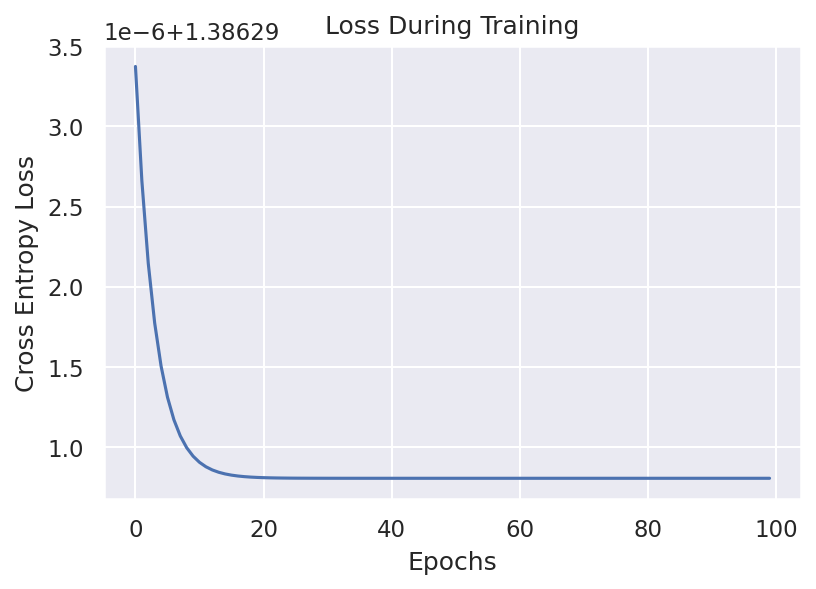

Train accuracy is 0.25066666666666665
Test accuracy is 0.248
Min loss is 1.3862908055601206


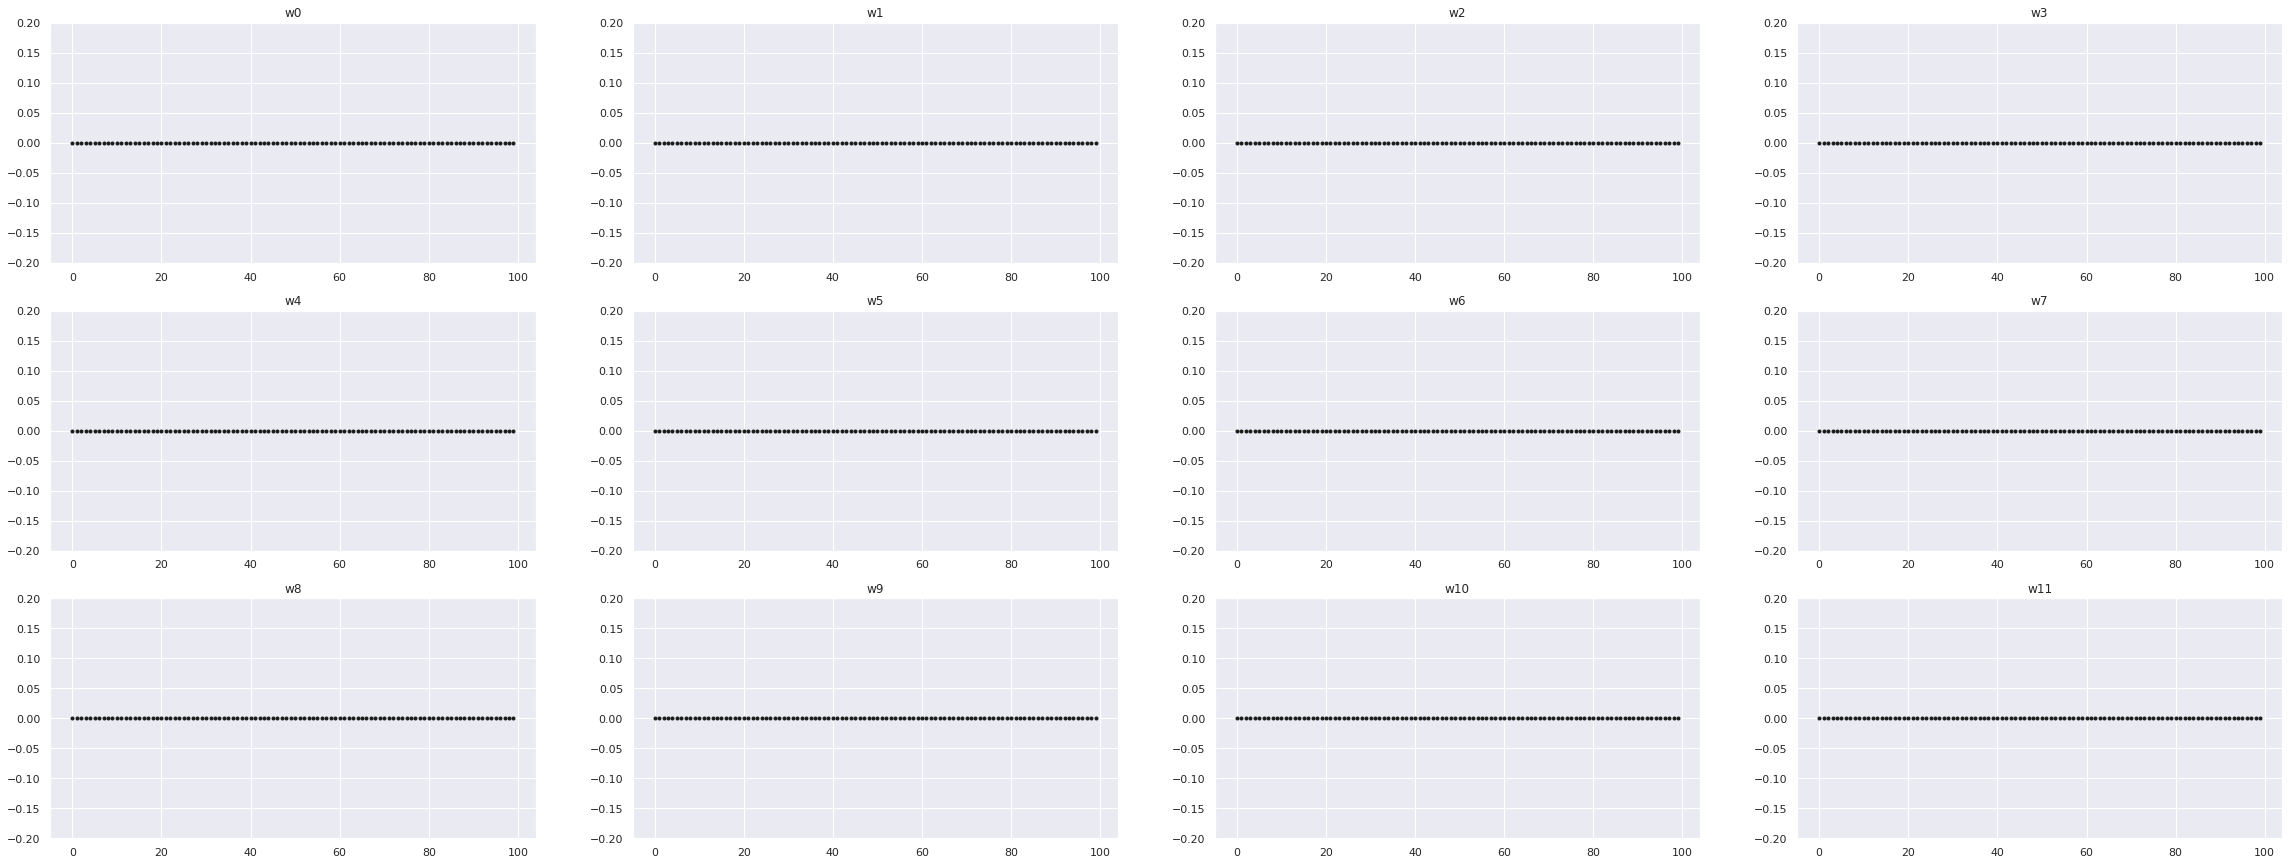

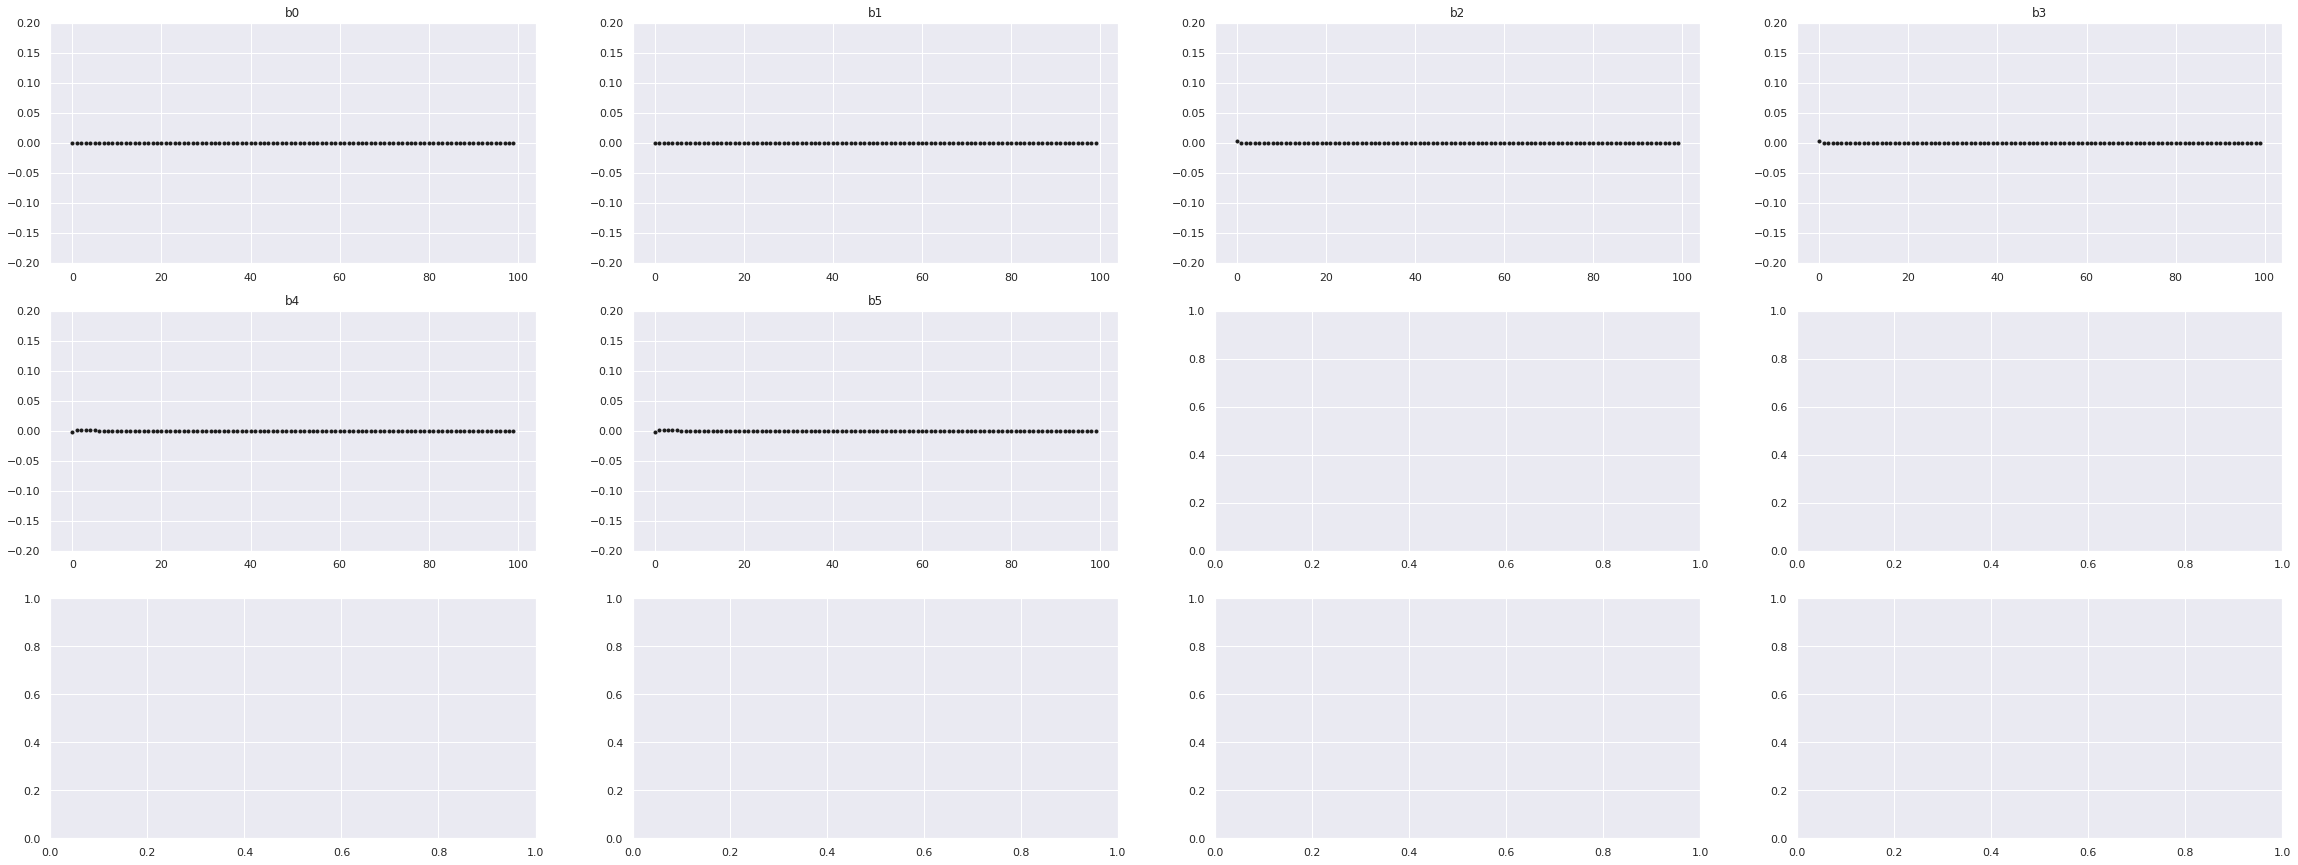

Activation function: Leaky_ReLu  Intialisation method: Xavier


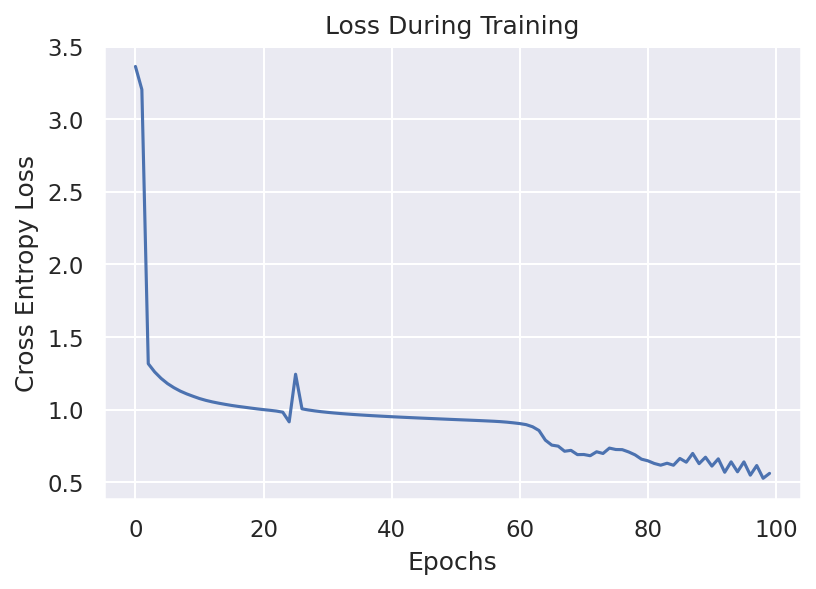

Train accuracy is 0.768
Test accuracy is 0.764
Min loss is 0.5268777697979546


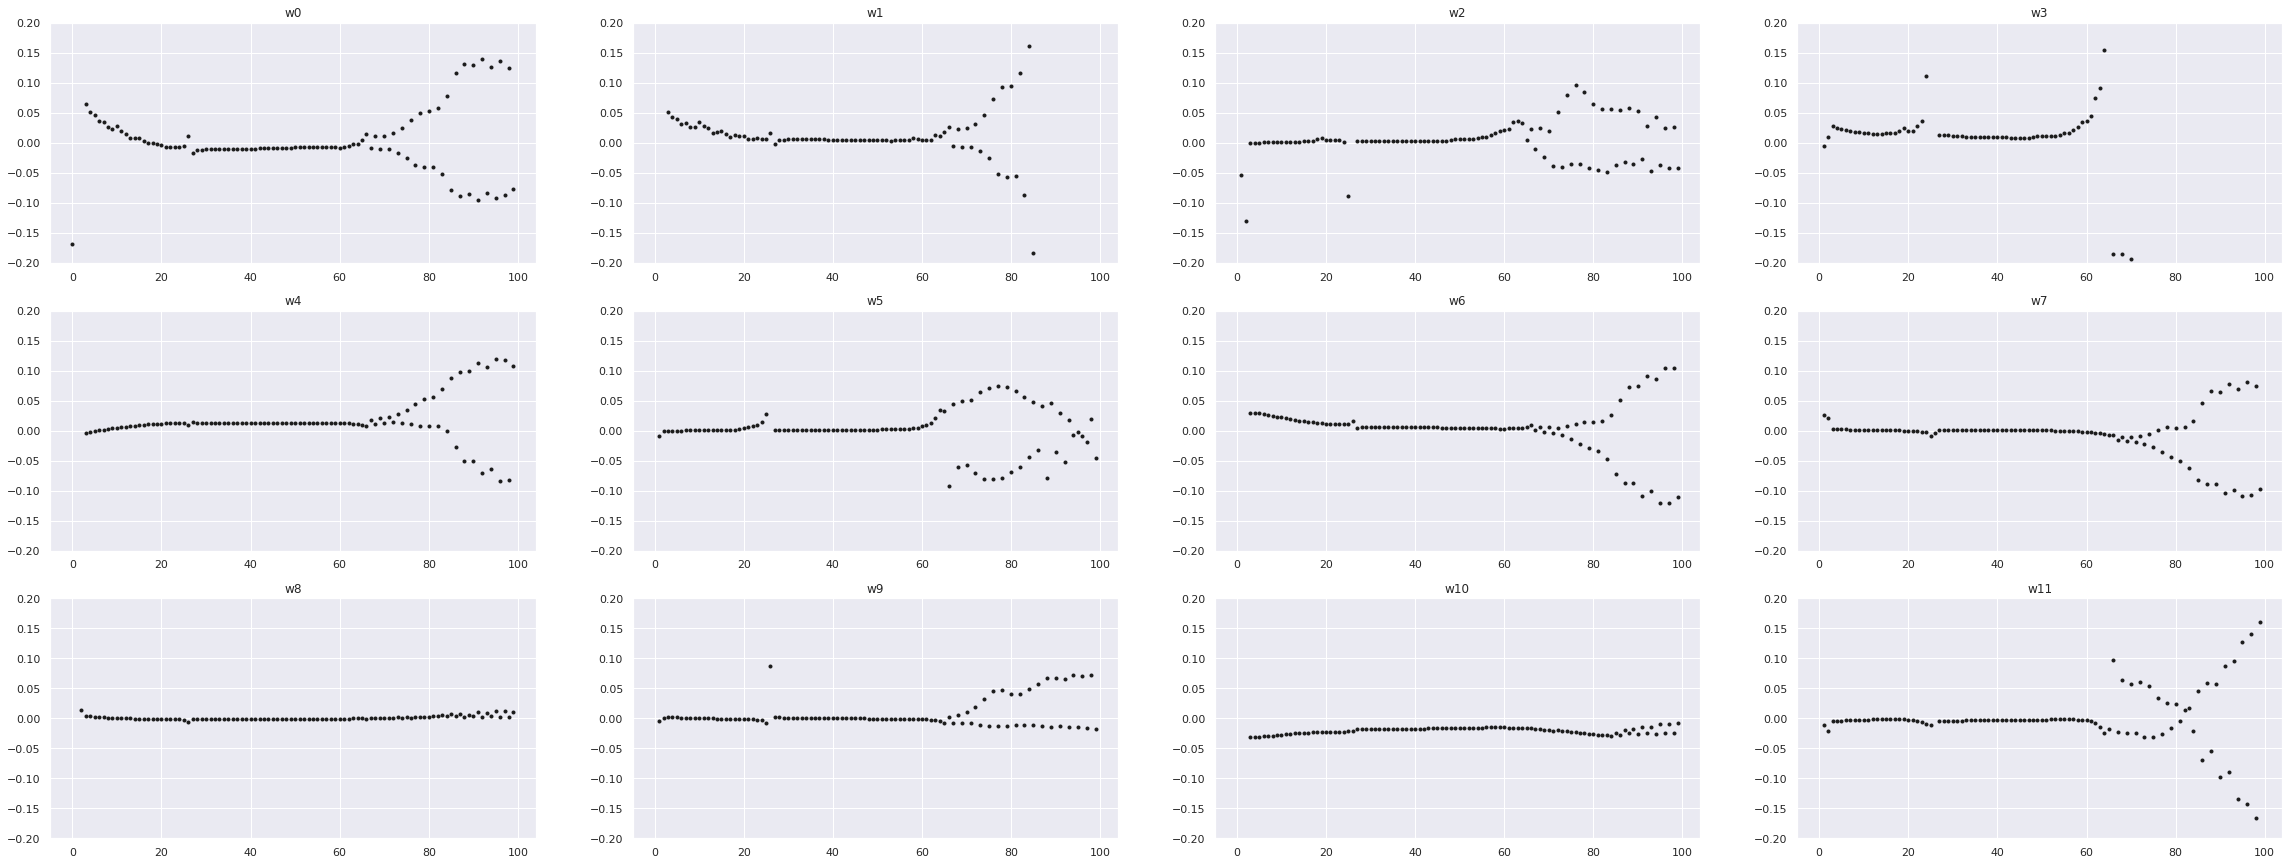

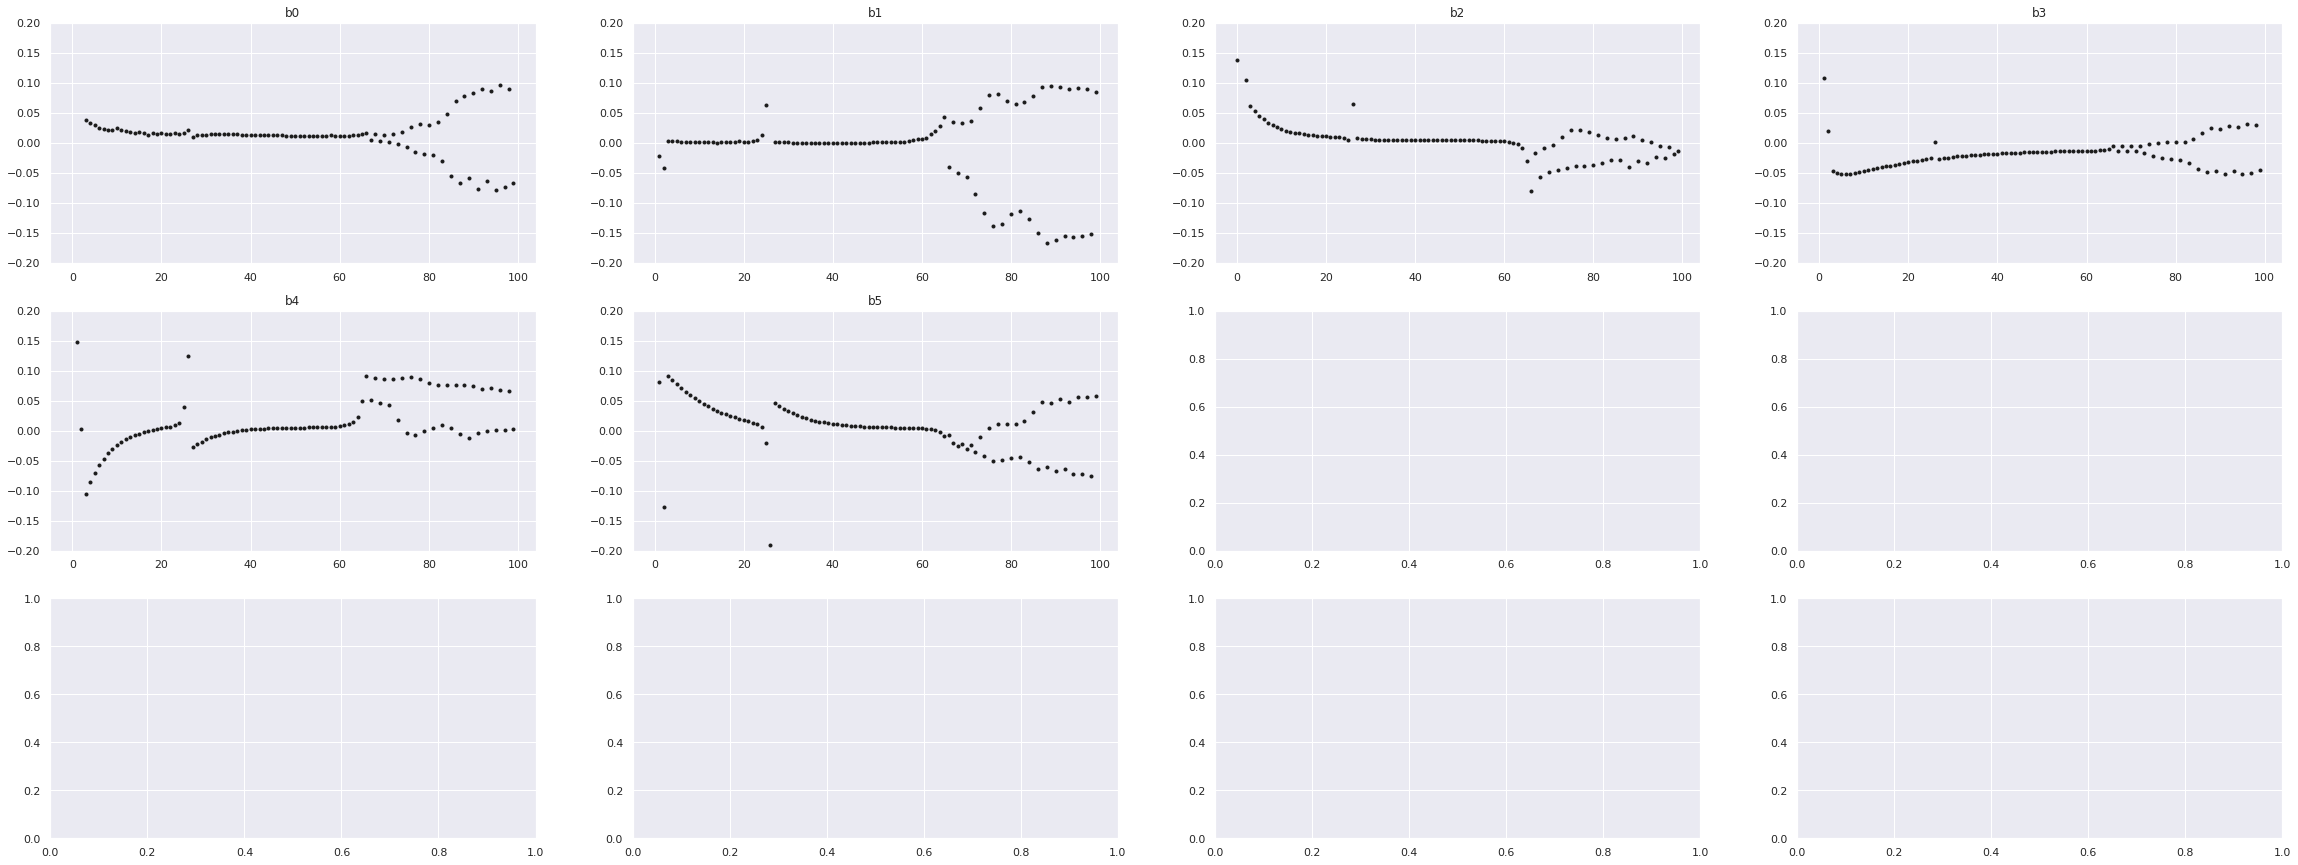

Activation function: Leaky_ReLu  Intialisation method: He


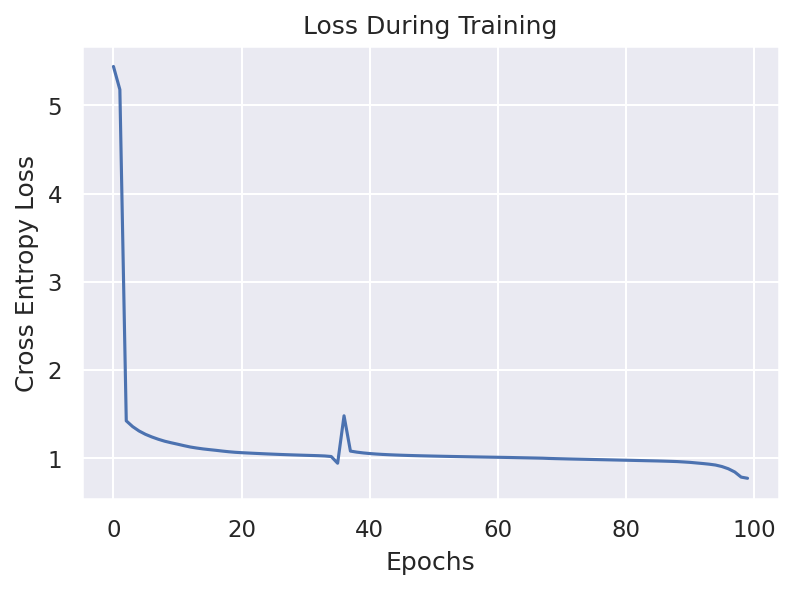

Train accuracy is 0.6773333333333333
Test accuracy is 0.688
Min loss is 0.7691507221718875


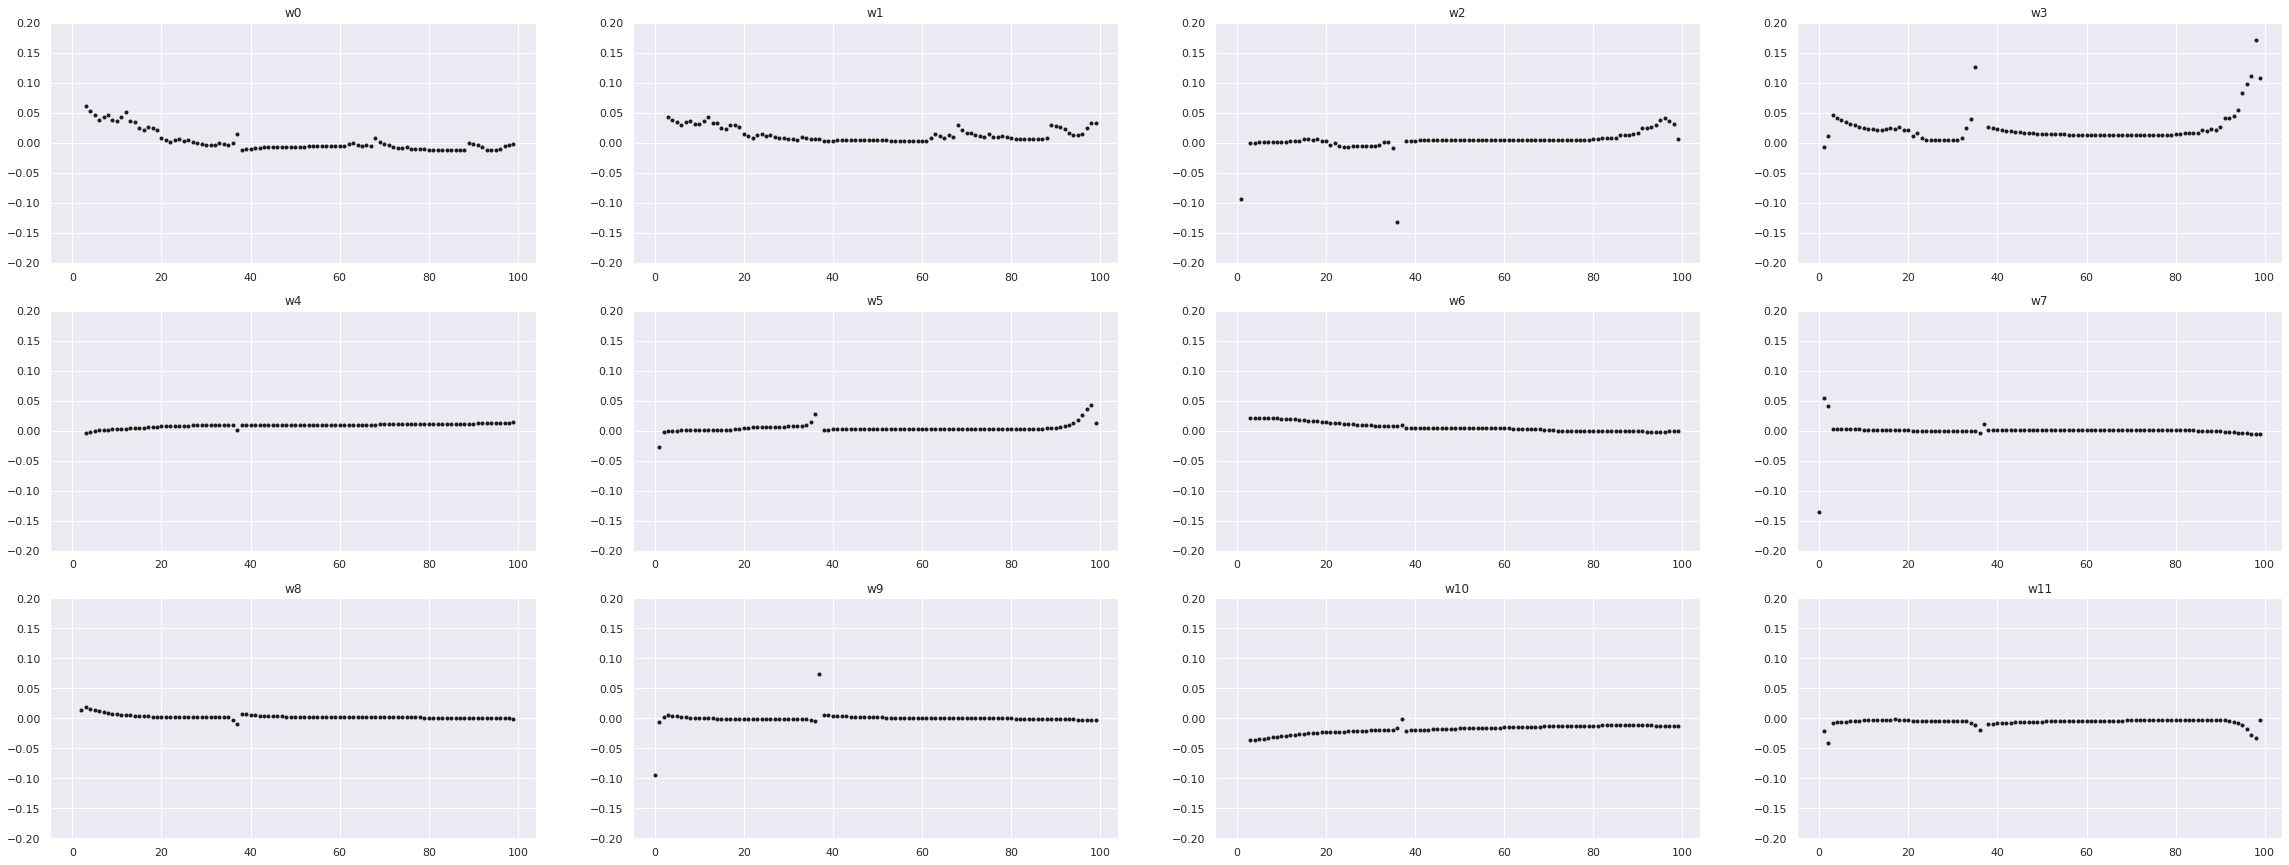

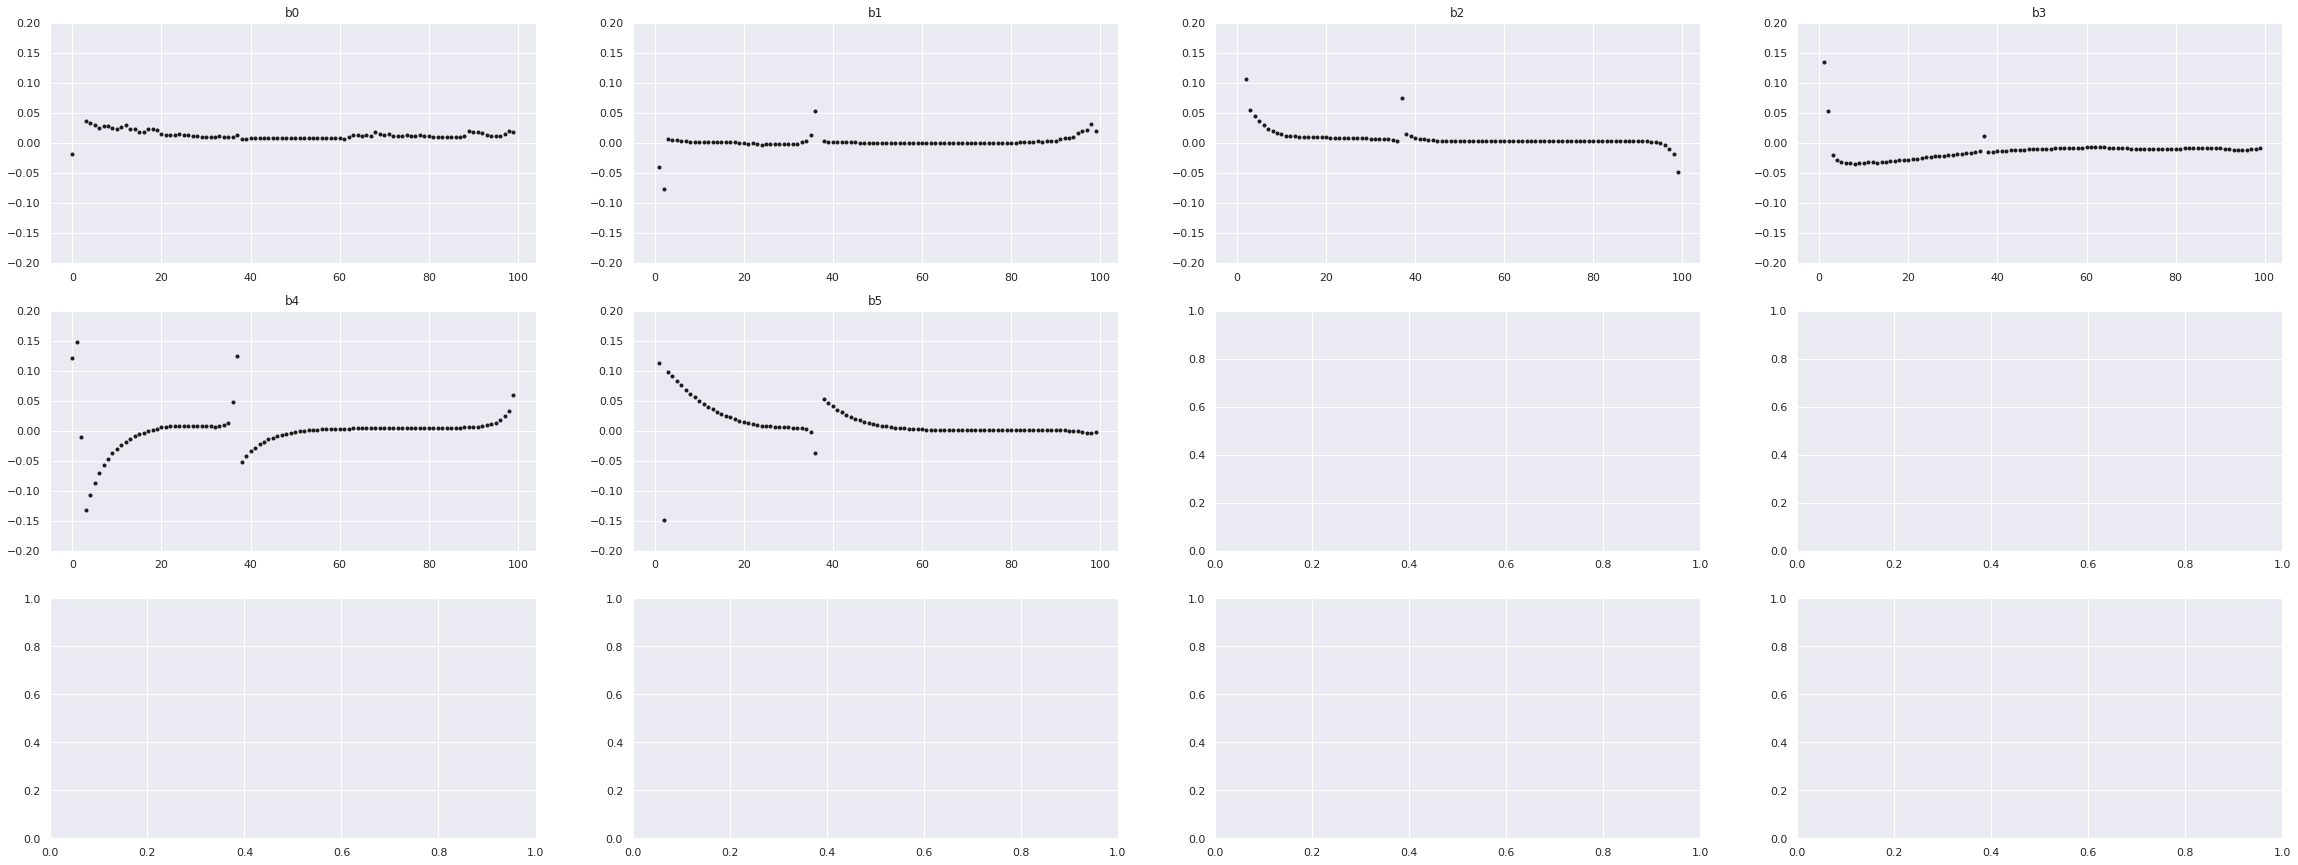

In [ ]:
for activation1 in ['Sigmoid','tanh','ReLu','Leaky_ReLu']:
  for initialisation1 in ['Random','Zeros','Xavier','He']:
    print('Activation function:',activation1,' Intialisation method:',initialisation1)
    nw = FFNetwork_In_Ac("GD",2,4,h_layers=[2],init_method = initialisation1, activation_func = activation1)
    nw.train(X_train,Y_train2,lr=0.0008,epochs=100)
    compute_accuracies(nw,X_train,X_test)
    plot_training_weight_changes(nw,3,4,100,6)

#We shall now train several models, with different intialisation methods and activation functions
#The results also depend on how deep the network is 
